 # Import Packages

In [1]:
import itertools
import warnings

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
import scipy.stats as stats
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

pio.renderers.default = "iframe"
warnings.filterwarnings("ignore")

# Import Data

Os dados fornecidos pelo desafio em parquet são carregados para posterior análise. Adicionalmente, série temporal da cotação do dólar comercial foi adicionada, visto que sabe-se que existe correlação positiva entre preços dos combustíveis e do valor do dólar comercial.

In [10]:
data = pd.read_parquet("../data/oil_and_gas_dataset.parquet")
data.to_csv( "../data/oil_and_gas_dataset.csv")

In [11]:
url = "https://api.bcb.gov.br/dados/serie/bcdata.sgs.1/dados?formato=csv"

df_dol = pd.read_csv(url, sep=";", decimal=",")

df_dol["data"] = pd.to_datetime(df_dol["data"], format="%d/%m/%Y")
df_dol = df_dol[df_dol["data"] >= "01-06-2004"]
df_dol = df_dol.sort_values("data").set_index("data")

df_dol["valor"] = pd.to_numeric(df_dol["valor"])

df_dol_mensal = df_dol.resample("M").mean()

df_dol_mensal.index = (df_dol_mensal.index + pd.DateOffset(months=1)).to_period("M").to_timestamp()
df_dol_mensal.rename(columns={"valor": "dol_val"}, inplace=True)

df_dol_mensal.to_csv("dolar_bcb_mensal_primeiro_dia.csv")

print(df_dol_mensal.head())

             dol_val
data                
2004-02-01  2.849453
2004-03-01  2.930311
2004-04-01  2.905457
2004-05-01  2.905985
2004-06-01  3.100419


In [4]:
data = data.merge(df_dol_mensal,
           left_on="data",
           right_on="data",
           how = "left")


data.head()

bandeira_revenda_cat sigla_uf sigla_uf_nome id_municipio id_municipio_nome  \
0          White Label       BA         Bahia      2917607        Jaguaquara   
1           Blue Label       SP     São Paulo      3550308         São Paulo   
2          Green Label       SP     São Paulo      3550308         São Paulo   
3          Green Label       SP     São Paulo      3505708           Barueri   
4          White Label       SP     São Paulo      3513009             Cotia   

    produto unidade_medida  n_estabelecimentos  avg_preco_compra  \
0  Gasolina       R$/litro                   5          1.723251   
1    Diesel       R$/litro                  33          1.225628   
2    Diesel       R$/litro                 128          1.224991   
3    Etanol       R$/litro                   5          0.619567   
4    Etanol       R$/litro                  21          0.604228   

   avg_preco_venda       data   dol_val  
0         2.030526 2004-05-01  2.905985  
1         1.397636 2004-05-01  2.905985  
2         1.415282 2004-05-01  2.905985  
3         0.856467 2004-05-01  2.905985  
4         0.804345 2004-05-01  2.905985

In [5]:
data.nunique()

bandeira_revenda_cat         4
sigla_uf                    27
sigla_uf_nome               27
id_municipio               690
id_municipio_nome          688
produto                      3
unidade_medida               1
n_estabelecimentos         411
avg_preco_compra        228323
avg_preco_venda         250665
data                       137
dol_val                    137
dtype: int64

In [6]:
data.drop("unidade_medida", inplace = True, axis = 1, errors="ignore")
data.to_csv("../data/data_dol_val.csv")
data

bandeira_revenda_cat sigla_uf sigla_uf_nome id_municipio  \
0               White Label       BA         Bahia      2917607   
1                Blue Label       SP     São Paulo      3550308   
2               Green Label       SP     São Paulo      3550308   
3               Green Label       SP     São Paulo      3505708   
4               White Label       SP     São Paulo      3513009   
...                     ...      ...           ...          ...   
556496           Blue Label       MA      Maranhão      2111300   
556497           Blue Label       PA          Pará      1506807   
556498         Purple Label       SP     São Paulo      3526902   
556499         Purple Label       SP     São Paulo      3518800   
556500          White Label       PB       Paraíba      2503209   

       id_municipio_nome   produto  n_estabelecimentos  avg_preco_compra  \
0             Jaguaquara  Gasolina                   5          1.723251   
1              São Paulo    Diesel                  33          1.225628   
2              São Paulo    Diesel                 128          1.224991   
3                Barueri    Etanol                   5          0.619567   
4                  Cotia    Etanol                  21          0.604228   
...                  ...       ...                 ...               ...   
556496          São Luís  Gasolina                   4               NaN   
556497          Santarém    Diesel                   6               NaN   
556498           Limeira    Diesel                   4               NaN   
556499         Guarulhos    Diesel                   1               NaN   
556500          Cabedelo    Etanol                   4               NaN   

        avg_preco_venda       data   dol_val  
0              2.030526 2004-05-01  2.905985  
1              1.397636 2004-05-01  2.905985  
2              1.415282 2004-05-01  2.905985  
3              0.856467 2004-05-01  2.905985  
4              0.804345 2004-05-01  2.905985  
...                 ...        ...       ...  
556496         5.836667 2024-08-01  5.542048  
556497         6.234545 2024-08-01  5.542048  
556498         6.006000 2024-08-01  5.542048  
556499         6.040000 2024-08-01  5.542048  
556500         4.753750 2024-08-01  5.542048  

[556501 rows x 11 columns]

In [7]:
# Carrega os dados (supondo que os dados sejam diários)
df = pd.read_csv("../data/data_dol_val.csv")
df['data'] = pd.to_datetime(df['data'])
df = df.set_index('data')

# Preenche possíveis valores ausentes
df = df.fillna(method='ffill').fillna(method='bfill')

# Calcula os retornos diários
df['retorno_diario'] = df['avg_preco_venda'].pct_change()

# Calcula a volatilidade mensal (desvio padrão dos retornos diários) para cada produto
volatilidade_mensal_produto = df.groupby(['produto']).resample('M')['retorno_diario'].std()

# Exibe o shape e as primeiras linhas da volatilidade mensal por produto
print(volatilidade_mensal_produto.shape)
print(volatilidade_mensal_produto)

(732,)
produto   data      
Diesel    2004-05-31    0.293505
          2004-06-30    0.265888
          2004-07-31    0.275687
          2004-08-31         NaN
          2004-09-30         NaN
                          ...   
Gasolina  2024-04-30    0.203955
          2024-05-31    0.200668
          2024-06-30    0.202655
          2024-07-31    0.202326
          2024-08-31    0.201465
Name: retorno_diario, Length: 732, dtype: float64


# Análise Exploratória


In [8]:
data.head(5)


bandeira_revenda_cat sigla_uf sigla_uf_nome id_municipio id_municipio_nome  \
0          White Label       BA         Bahia      2917607        Jaguaquara   
1           Blue Label       SP     São Paulo      3550308         São Paulo   
2          Green Label       SP     São Paulo      3550308         São Paulo   
3          Green Label       SP     São Paulo      3505708           Barueri   
4          White Label       SP     São Paulo      3513009             Cotia   

    produto  n_estabelecimentos  avg_preco_compra  avg_preco_venda       data  \
0  Gasolina                   5          1.723251         2.030526 2004-05-01   
1    Diesel                  33          1.225628         1.397636 2004-05-01   
2    Diesel                 128          1.224991         1.415282 2004-05-01   
3    Etanol                   5          0.619567         0.856467 2004-05-01   
4    Etanol                  21          0.604228         0.804345 2004-05-01   

    dol_val  
0  2.905985  
1  2.905985  
2  2.905985  
3  2.905985  
4  2.905985


## Plot Valor Médio de Venda - Cotação USD

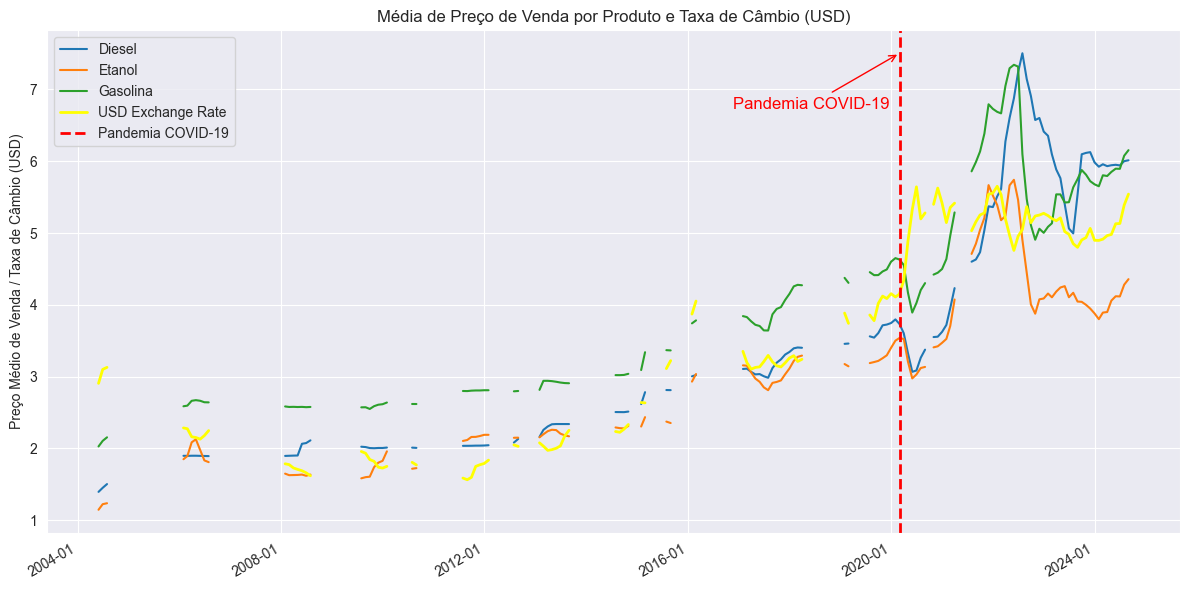

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

data = pd.read_csv("../data/data_dol_val.csv")

data['data'] = pd.to_datetime(data['data'])
data = data.set_index('data')

product_prices = (
    data.groupby('produto')[['avg_preco_venda']]
    .resample('M')
    .mean()
    .reset_index()
)

usd_prices = (
    data[['dol_val']]
    .resample('M')
    .mean()
    .reset_index()
)

fig, ax = plt.subplots(figsize=(12, 6))

for produto in product_prices['produto'].unique():
    produto_data = product_prices[product_prices['produto'] == produto]
    ax.plot(produto_data['data'], produto_data['avg_preco_venda'], label=produto)


ax.plot(usd_prices['data'], usd_prices['dol_val'], color='yellow', label='USD Exchange Rate', linewidth=2, linestyle='solid')

ax.axvline(pd.to_datetime('2020-03-01'), color='red', linestyle='dashed', linewidth=2, label='Pandemia COVID-19')

ax.annotate('Pandemia COVID-19', xy=(pd.to_datetime('2020-03-01'), product_prices['avg_preco_venda'].max()),
             xytext=(-120, -40),
             textcoords='offset points', fontsize=12, color='red',
             arrowprops=dict(arrowstyle='->', color='red'))

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
fig.autofmt_xdate()

ax.set_title('Média de Preço de Venda por Produto e Taxa de Câmbio (USD)')
ax.set_ylabel('Preço Médio de Venda / Taxa de Câmbio (USD)')
ax.legend(loc='upper left')

plt.tight_layout()

plt.savefig('grafico.png', dpi=300)

plt.show()

## Histogramas do Valor Médio de Venda de Cada Produto por Unidade Federativa

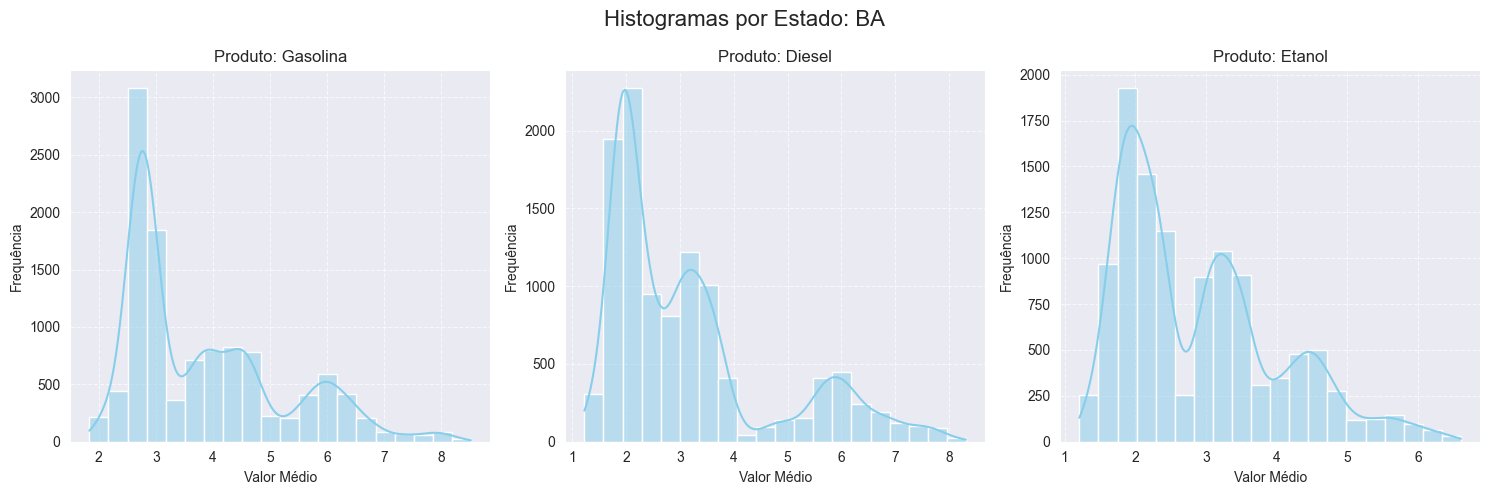

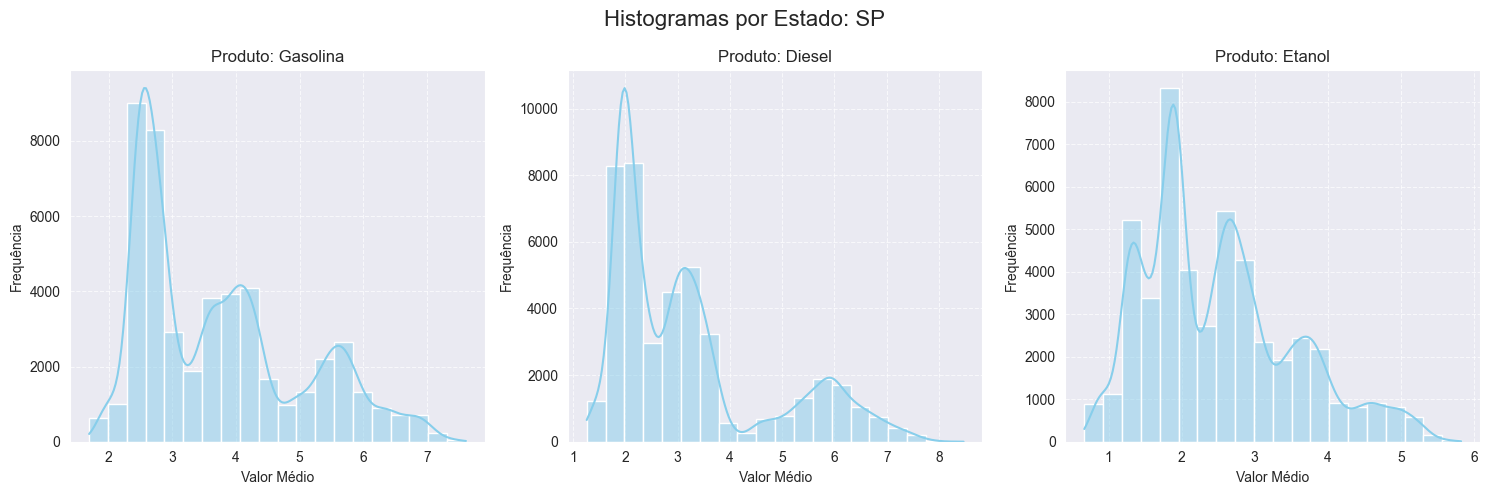

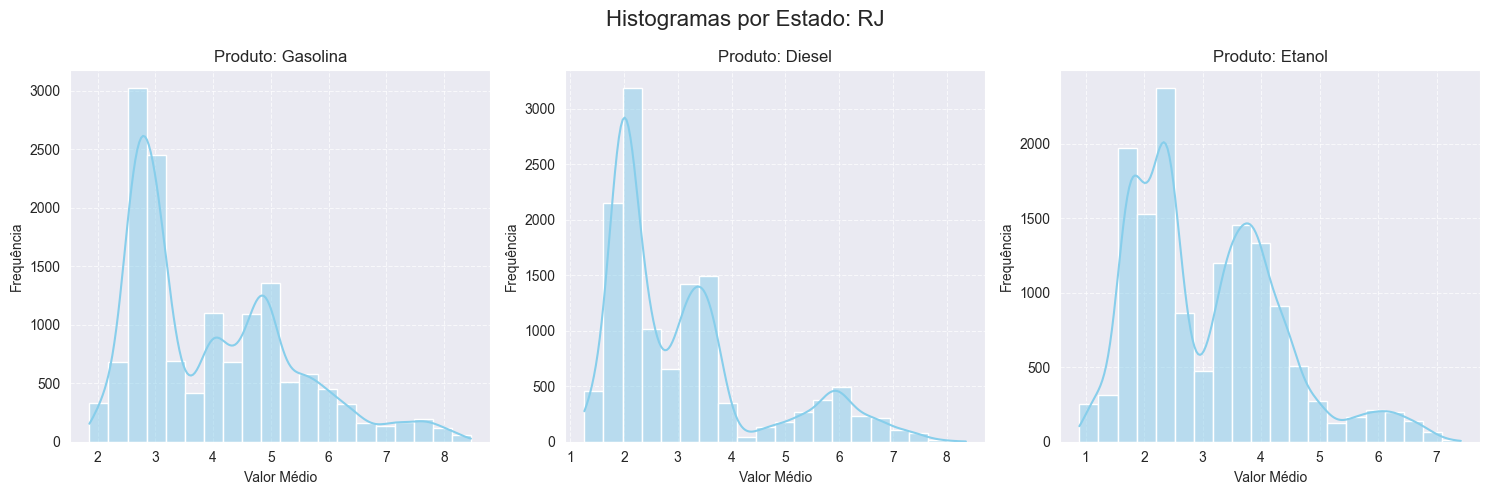

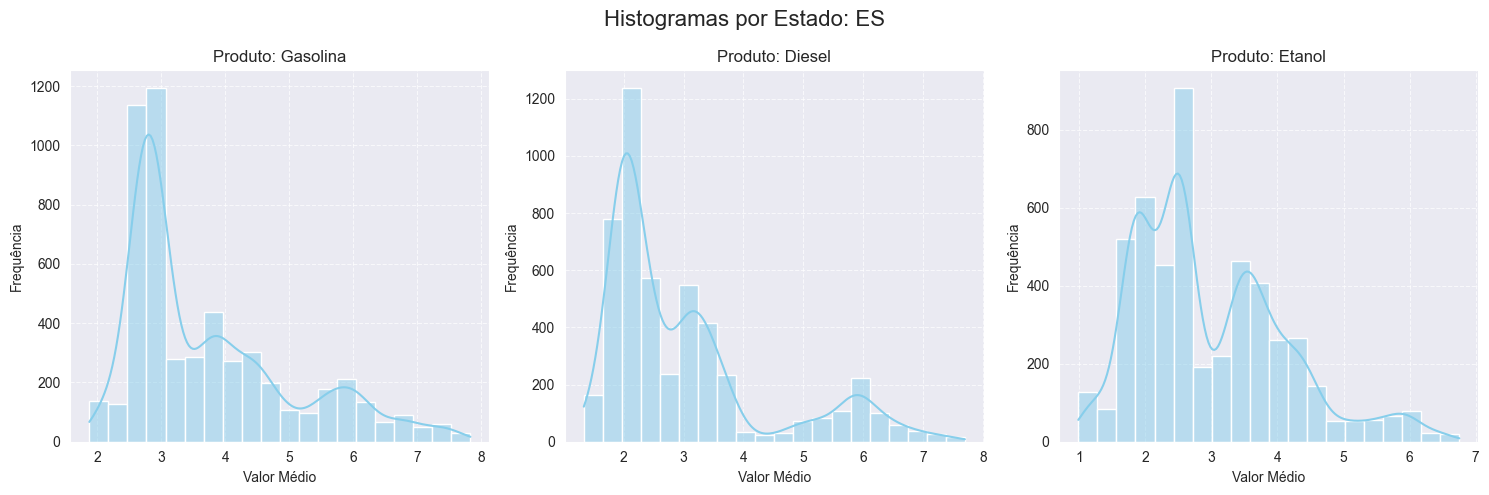

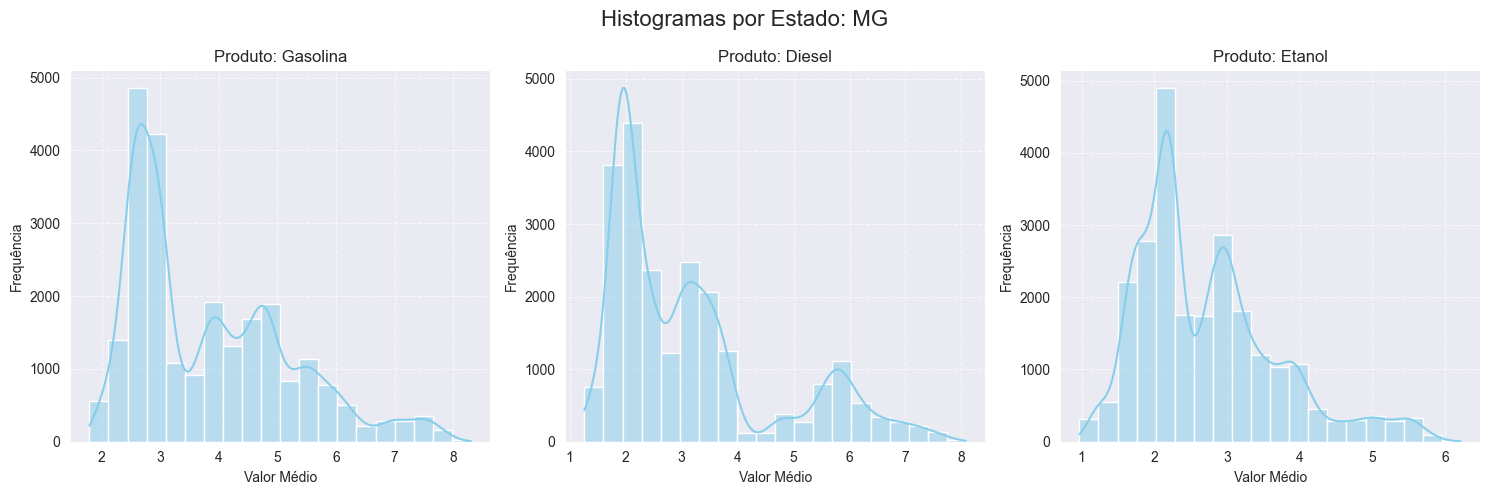

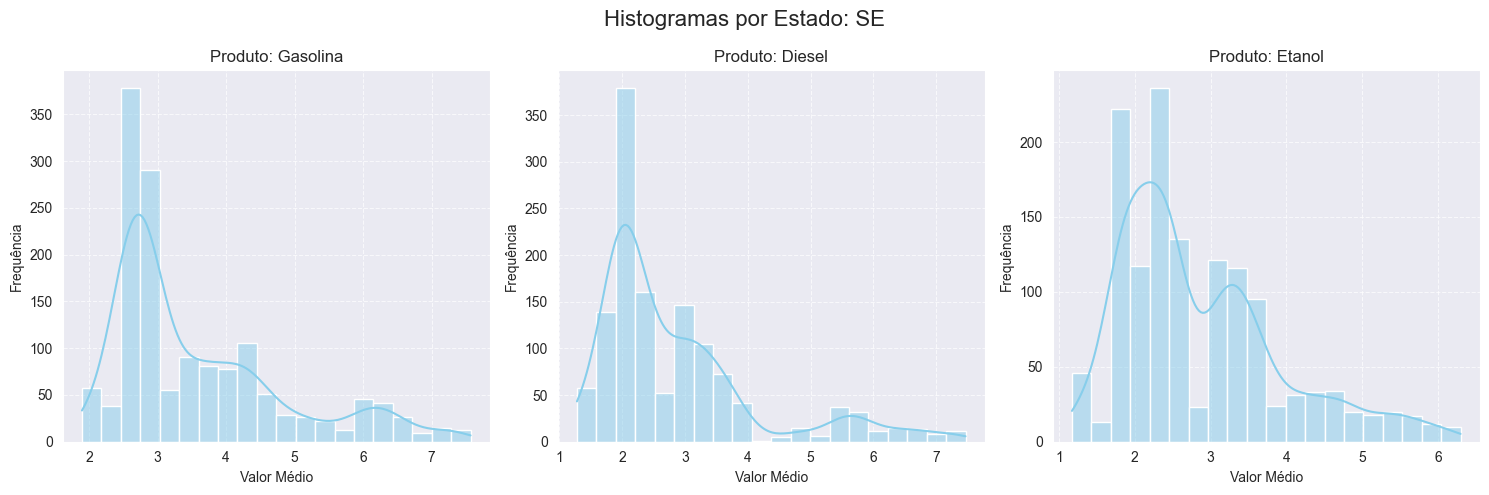

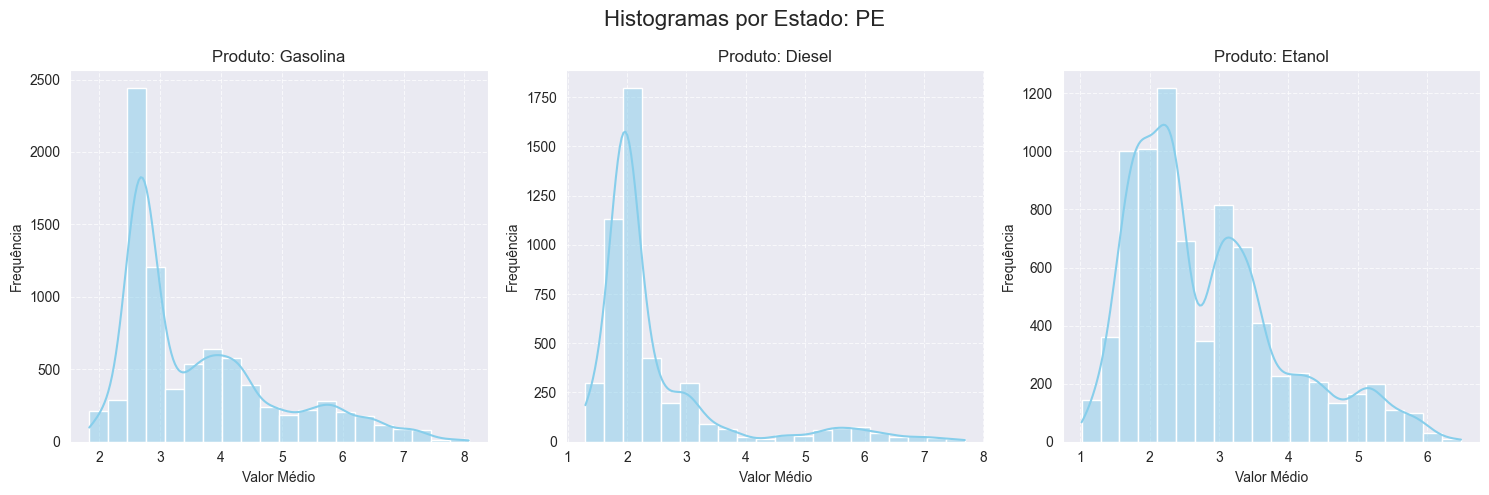

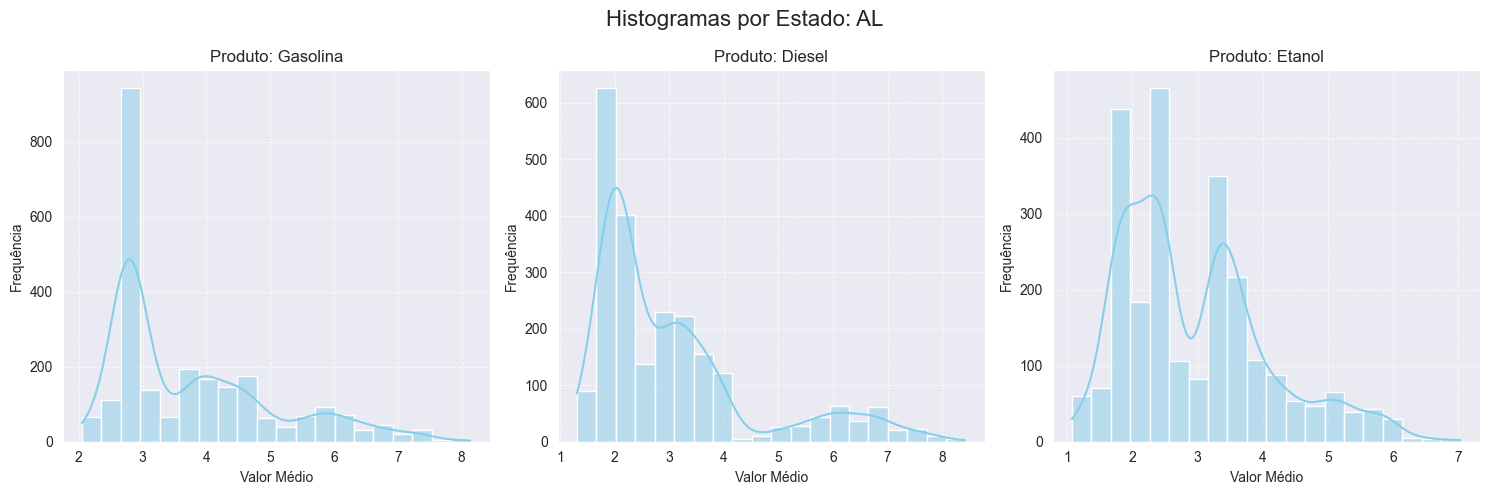

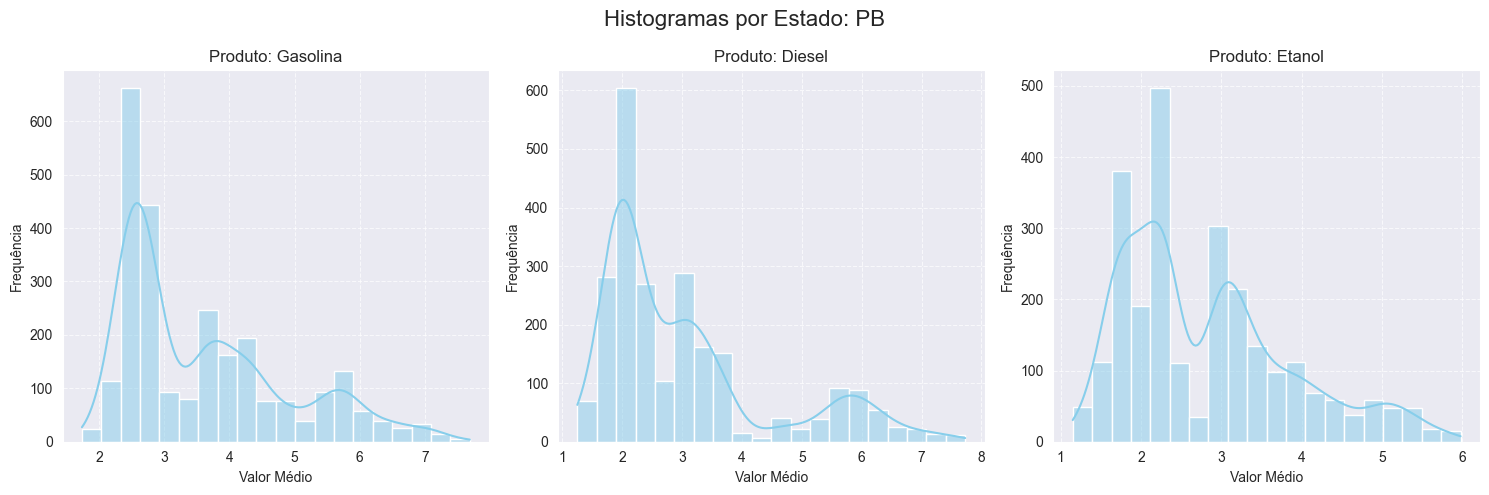

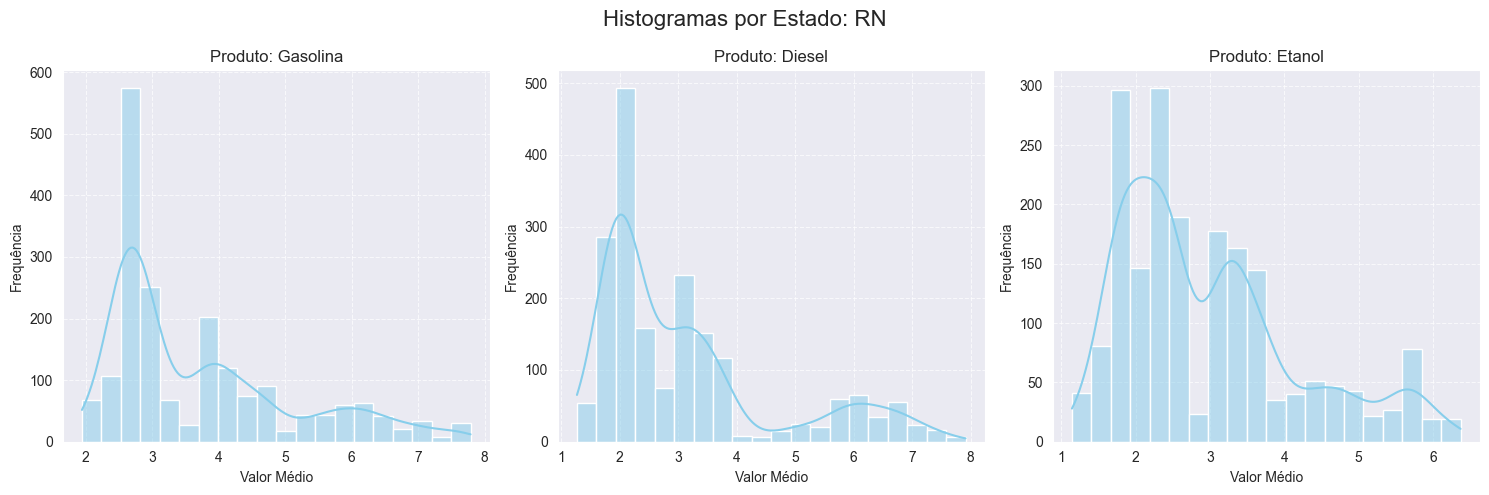

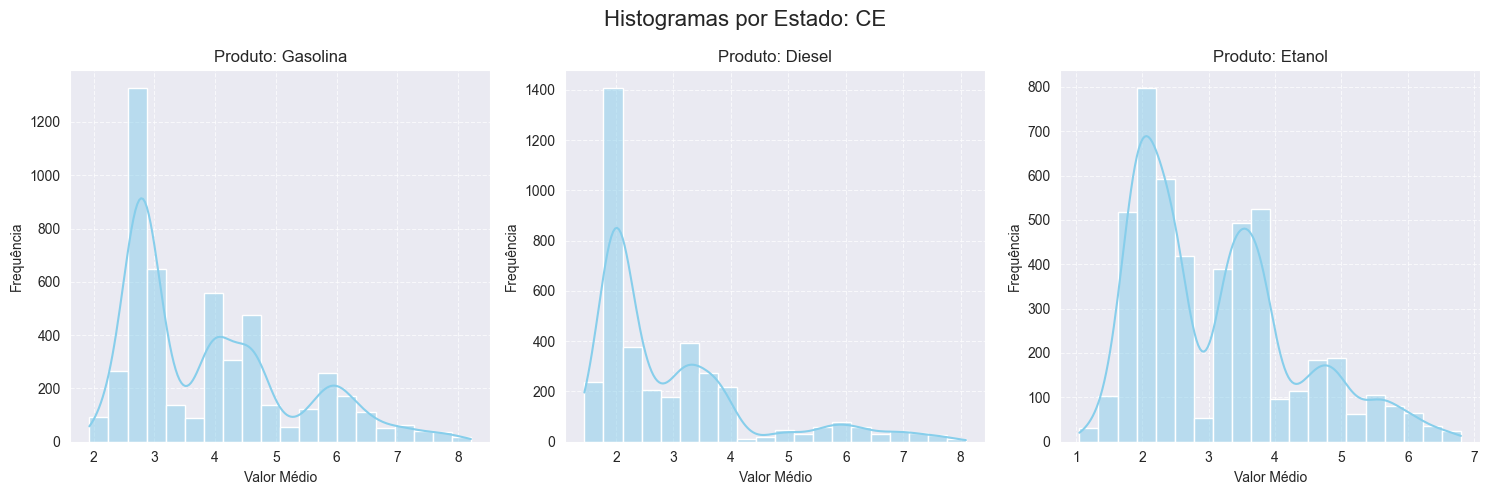

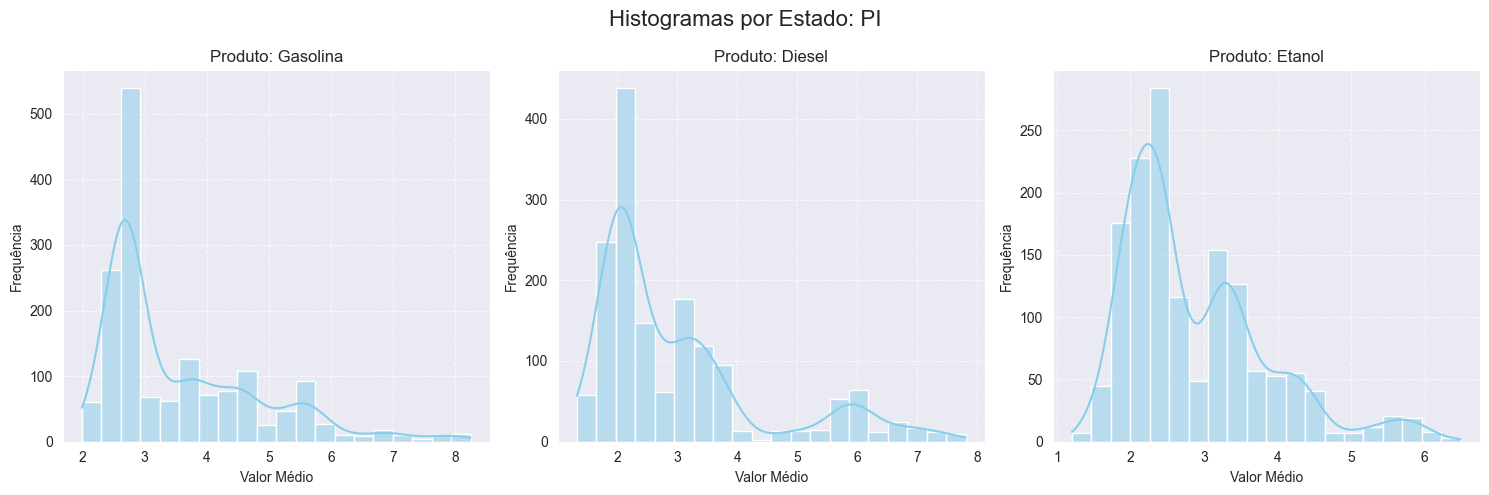

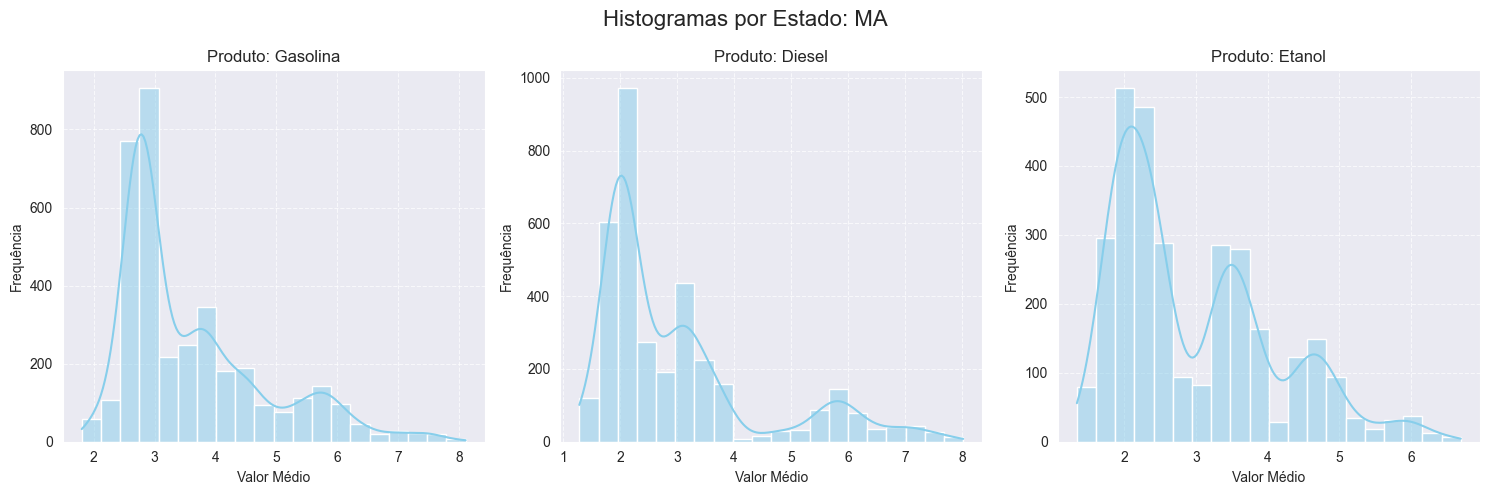

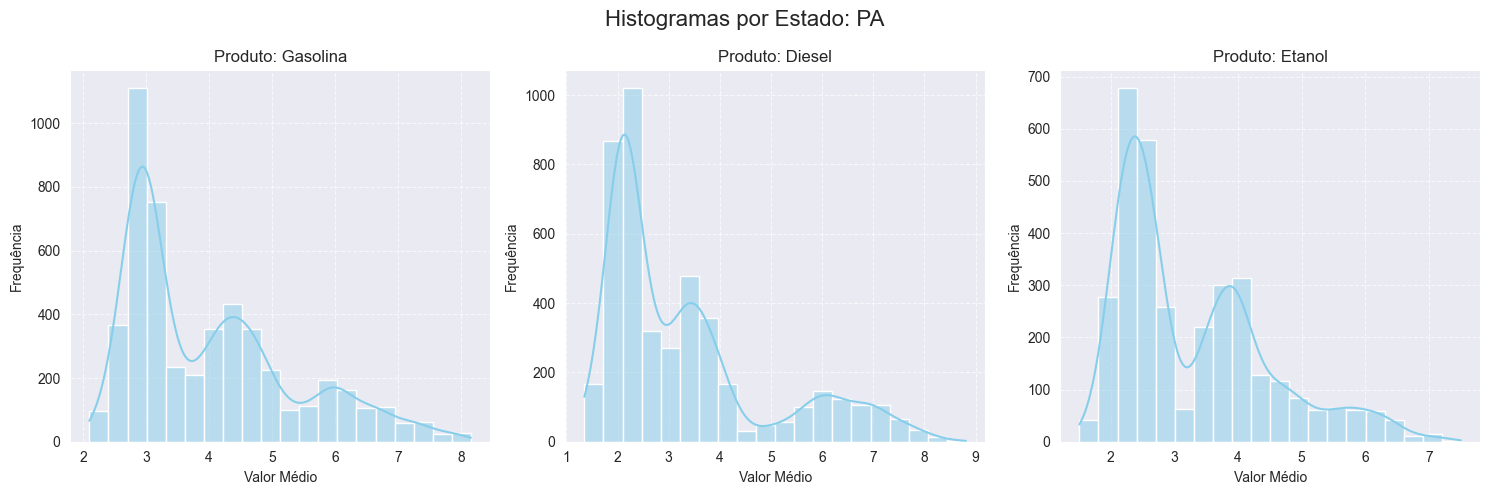

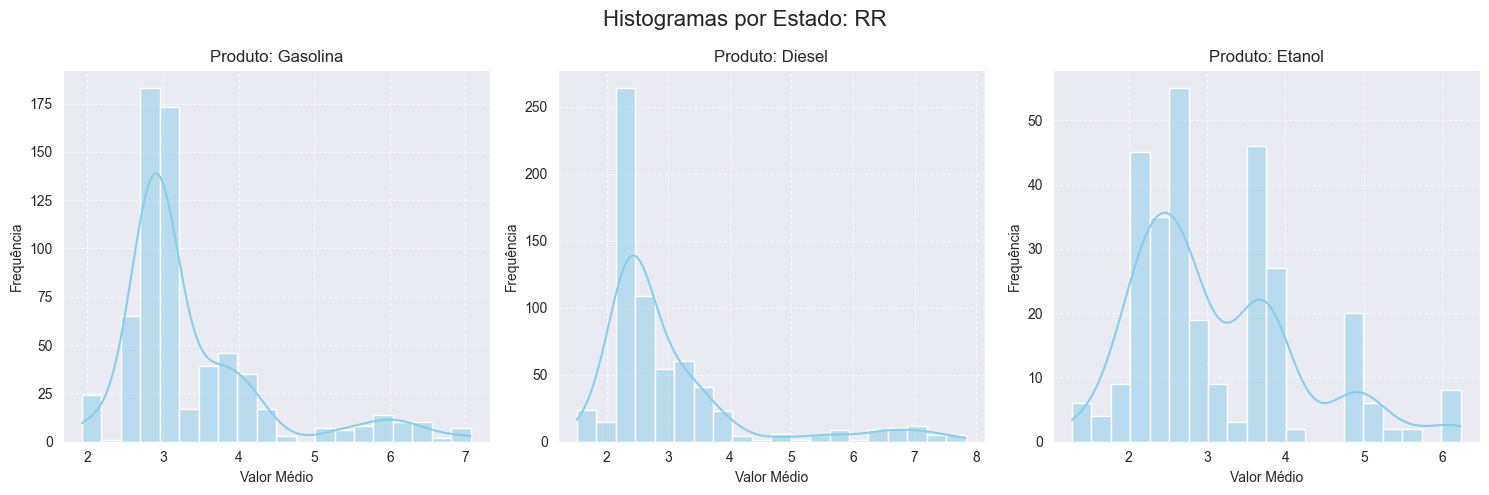

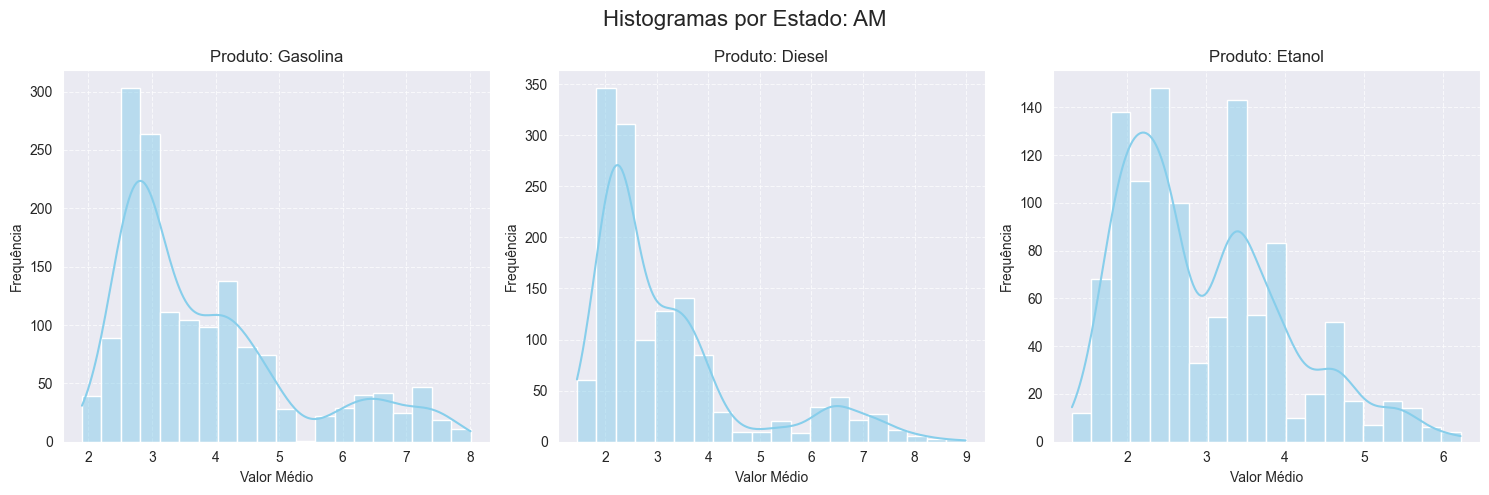

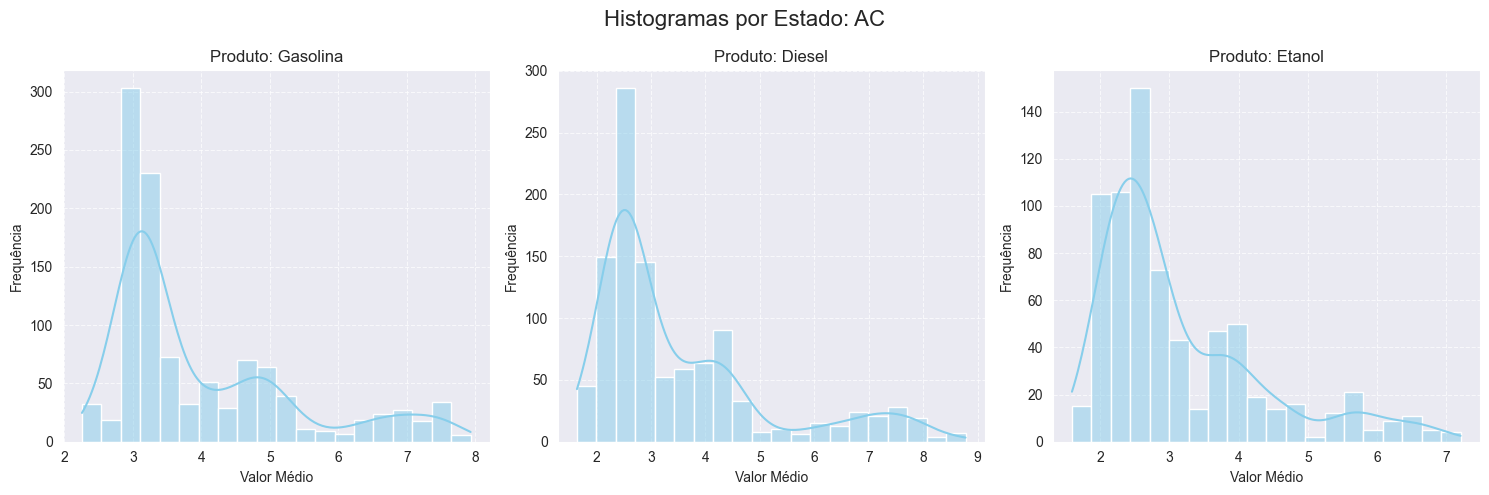

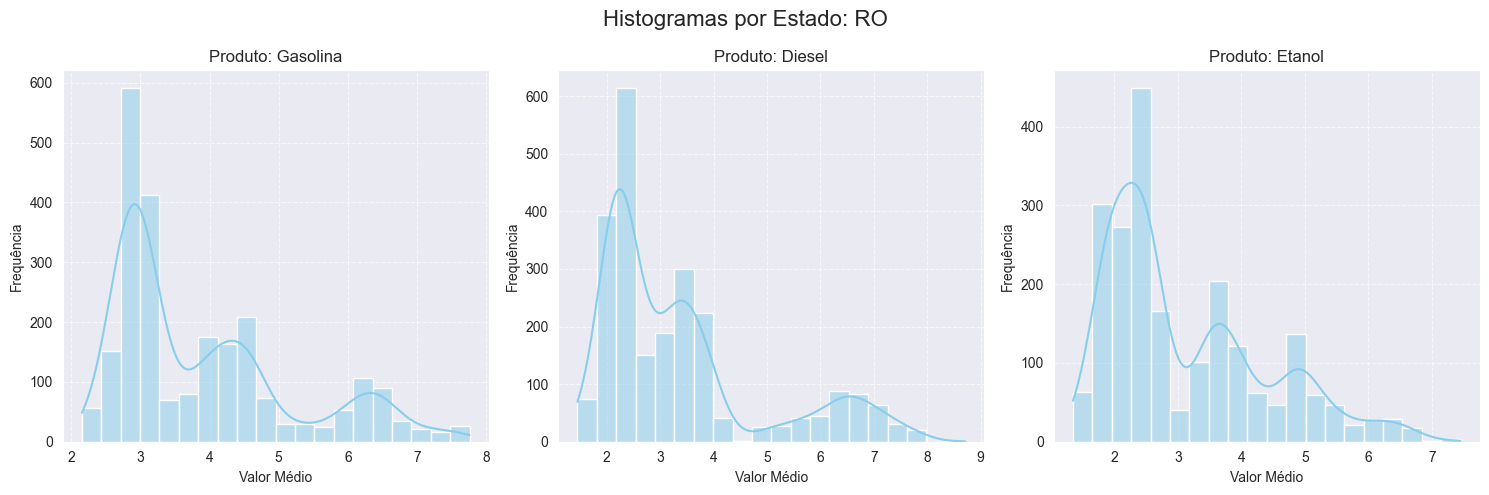

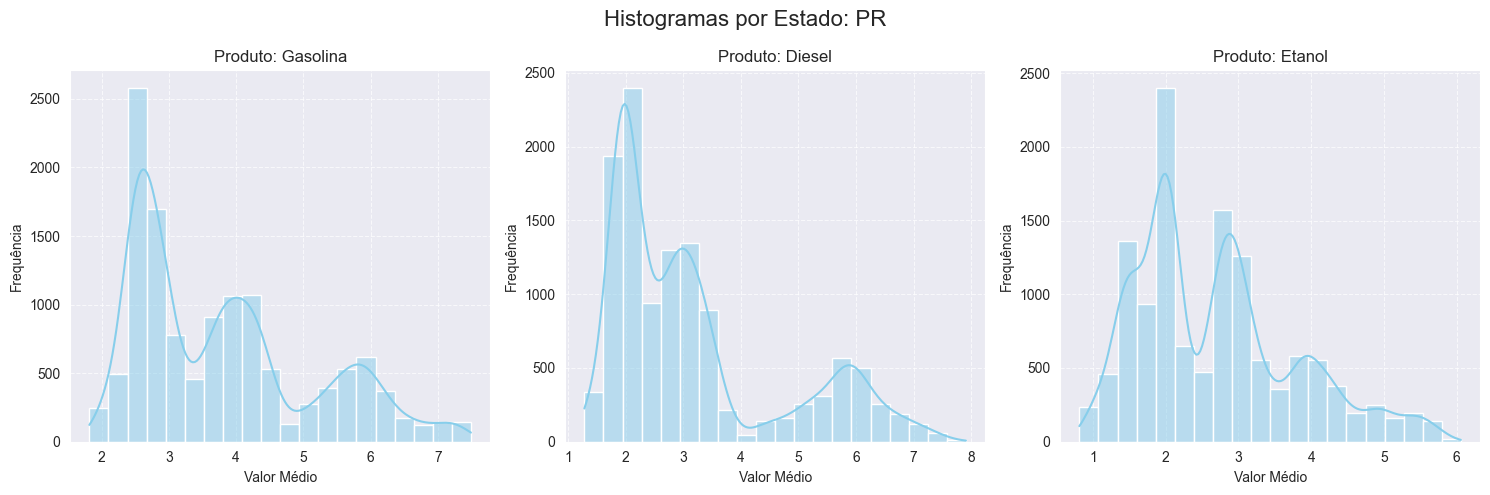

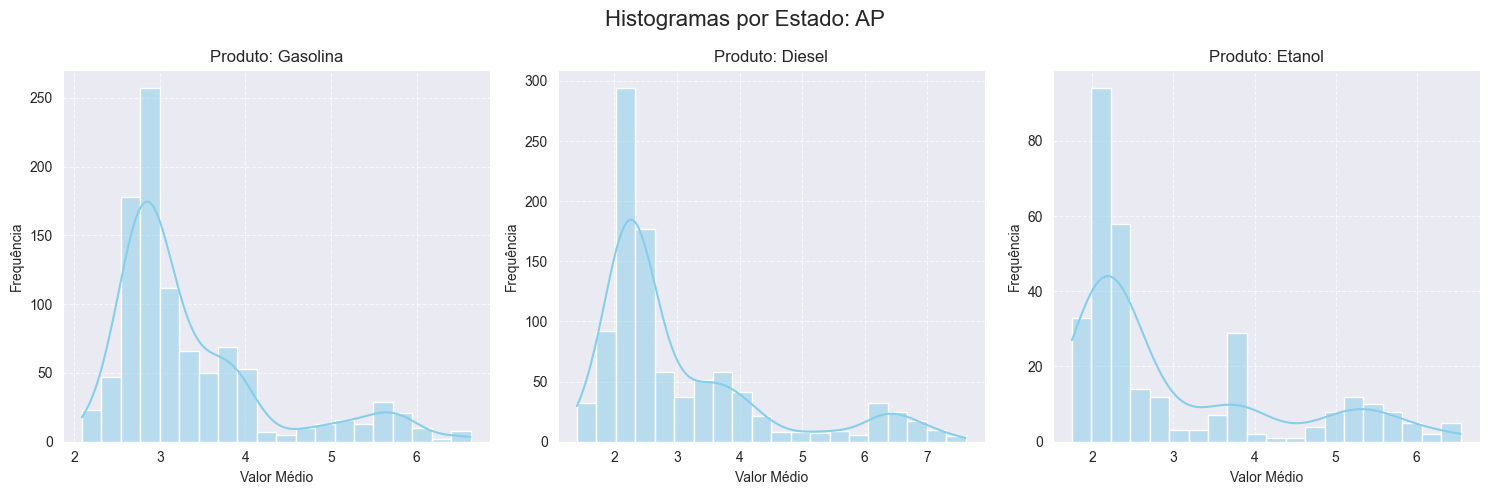

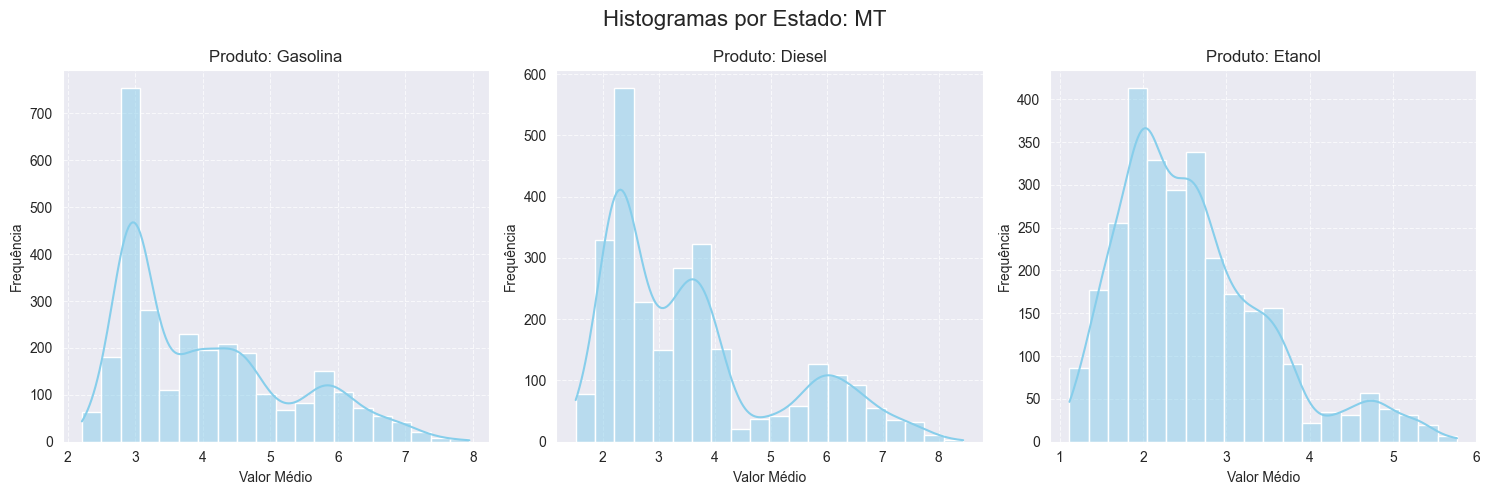

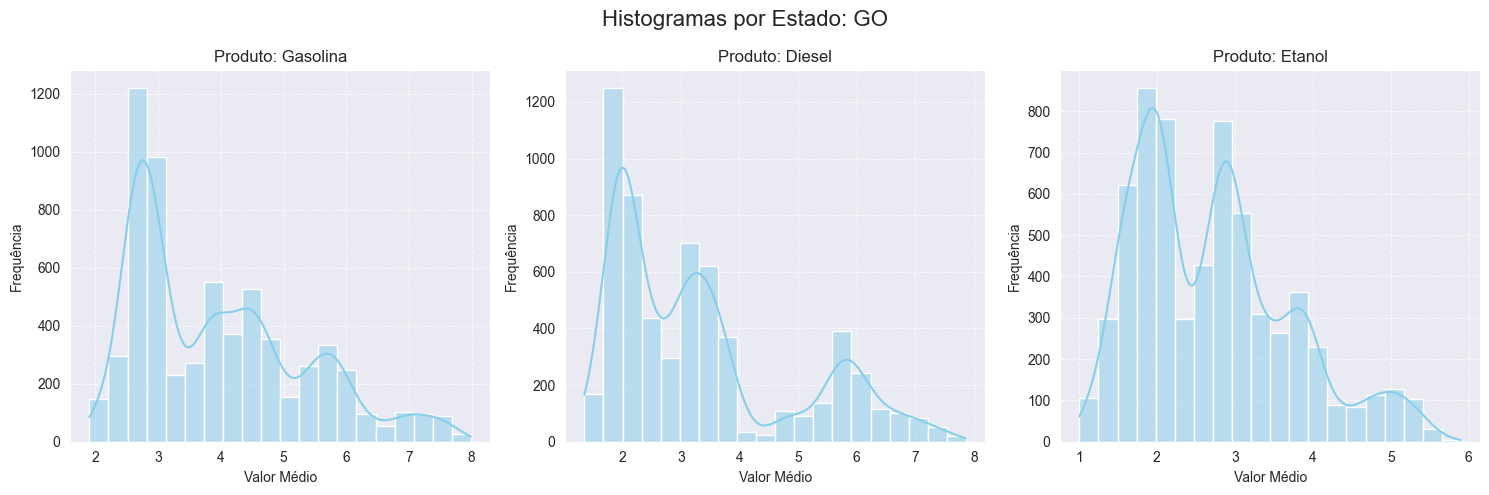

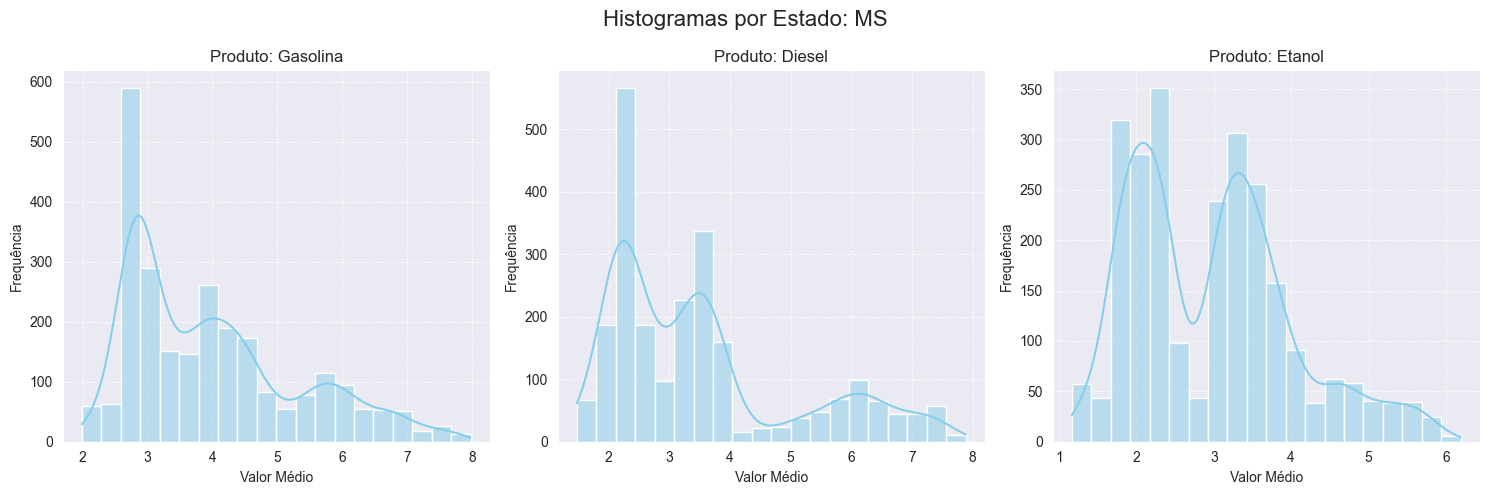

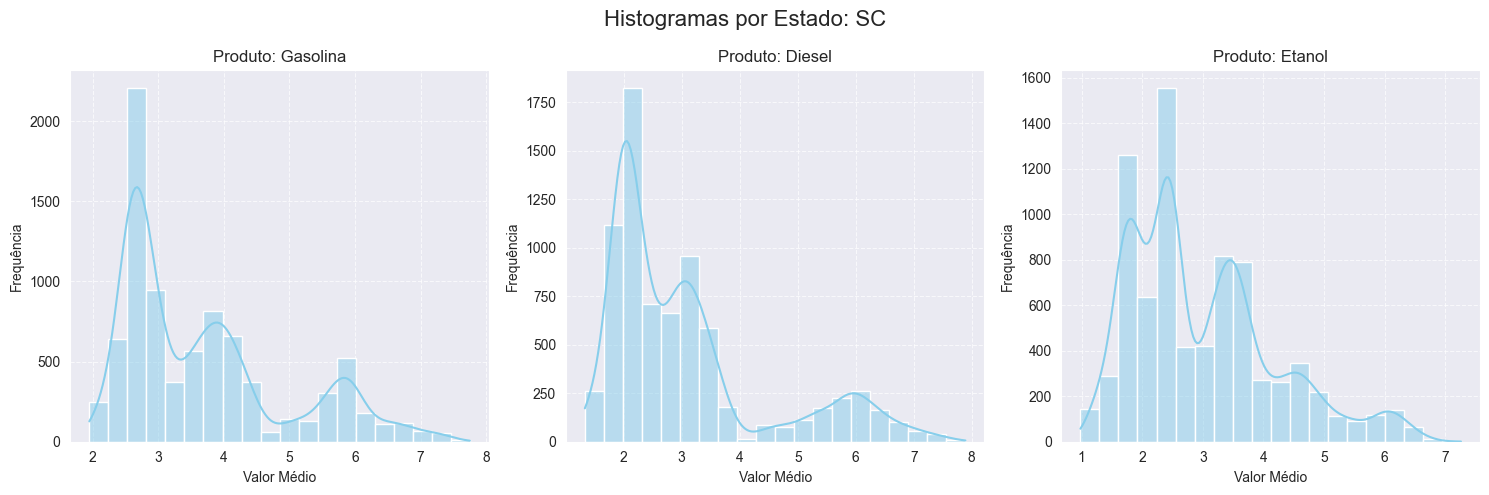

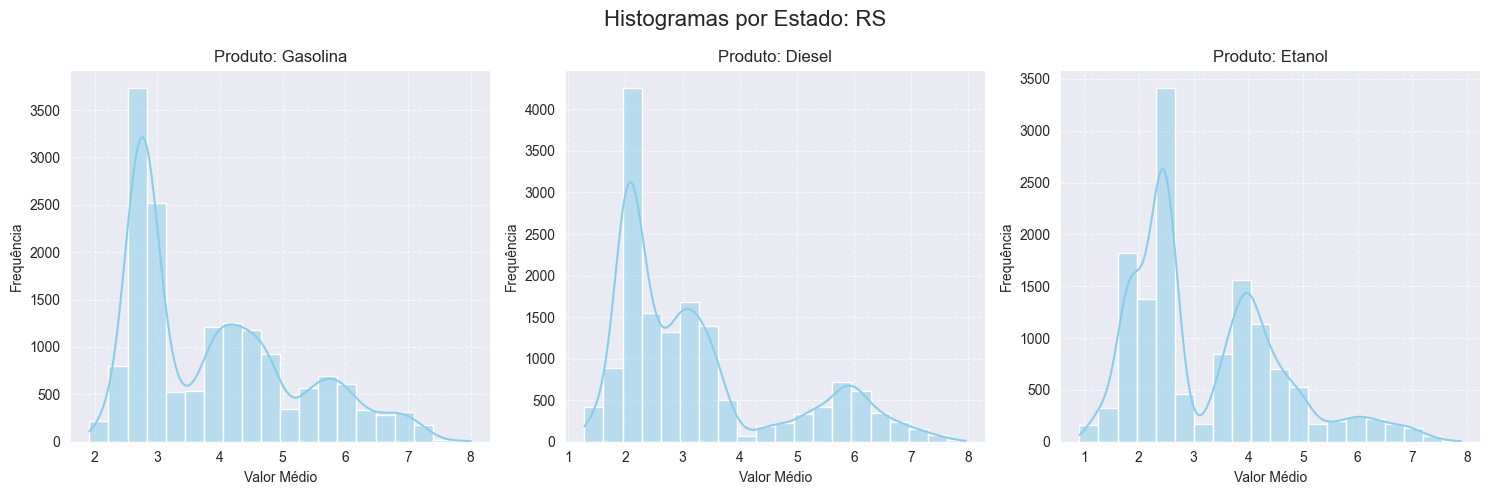

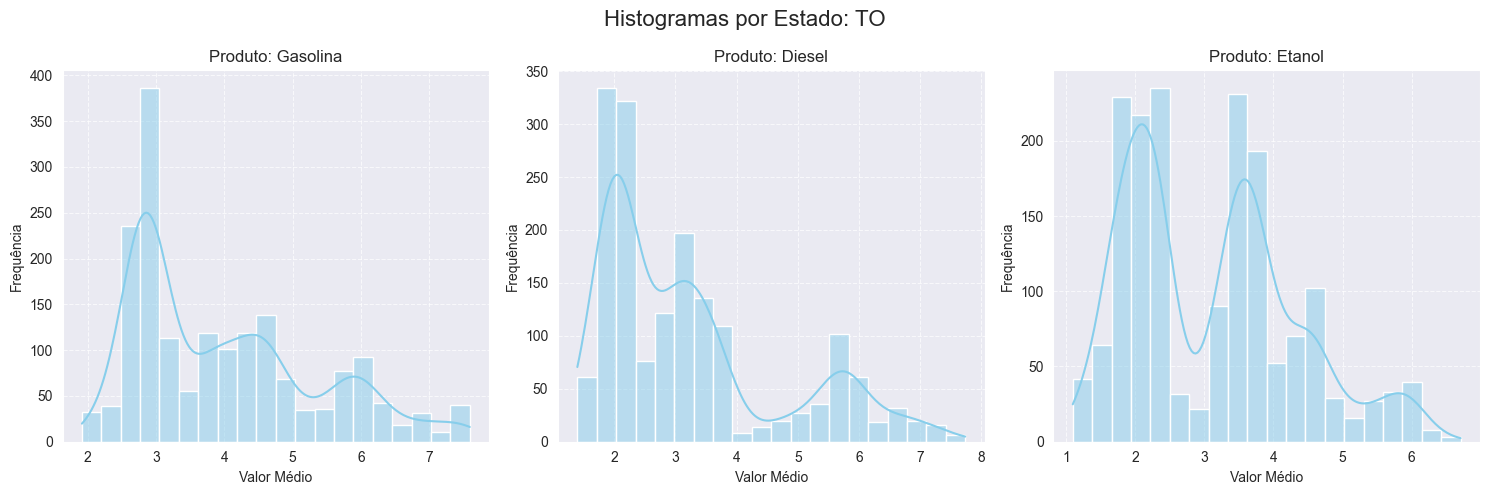

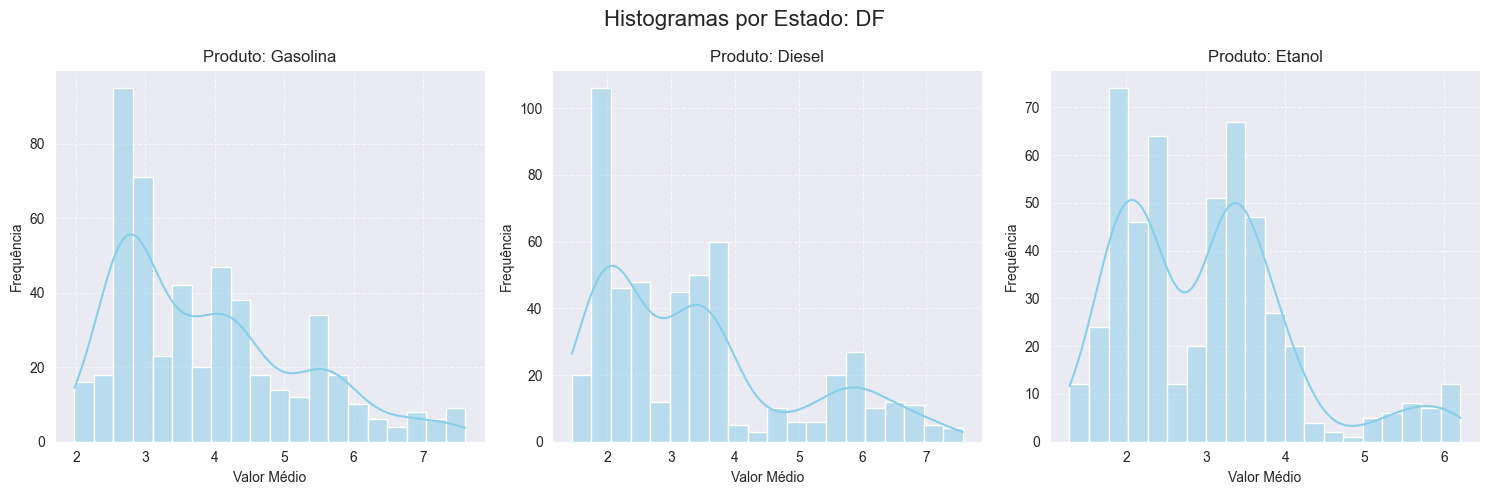

In [10]:
products = data['produto'].unique()
states = data['sigla_uf'].unique()

for i, uf in enumerate(states):
    fig, axes = plt.subplots(nrows=1, ncols=len(products), figsize=(15, 5))  # Adjust figsize as needed
    fig.suptitle(f'Histogramas por Estado: {uf}', fontsize=16)

    for j, produto in enumerate(products):
        filtered_data = data[(data['produto'] == produto) & (data['sigla_uf'] == uf)]

        sns.histplot(filtered_data['avg_preco_venda'], kde=True, ax=axes[j], color='skyblue', bins=20)
        axes[j].set_title(f'Produto: {produto}', fontsize=12)
        axes[j].set_xlabel('Valor Médio', fontsize=10)
        axes[j].set_ylabel('Frequência', fontsize=10)
        axes[j].grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

## Plots Valor Médio de Cada Produto por Unidade Federativa

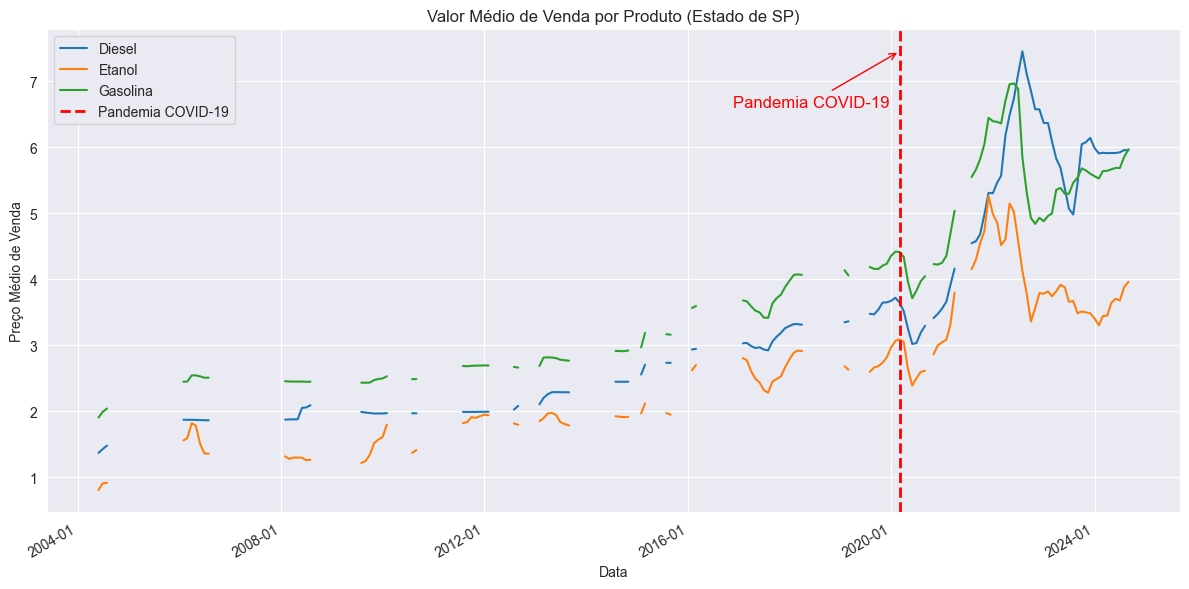

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

data = pd.read_parquet("../data/oil_and_gas_dataset.parquet")

data['data'] = pd.to_datetime(data['data'])
data = data.set_index('data')

data_sp = data[data['sigla_uf'] == 'SP']

data_resampled = (
    data_sp.groupby('produto')[['avg_preco_venda']]
    .resample('M')
    .mean()
    .reset_index()
)


fig, ax = plt.subplots(figsize=(12, 6))


for produto in data_resampled['produto'].unique():
    produto_data = data_resampled[data_resampled['produto'] == produto]
    ax.plot(produto_data['data'], produto_data['avg_preco_venda'], label=produto)


ax.axvline(pd.to_datetime('2020-03-01'), color='red', linestyle='dashed', linewidth=2, label='Pandemia COVID-19')

ax.annotate('Pandemia COVID-19', xy=(pd.to_datetime('2020-03-01'), data_resampled['avg_preco_venda'].max()),
             xytext=(-120, -40),  # Ajuste o valor de xytext para posicionar à esquerda
             textcoords='offset points', fontsize=12, color='red',
             arrowprops=dict(arrowstyle='->', color='red'))

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
fig.autofmt_xdate()

ax.set_title('Valor Médio de Venda por Produto (Estado de SP)')
ax.set_ylabel('Preço Médio de Venda')
ax.set_xlabel('Data')
ax.legend(loc='upper left')

plt.tight_layout()

plt.savefig('grafico_sp.png', dpi=300)

plt.show()

## Matriz de Correlações

A matriz de correlações é uma ferramenta essencial para compreender como as variáveis se relacionam, permitindo identificar a influência mútua entre elas. No nosso contexto, onde as relações costumam ser não estritamente lineares e as distribuições dos dados não seguem uma normalidade, a correlação de Spearman revela-se a métrica mais apropriada em comparação com a correlação de Pearson. Isso ocorre porque a correlação de Spearman capta de forma mais eficaz as associações monotônicas, independentemente da linearidade.

Além disso, é crucial que o modelo desenvolvido não inclua variáveis que apresentem correlações muito elevadas (próximas de 1 ou -1), pois isso pode levar à multicolinearidade. Essa condição compromete tanto a estabilidade quanto a interpretabilidade do modelo, prejudicando sua capacidade de generalização. Quando as features possuem uma correlação excessiva com a variável dependente, o modelo tende a se restringir a operações lineares simples, sem agregar valor preditivo real.


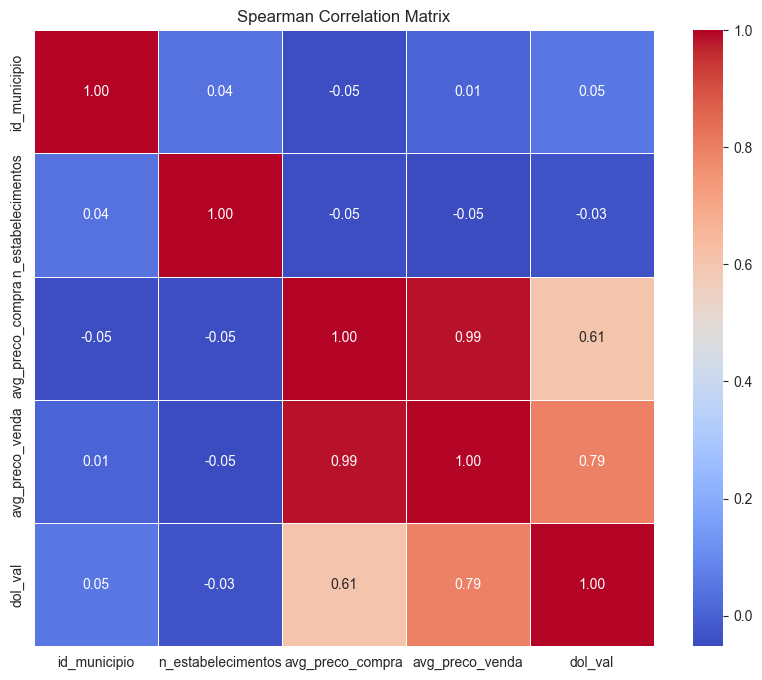

In [12]:
df = pd.read_csv("data_dol_val.csv", index_col=0)
num_cols = df.select_dtypes(include=[np.number]).columns
spearman_corr = df[num_cols].corr(method="spearman")

plt.figure(figsize=(10, 8))
sns.heatmap(spearman_corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Spearman Correlation Matrix")
plt.show()

In [13]:
spearman_corr, p_value = stats.spearmanr(df["avg_preco_venda"], df["dol_val"])
print(f"Spearman Correlation: {spearman_corr:.2f}, p-value: {p_value:.5f}")

Spearman Correlation: 0.79, p-value: 0.00000


In [14]:
df_cleaned = df.dropna(subset=["avg_preco_venda", "avg_preco_compra"])
shifted_compra = df_cleaned["avg_preco_compra"].shift(1).dropna()
avg_venda = df_cleaned["avg_preco_venda"].iloc[1:]

spearman_corr, p_value = stats.spearmanr(avg_venda, shifted_compra)
print(f"Spearman Correlation: {spearman_corr:.2f}, p-value: {p_value:.5f}")

Spearman Correlation: 0.70, p-value: 0.00000


## Análise dos Preços Finais para Etanol e Gasolina

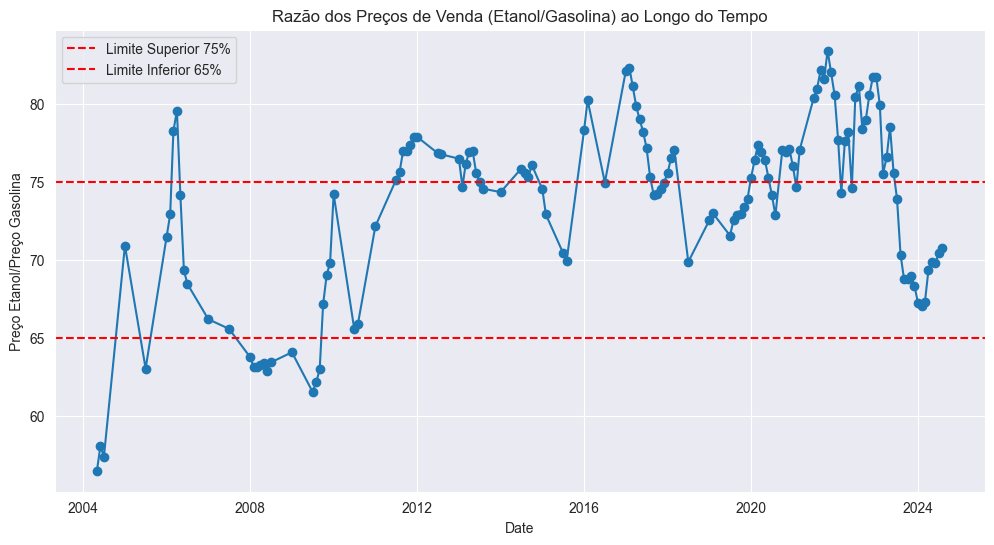

In [15]:
file_path = "../data/data_dol_val.csv"
df = pd.read_csv(file_path)

df['data'] = pd.to_datetime(df['data'])

df_grouped = df.groupby(['data', 'produto'])['avg_preco_venda'].mean().unstack()

df_grouped['ratio_percent'] = ((df_grouped['Etanol']) / df_grouped['Gasolina']) * 100

plt.figure(figsize=(12, 6))
plt.plot(df_grouped.index, df_grouped['ratio_percent'], marker='o', linestyle='-')
plt.axhline(y=75, color='red', linestyle='dashed', label='Limite Superior 75%')
plt.axhline(y=65, color='red', linestyle='dashed', label='Limite Inferior 65%')
plt.xlabel("Date")
plt.ylabel("Preço Etanol/Preço Gasolina")
plt.title("Razão dos Preços de Venda (Etanol/Gasolina) ao Longo do Tempo")
plt.legend()
plt.grid(True)
plt.show()


In [16]:
dentro_da_margem = df_grouped[(df_grouped['ratio_percent'] >= 65) & (df_grouped['ratio_percent'] <= 75)]
total_dentro_da_margem = len(dentro_da_margem)
total_valores = len(df_grouped)
porcentagem_dentro_da_margem = (total_dentro_da_margem / total_valores) * 100

print(f"porcentagem de valores dentro da margem: {round(porcentagem_dentro_da_margem, 2)}%")

porcentagem de valores dentro da margem: 40.88%


## Análise de Tendência para Média dos Valores dos Combustíveis.

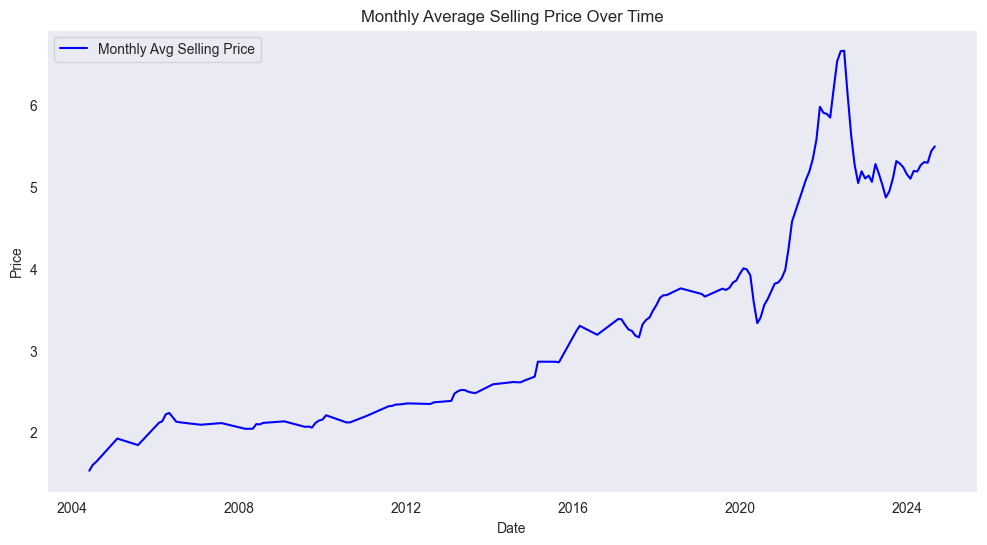

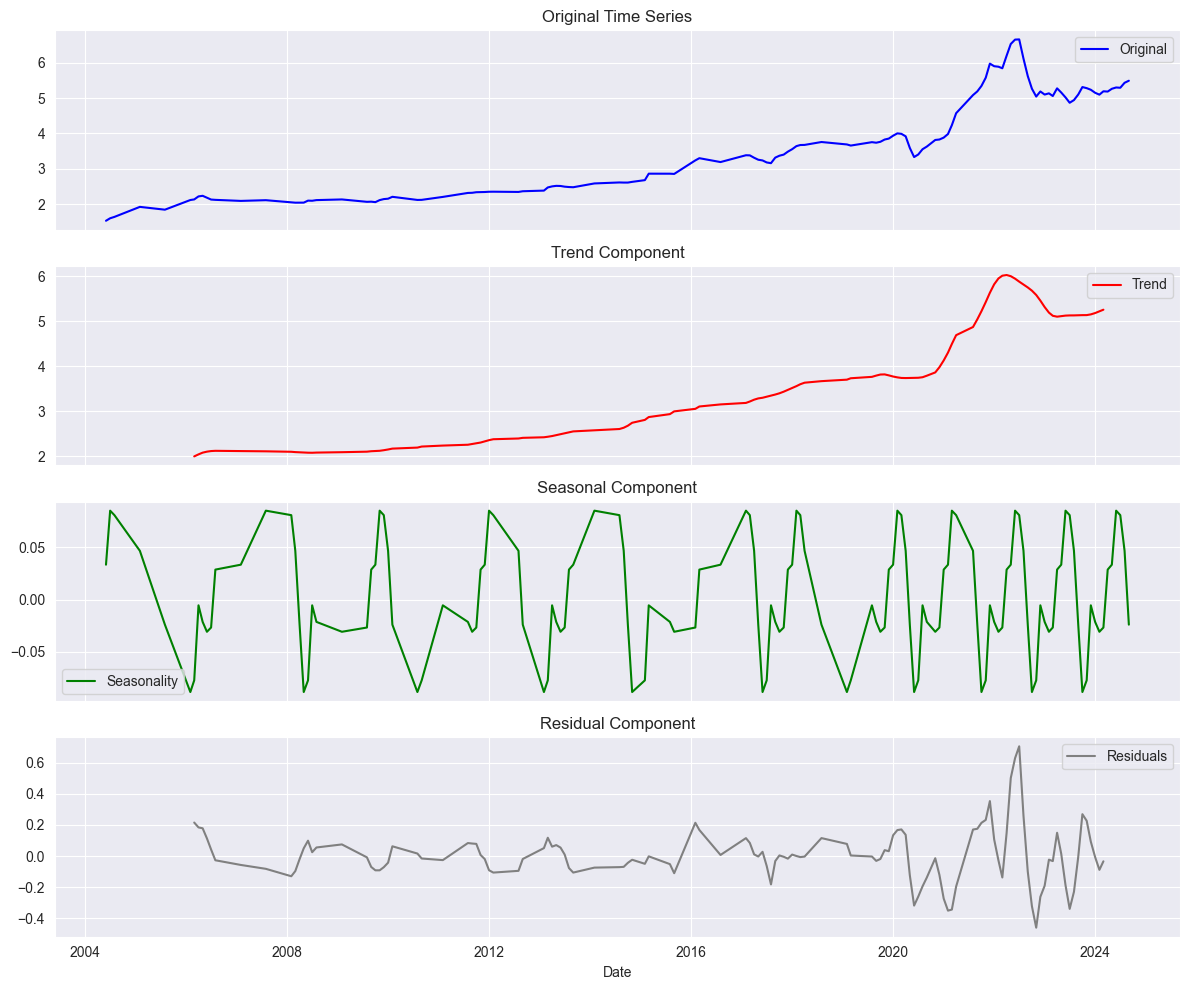

In [17]:
df = pd.read_csv("data_dol_val.csv")  # Ajuste o nome do arquivo conforme necessário

df['data'] = pd.to_datetime(df['data'])
df = df.set_index('data')

ts = df['avg_preco_venda'].resample('M').mean()
ts = ts.asfreq('M')
ts_clean = ts.dropna()

plt.figure(figsize=(12, 6))
plt.plot(ts_clean, label='Monthly Avg Selling Price', color='blue')
plt.title("Monthly Average Selling Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()

decomposition = seasonal_decompose(ts_clean, model='additive', period=12)

fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

axes[0].plot(ts_clean, label='Original', color='blue')
axes[0].set_title("Original Time Series")
axes[0].legend()

axes[1].plot(decomposition.trend, label='Trend', color='red')
axes[1].set_title("Trend Component")
axes[1].legend()

axes[2].plot(decomposition.seasonal, label='Seasonality', color='green')
axes[2].set_title("Seasonal Component")
axes[2].legend()

axes[3].plot(decomposition.resid, label='Residuals', color='gray')
axes[3].set_title("Residual Component")
axes[3].legend()

plt.xlabel("Date")
plt.tight_layout()
plt.show()

## Análise de Tendência para Valores de Vendas dos Produtos Separados

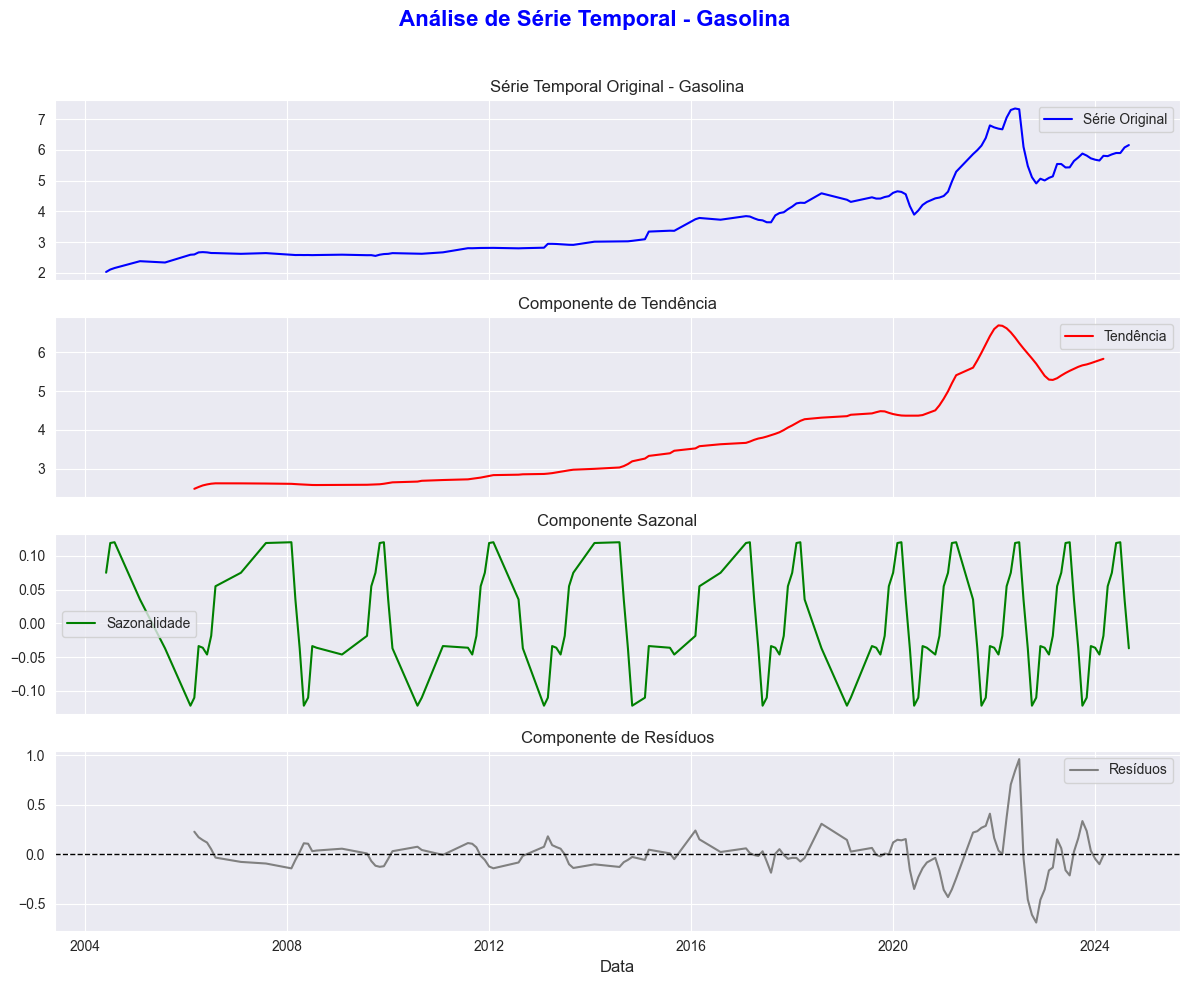

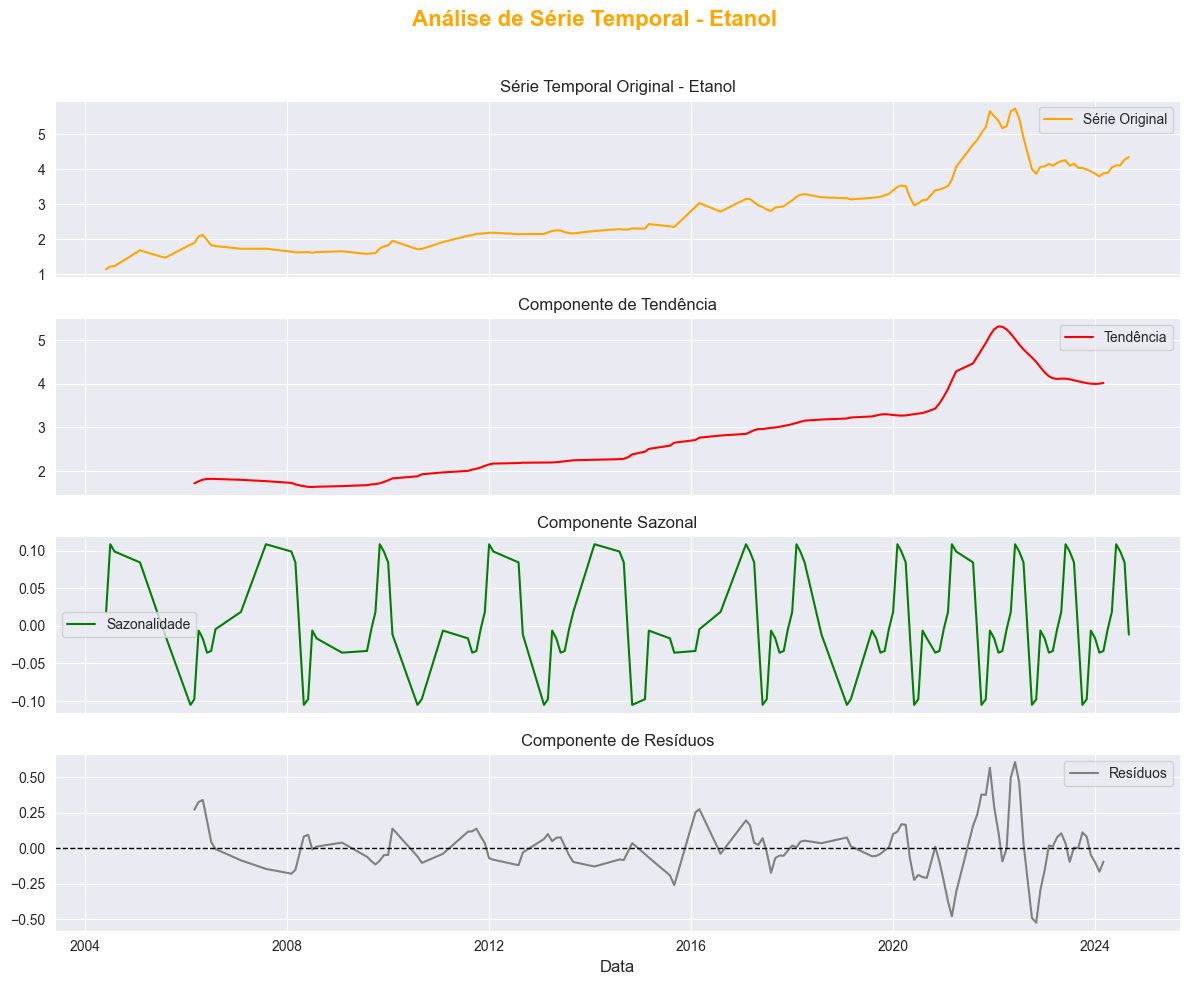

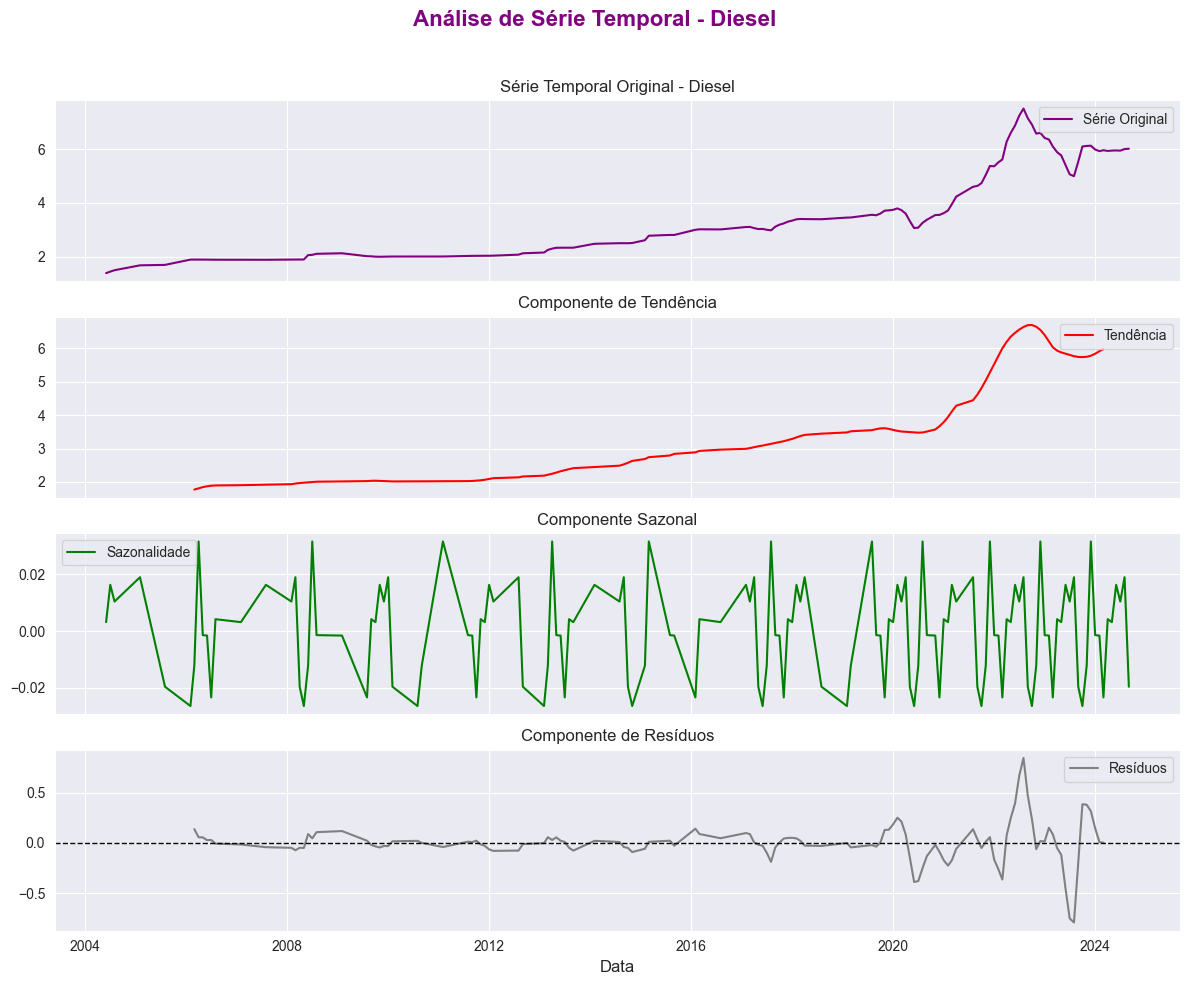

In [18]:
df = pd.read_csv("data_dol_val.csv")
df['data'] = pd.to_datetime(df['data'])
df = df.set_index('data')
produtos = ["Gasolina", "Etanol", "Diesel"]


cores = {"Gasolina": "blue", "Etanol": "orange", "Diesel": "purple"}

for produto in produtos:
    df_produto = df[df['produto'] == produto]
    ts = df_produto['avg_preco_venda'].resample('M').mean()
    ts = ts.asfreq('M')
    ts_clean = ts.dropna()

    decomposicao = seasonal_decompose(ts_clean, model='additive', period=12)

    fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

    fig.suptitle(f"Análise de Série Temporal - {produto}", fontsize=16, fontweight='bold', color=cores[produto])

    axes[0].plot(ts_clean, label='Série Original', color=cores[produto])
    axes[0].set_title(f"Série Temporal Original - {produto}", fontsize=12)
    axes[0].legend()
    axes[0].grid(True)

    axes[1].plot(decomposicao.trend, label='Tendência', color='red')
    axes[1].set_title("Componente de Tendência", fontsize=12)
    axes[1].legend()
    axes[1].grid(True)

    axes[2].plot(decomposicao.seasonal, label='Sazonalidade', color='green')
    axes[2].set_title("Componente Sazonal", fontsize=12)
    axes[2].legend()
    axes[2].grid(True)

    axes[3].plot(decomposicao.resid, label='Resíduos', color='gray')
    axes[3].axhline(0, color='black', linestyle='dashed', linewidth=1)  # Linha horizontal para referência
    axes[3].set_title("Componente de Resíduos", fontsize=12)
    axes[3].legend()
    axes[3].grid(True)

    plt.xlabel("Data", fontsize=12)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

## Conclusão e Considerações para Construção do Modelo

- **Plot Valor Médio de Venda – Cotação USD**
  - Evidencia a provável correlação positiva entre a cotação do dólar e o valor médio de venda.
  - Indica que a variável `dol_val` é promissora para uso no modelo preditivo.
  - Mostra o impacto da pandemia:
    - Inicialmente, queda nos preços devido à redução da demanda.
    - Posteriormente, a produção cai e o valor do dólar sobe, impactando os preços em todos os estados.

- **Histogramas do Valor Médio de Venda dos Produtos**
  - Demonstram que a distribuição dos valores de venda não é normal.
  - Justificam o uso da correlação de Spearman, que não depende da normalidade dos dados, em vez de Pearson.

- **Plots do Valor Médio de Cada Produto por Unidade Federativa**
  - Permitem a comparação:
    - Entre produtos diferentes dentro do mesmo estado.
    - Do mesmo produto em estados distintos.

- **Matriz de Correlações**
  - Utiliza a correlação de Spearman para captar relações não lineares.
  - Apresenta pontos importantes:
    1. Correlação próxima de 1 entre `avg_preco_venda` e `avg_preco_compra`, sugerindo um possível *data leakage* e indicando que o uso de `avg_preco_compra` pode ser inadequado.
    2. 61% de correlação entre `avg_preco_compra` e `dol_val`, apontando para colinearidade entre essas variáveis.
    3. 79% de correlação entre o *target* (por exemplo, `avg_preco_venda`) e `dol_val`, reforçando que `dol_val` é uma boa escolha para feature, devido à sua disponibilidade e relevância.

- **Análise dos Preços Finais para Etanol e Gasolina**
  - De acordo com a literatura:
    - O calor específico da gasolina é de 25% a 35% maior que o do etanol.
    - Para que o etanol seja vantajoso, seu preço deveria estar entre 65% e 75% do valor da gasolina.
  - Os dados indicam que apenas 40,88% do tempo o preço do etanol está nessa faixa.
  - Considerando a alta demanda por veículos flex, há potencial para um maior consumo de etanol, o que pode gerar mais receita para os cofres públicos.

- **Análise de Tendência para Valores de Vendas dos Produtos**
  - **Componente de Tendência**
    - Todos os produtos mostram uma elevação gradual dos preços ao longo do tempo, compatível com a inflação anual no Brasil.
    - Durante eventos como a pandemia, há uma queda temporária, seguida pela retomada da tendência de alta.
  - **Componente de Sazonalidade**
    - Existe um componente sazonal quase anual de aproximadamente 2 centavos de real, que é irrisório no longo prazo.
  - **Componente Residual**
    - O residual se mantém em torno de zero, sem seguir um padrão definido.
    - Oscilações mais acentuadas podem sinalizar eventos pontuais (como a pandemia), que elevam o valor do dólar e impactam os preços dos produtos.


# Desenvolvimento do Modelo Preditivo
## Modelo Baseline



In [ ]:
warnings.filterwarnings("ignore")

df = pd.read_csv("../data/data_dol_val.csv")
df['data'] = pd.to_datetime(df['data'])
df = df.set_index('data')

produtos = ["Gasolina", "Etanol", "Diesel"]
resultados = {}

for produto in produtos:
    print(f"\nModelando para {produto}...\n")

    df_produto = df[df['produto'] == produto]
    ts = df_produto['avg_preco_venda'].resample('M').mean()
    ts = ts.asfreq('M')
    ts_clean = ts.dropna()

    dol_val = df_produto['dol_val'].resample('M').mean()
    dol_val = dol_val.asfreq('M')
    dol_val_clean = dol_val.dropna()

    dol_val = dol_val_clean.reindex(ts_clean.index).fillna(method="ffill")

    resultado_adf = adfuller(ts_clean)
    print(f"Teste de Dickey-Fuller para {produto}:")
    print(f" - Estatística ADF: {resultado_adf[0]:.4f}")
    print(f" - p-valor: {resultado_adf[1]:.4f}")
    print(" - Série considerada estacionária" if resultado_adf[1] < 0.05 else " - Série não estacionária, pode precisar de diferenciação")

    ts_diff = ts_clean.diff().dropna() if resultado_adf[1] > 0.05 else ts_clean

    train_end = '2022-05-31'
    ts_train = ts_clean.loc[:train_end]
    ts_test = ts_clean.loc['2022-06-01':'2024-05-31']

    dol_train = dol_val.loc[:train_end]
    dol_test = dol_val.loc['2022-06-01':'2024-05-31']

    print(f"Período de treino: {ts_train.index.min().date()} a {train_end}")
    print(f"Período de teste: {train_end} a {ts_test.index.max().date()}")

    p = d = q = range(0, 3)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in itertools.product(range(0, 3), range(0, 3), range(0, 3))]

    lowest_aic = np.inf
    best_pdq = None
    best_seasonal_pdq = None
    best_model = None

    print("\nIniciando busca de hiperparâmetros para SARIMAX...\n")
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = SARIMAX(ts_train, order=param, seasonal_order=param_seasonal,
                              exog=dol_train, enforce_stationarity=False, enforce_invertibility=False)
                results = mod.fit(disp=False)
                if results.aic < lowest_aic:
                    lowest_aic = results.aic
                    best_pdq = param
                    best_seasonal_pdq = param_seasonal
                    best_model = results
            except:
                continue

    print("\nMelhor modelo encontrado:")
    print(f"SARIMA{best_pdq}x{best_seasonal_pdq} - AIC: {lowest_aic:.2f}")

    print("\nParâmetros do modelo:")
    print(best_model.summary())

    best_model.plot_diagnostics(figsize=(15, 12))
    plt.suptitle(f"Diagnóstico do Modelo SARIMAX - {produto}", fontsize=16, fontweight="bold")
    plt.show()

    print("\nFazendo previsões para o período de teste...\n")

    rolling_forecasts = []
    history = ts_train.copy()
    dol_history = dol_train.copy()

    for t in ts_test.index:
        model = SARIMAX(history, order=best_pdq, seasonal_order=best_seasonal_pdq,
                        exog=dol_history, enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False)
        forecast = model_fit.get_forecast(steps=1, exog=dol_test.loc[[t]])
        yhat = forecast.predicted_mean.iloc[0]
        rolling_forecasts.append(yhat)
        history = pd.concat([history, ts_test.loc[[t]]])
        dol_history = pd.concat([dol_history, dol_test.loc[[t]]])

    rolling_forecasts = pd.Series(rolling_forecasts, index=ts_test.index)

    rmse = np.sqrt(mean_squared_error(ts_test, rolling_forecasts))
    mae = mean_absolute_error(ts_test, rolling_forecasts)
    mape = np.mean(np.abs((ts_test - rolling_forecasts) / ts_test)) * 100

    print("\nMétricas de erro:")
    print(f" - RMSE: {rmse:.2f}")
    print(f" - MAE: {mae:.2f}")
    print(f" - MAPE: {mape:.2f}%")

    plt.figure(figsize=(10, 5))
    plt.plot(ts_train, label='Treinamento')
    plt.plot(ts_test, label='Valor Real (Teste)', marker='o')
    plt.plot(rolling_forecasts.index, rolling_forecasts, label='Previsão Rolling', color='red', marker='o')
    plt.title(f"Previsão Rolling Forecast para {produto} (com dol_val)")
    plt.xlabel("Data")
    plt.ylabel("Preço Médio de Venda")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Armazena os resultados desejados para o joblib
    resultados[produto] = {
        "metricas": {
            "rmse": rmse,
            "mae": mae,
            "mape": mape
        },
        "best_params": {
            "order": best_pdq,
            "seasonal_order": best_seasonal_pdq,
            "aic": lowest_aic
        },
        "best_model": best_model,
        "previsoes": rolling_forecasts
    }

print("\nResumo Final dos Modelos por Produto:")
for produto, res in resultados.items():
    print(f"\n{produto}:")
    print(f" - RMSE: {res['metricas']['rmse']:.2f}")
    print(f" - MAE: {res['metricas']['mae']:.2f}")
    print(f" - MAPE: {res['metricas']['mape']:.2f}%")
    print(f" - Melhor AIC: {res['best_params']['aic']:.2f}")

# Salva o dicionário de modelos em um arquivo joblib
joblib.dump(resultados, "modelos_sarimax/modelos_sarimax_baseline.joblib")
print("\nModelos salvos em 'modelos_sarimax/modelos_sarimax_baseline.joblib'")



Modelando para Gasolina...

Teste de Dickey-Fuller para Gasolina:
 - Estatística ADF: -1.1033
 - p-valor: 0.7138
 - Série não estacionária, pode precisar de diferenciação
Período de treino: 2004-05-31 a 2022-05-31
Período de teste: 2022-05-31 a 2024-05-31

Iniciando busca de hiperparâmetros para SARIMAX...



## SARIMAX Model + Variável dol_val


Modelando para Gasolina...

Teste de Dickey-Fuller para Gasolina:
 - Estatística ADF: -1.1033
 - p-valor: 0.7138
 - Série não estacionária, pode precisar de diferenciação
Período de treino: 2004-05-31 a 2022-05-31
Período de teste: 2022-06-30 a 2024-05-31

Iniciando busca de hiperparâmetros para SARIMAX...


Melhor modelo encontrado:
SARIMA(2, 0, 0)x(0, 0, 0, 12) - AIC: -143.03

Parâmetros do modelo:
                               SARIMAX Results                                
Dep. Variable:        avg_preco_venda   No. Observations:                  110
Model:               SARIMAX(2, 0, 0)   Log Likelihood                  75.516
Date:                Mon, 17 Feb 2025   AIC                           -143.031
Time:                        09:41:45   BIC                           -132.303
Sample:                             0   HQIC                          -138.681
                                - 110                                         
Covariance Type:                  opg     

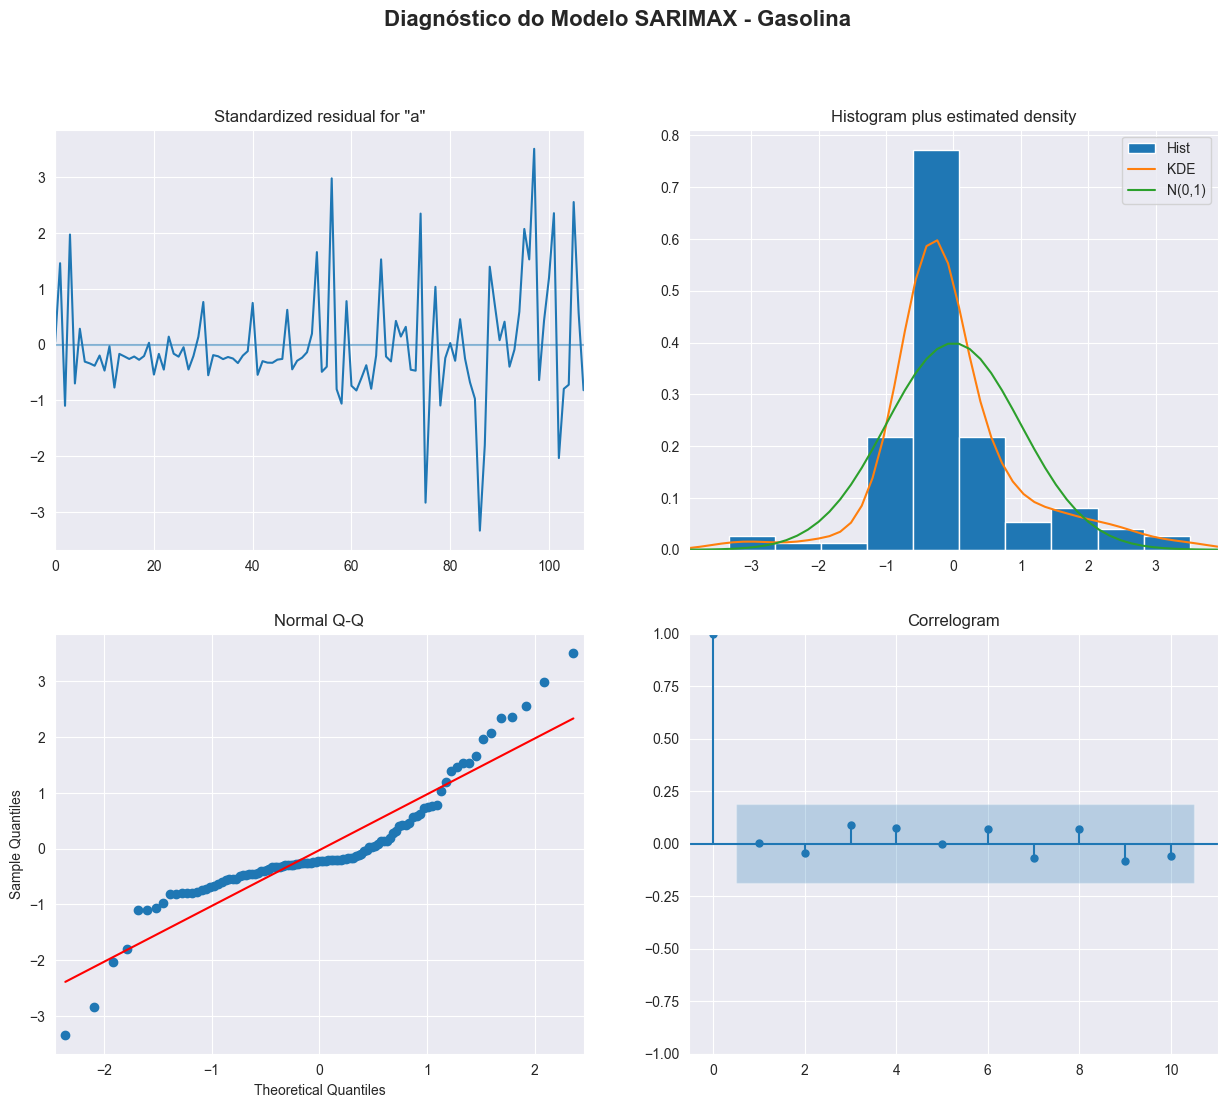


Fazendo previsões para o período de teste...


Métricas de erro:
 - RMSE: 0.30
 - MAE: 0.16
 - MAPE: 2.74%


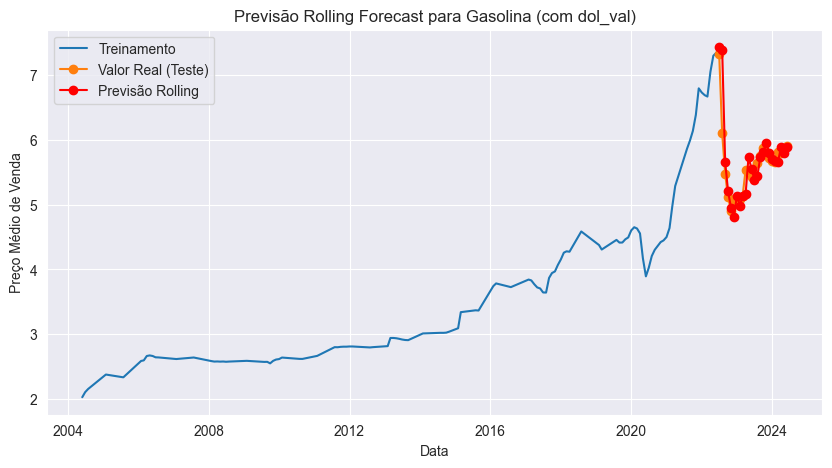


Modelando para Etanol...

Teste de Dickey-Fuller para Etanol:
 - Estatística ADF: -1.4024
 - p-valor: 0.5811
 - Série não estacionária, pode precisar de diferenciação
Período de treino: 2004-05-31 a 2022-05-31
Período de teste: 2022-06-30 a 2024-05-31

Iniciando busca de hiperparâmetros para SARIMAX...


Melhor modelo encontrado:
SARIMA(2, 1, 2)x(0, 0, 0, 12) - AIC: -100.44

Parâmetros do modelo:
                               SARIMAX Results                                
Dep. Variable:        avg_preco_venda   No. Observations:                  110
Model:               SARIMAX(2, 1, 2)   Log Likelihood                  56.222
Date:                Mon, 17 Feb 2025   AIC                           -100.444
Time:                        09:45:04   BIC                            -84.464
Sample:                             0   HQIC                           -93.967
                                - 110                                         
Covariance Type:                  opg         

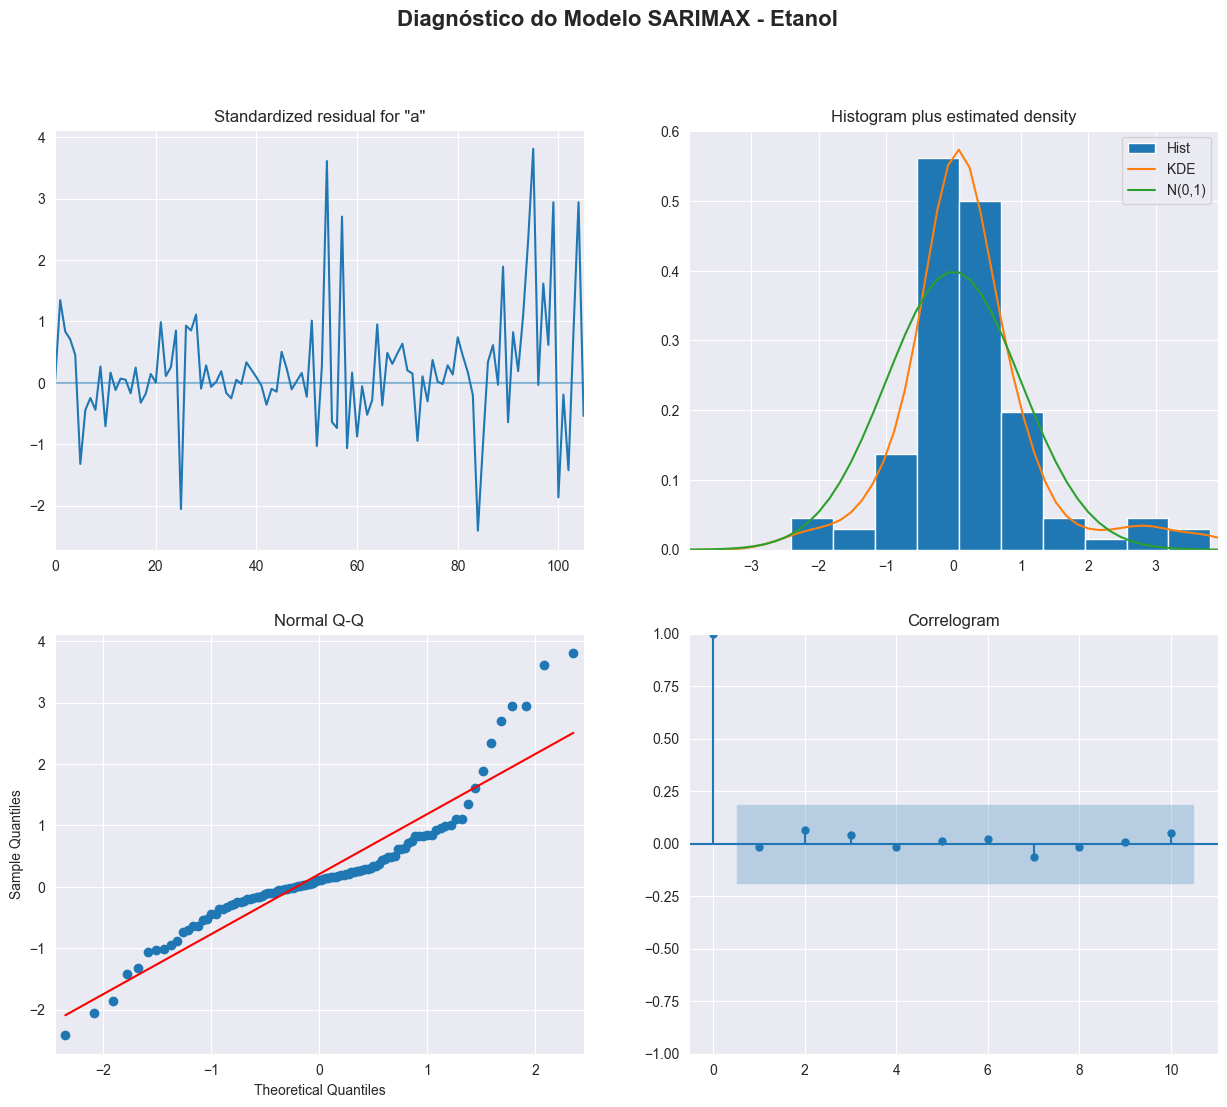


Fazendo previsões para o período de teste...


Métricas de erro:
 - RMSE: 0.18
 - MAE: 0.12
 - MAPE: 2.76%


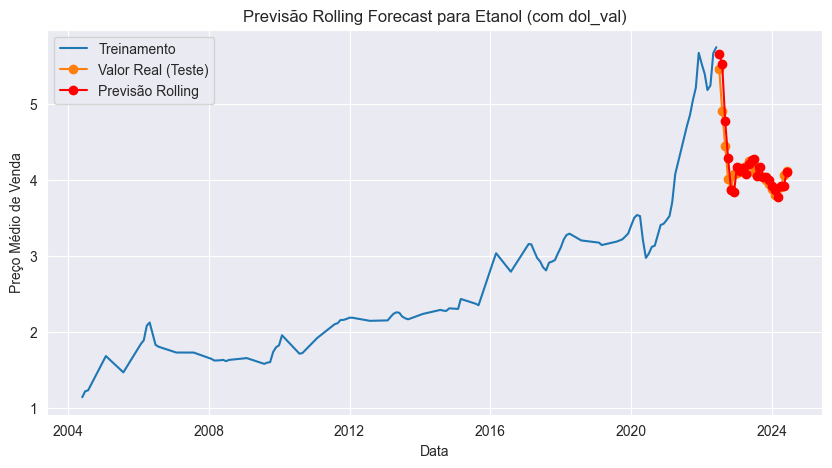


Modelando para Diesel...

Teste de Dickey-Fuller para Diesel:
 - Estatística ADF: -0.8215
 - p-valor: 0.8127
 - Série não estacionária, pode precisar de diferenciação
Período de treino: 2004-05-31 a 2022-05-31
Período de teste: 2022-06-30 a 2024-05-31

Iniciando busca de hiperparâmetros para SARIMAX...


Melhor modelo encontrado:
SARIMA(2, 0, 0)x(0, 0, 0, 12) - AIC: -191.29

Parâmetros do modelo:
                               SARIMAX Results                                
Dep. Variable:        avg_preco_venda   No. Observations:                  110
Model:               SARIMAX(2, 0, 0)   Log Likelihood                  99.646
Date:                Mon, 17 Feb 2025   AIC                           -191.291
Time:                        09:48:51   BIC                           -180.563
Sample:                             0   HQIC                          -186.941
                                - 110                                         
Covariance Type:                  opg         

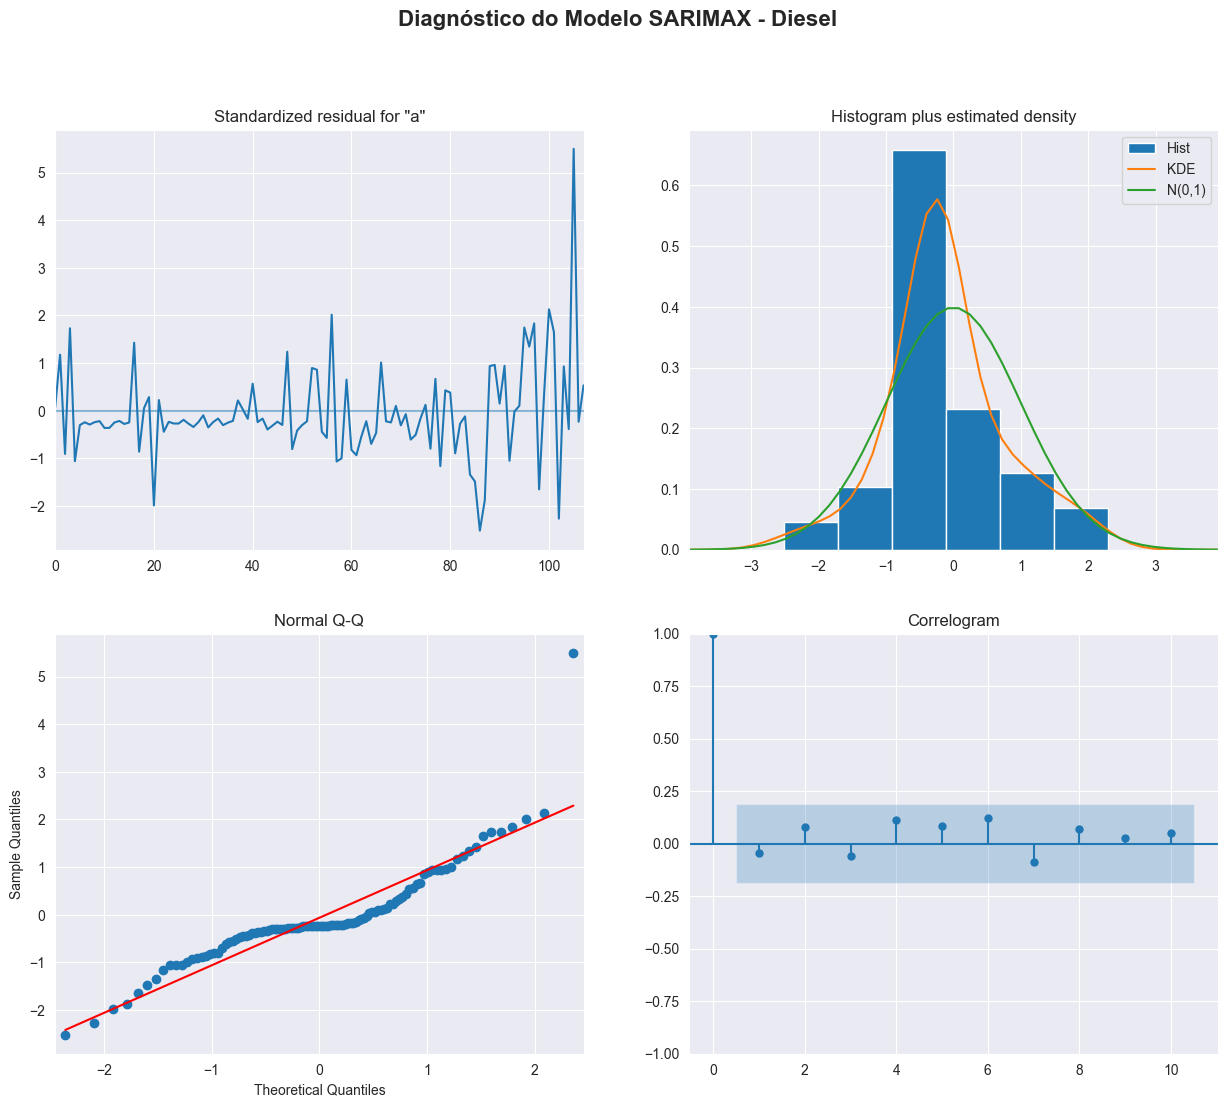


Fazendo previsões para o período de teste...


Métricas de erro:
 - RMSE: 0.24
 - MAE: 0.17
 - MAPE: 2.84%


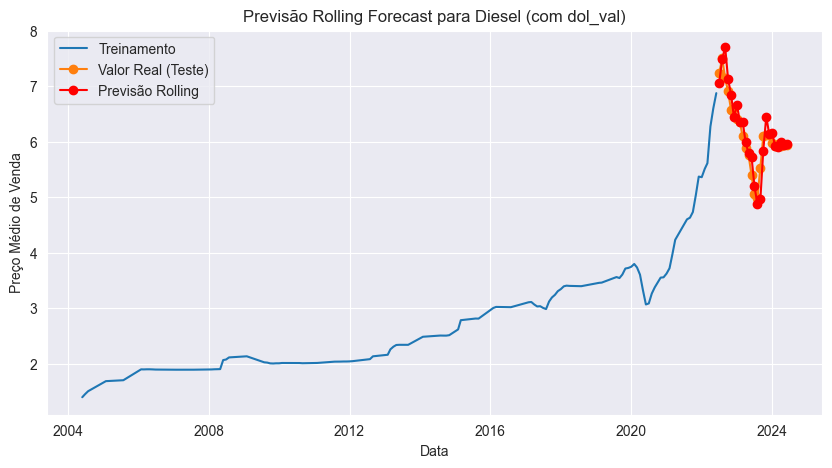


Resumo Final dos Modelos por Produto:

Gasolina:
 - RMSE: 0.30
 - MAE: 0.16
 - MAPE: 2.74%
 - Melhor AIC: -143.03

Etanol:
 - RMSE: 0.18
 - MAE: 0.12
 - MAPE: 2.76%
 - Melhor AIC: -100.44

Diesel:
 - RMSE: 0.24
 - MAE: 0.17
 - MAPE: 2.84%
 - Melhor AIC: -191.29


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("../data/data_dol_val.csv")
df['data'] = pd.to_datetime(df['data'])
df = df.set_index('data')

produtos = ["Gasolina", "Etanol", "Diesel"]
resultados = {}

for produto in produtos:
    print(f"\nModelando para {produto}...\n")

    df_produto = df[df['produto'] == produto]
    ts = df_produto['avg_preco_venda'].resample('M').mean()
    ts = ts.asfreq('M')
    ts_clean = ts.dropna()

    dol_val = df_produto['dol_val'].resample('M').mean()
    dol_val = dol_val.asfreq('M')
    dol_val_clean = dol_val.dropna()

    dol_val = dol_val_clean.reindex(ts_clean.index).fillna(method="ffill")

    resultado_adf = adfuller(ts_clean)
    print(f"Teste de Dickey-Fuller para {produto}:")
    print(f" - Estatística ADF: {resultado_adf[0]:.4f}")
    print(f" - p-valor: {resultado_adf[1]:.4f}")
    print(" - Série considerada estacionária" if resultado_adf[1] < 0.05 else " - Série não estacionária, pode precisar de diferenciação")

    ts_diff = ts_clean.diff().dropna() if resultado_adf[1] > 0.05 else ts_clean

    train_end = '2022-05-31'
    ts_train = ts_clean.loc[:train_end]
    ts_test = ts_clean.loc['2022-06-01':'2024-05-31']

    dol_train = dol_val.loc[:train_end]
    dol_test = dol_val.loc['2022-06-01':'2024-05-31']

    print(f"Período de treino: {ts_train.index.min().date()} a {ts_train.index.max().date()}")
    print(f"Período de teste: {ts_test.index.min().date()} a {ts_test.index.max().date()}")

    p = d = q = range(0, 3)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in itertools.product(range(0, 3), range(0, 3), range(0, 3))]

    lowest_aic = np.inf
    best_pdq = None
    best_seasonal_pdq = None
    best_model = None

    print("\nIniciando busca de hiperparâmetros para SARIMAX...\n")
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = SARIMAX(ts_train, order=param, seasonal_order=param_seasonal,
                              exog=dol_train, enforce_stationarity=False, enforce_invertibility=False)
                results = mod.fit(disp=False)
                if results.aic < lowest_aic:
                    lowest_aic = results.aic
                    best_pdq = param
                    best_seasonal_pdq = param_seasonal
                    best_model = results
            except:
                continue

    print("\nMelhor modelo encontrado:")
    print(f"SARIMA{best_pdq}x{best_seasonal_pdq} - AIC: {lowest_aic:.2f}")

    print("\nParâmetros do modelo:")
    print(best_model.summary())

    best_model.plot_diagnostics(figsize=(15, 12))
    plt.suptitle(f"Diagnóstico do Modelo SARIMAX - {produto}", fontsize=16, fontweight="bold")
    plt.show()

    print("\nFazendo previsões para o período de teste...\n")

    rolling_forecasts = []
    history = ts_train.copy()
    dol_history = dol_train.copy()

    for t in ts_test.index:
        model = SARIMAX(history, order=best_pdq, seasonal_order=best_seasonal_pdq,
                        exog=dol_history, enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False)
        forecast = model_fit.get_forecast(steps=1, exog=dol_test.loc[[t]])
        yhat = forecast.predicted_mean.iloc[0]
        rolling_forecasts.append(yhat)
        history = pd.concat([history, ts_test.loc[[t]]])
        dol_history = pd.concat([dol_history, dol_test.loc[[t]]])

    rolling_forecasts = pd.Series(rolling_forecasts, index=ts_test.index)

    rmse = np.sqrt(mean_squared_error(ts_test, rolling_forecasts))
    mae = mean_absolute_error(ts_test, rolling_forecasts)
    mape = np.mean(np.abs((ts_test - rolling_forecasts) / ts_test)) * 100

    print("\nMétricas de erro:")
    print(f" - RMSE: {rmse:.2f}")
    print(f" - MAE: {mae:.2f}")
    print(f" - MAPE: {mape:.2f}%")

    plt.figure(figsize=(10, 5))
    plt.plot(ts_train, label='Treinamento')
    plt.plot(ts_test, label='Valor Real (Teste)', marker='o')
    plt.plot(rolling_forecasts.index, rolling_forecasts, label='Previsão Rolling', color='red', marker='o')
    plt.title(f"Previsão Rolling Forecast para {produto} (com dol_val)")
    plt.xlabel("Data")
    plt.ylabel("Preço Médio de Venda")
    plt.legend()
    plt.grid(True)
    plt.show()

    resultados[produto] = {
        "melhor_modelo": best_model,
        "rmse": rmse,
        "mae": mae,
        "mape": mape,
        "previsoes": rolling_forecasts
    }

print("\nResumo Final dos Modelos por Produto:")
for produto, res in resultados.items():
    print(f"\n{produto}:")
    print(f" - RMSE: {res['rmse']:.2f}")
    print(f" - MAE: {res['mae']:.2f}")
    print(f" - MAPE: {res['mape']:.2f}%")
    print(f" - Melhor AIC: {res['melhor_modelo'].aic:.2f}")

resultados_1 = resultados

### Correlação entre dol_val e componentes do SARIMA

In [21]:
model_sarima = SARIMAX(ts_train, order=best_pdq, seasonal_order=best_seasonal_pdq,
                       enforce_stationarity=False, enforce_invertibility=False)
results_sarima = model_sarima.fit()

residuos_sarima = results_sarima.resid

correlacao = dol_train.corr(residuos_sarima)

print(f"Correlação entre dol_val e resíduos do SARIMA: {correlacao:.4f}")

Correlação entre dol_val e resíduos do SARIMA: 0.0814


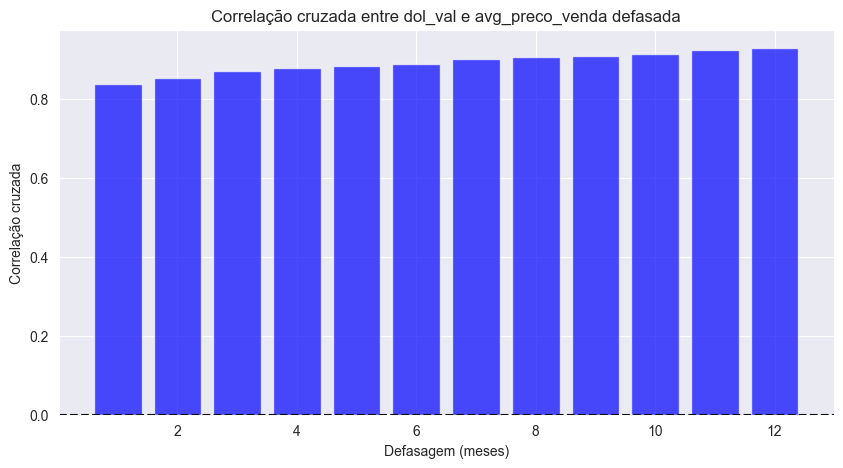


Matriz de Correlação entre dol_val e os Componentes ARIMA:
            AR(1)     AR(2)     MA(1)     MA(2)   dol_val
AR(1)    1.000000  0.995267  0.268046  0.095064  0.845950
AR(2)    0.995267  1.000000  0.196100  0.075661  0.854251
MA(1)    0.268046  0.196100  1.000000 -0.397882  0.116817
MA(2)    0.095064  0.075661 -0.397882  1.000000  0.066922
dol_val  0.845950  0.854251  0.116817  0.066922  1.000000


In [22]:
max_lag = 12
lags = range(1, max_lag + 1)

correlations = {}
for lag in lags:
    correlations[lag] = ts_train.shift(lag).corr(dol_train)

ccf_values = [correlations[lag] for lag in lags]
plt.figure(figsize=(10, 5))
plt.bar(lags, ccf_values, color='blue', alpha=0.7)
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel("Defasagem (meses)")
plt.ylabel("Correlação cruzada")
plt.title("Correlação cruzada entre dol_val e avg_preco_venda defasada")
plt.grid(True)
plt.show()

arima_features = pd.DataFrame({
    'AR(1)': ts_train.shift(1),
    'AR(2)': ts_train.shift(2),
    'MA(1)': results_sarima.resid.shift(1),
    'MA(2)': results_sarima.resid.shift(2),
    'dol_val': dol_train
}).dropna()

cor_matrix = arima_features.corr()
print("\nMatriz de Correlação entre dol_val e os Componentes ARIMA:")
print(cor_matrix)



Modelando para Gasolina...

Teste de Dickey-Fuller para Gasolina:
 - Estatística ADF: -1.1033
 - p-valor: 0.7138
 - Série não estacionária, pode precisar de diferenciação
Período de treino: 2004-05-31 a 2022-05-31
Período de teste: 2022-06-30 a 2024-08-31

Iniciando busca de hiperparâmetros para SARIMAX...


Melhor modelo encontrado:
SARIMA(0, 2, 2)x(0, 0, 0, 12) - AIC: -135.56

Parâmetros do modelo:
                               SARIMAX Results                                
Dep. Variable:        avg_preco_venda   No. Observations:                  110
Model:               SARIMAX(0, 2, 2)   Log Likelihood                  71.778
Date:                Mon, 17 Feb 2025   AIC                           -135.557
Time:                        09:49:05   BIC                           -124.941
Sample:                             0   HQIC                          -131.255
                                - 110                                         
Covariance Type:                  opg     

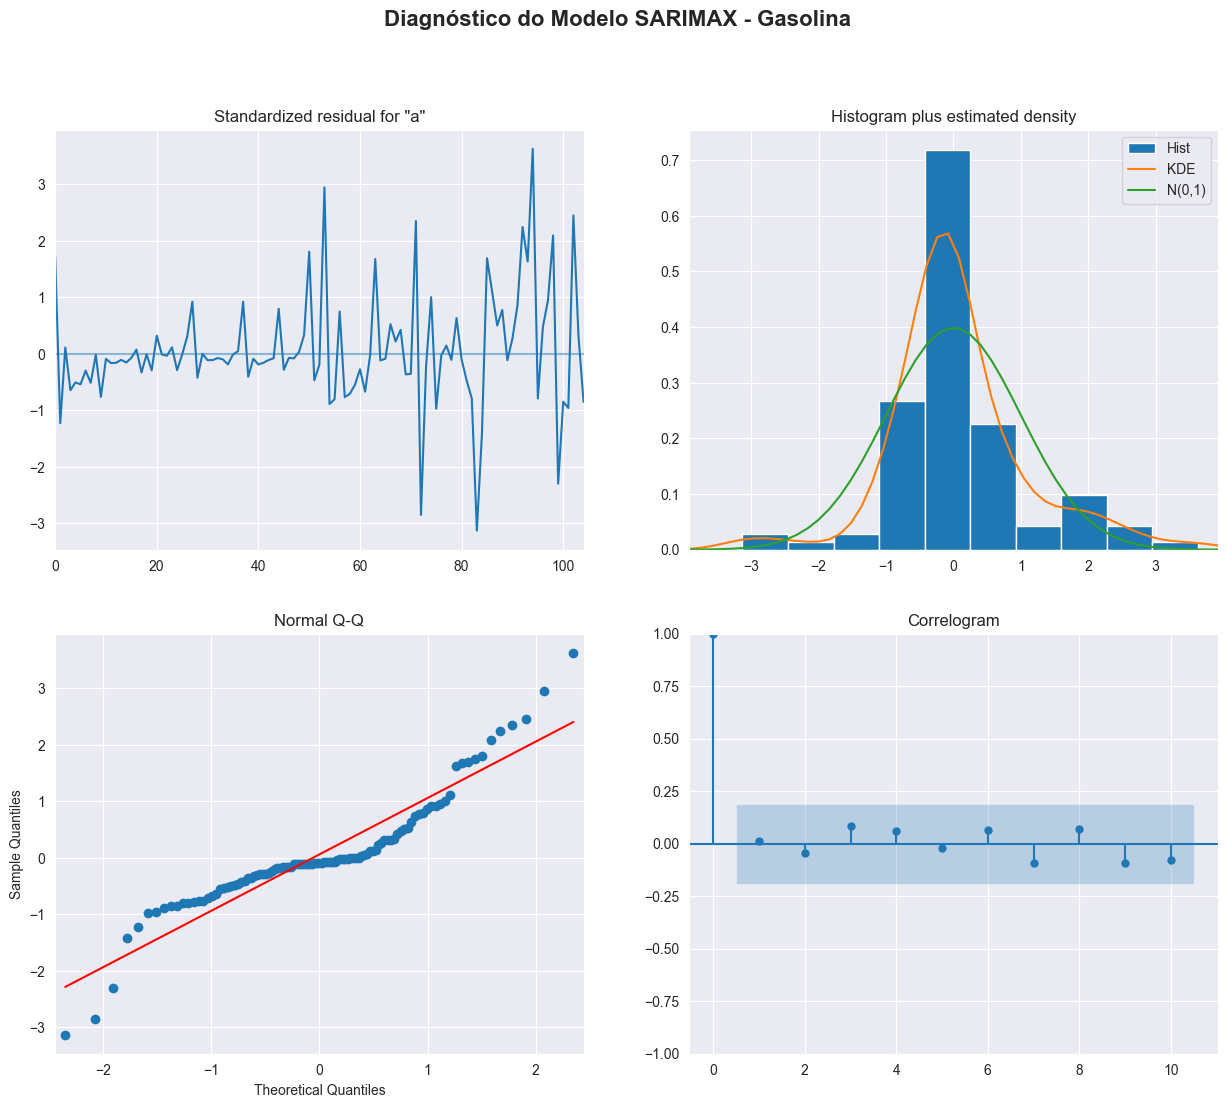


Fazendo previsões para o período de teste...


Métricas de erro:
 - RMSE: 0.29
 - MAE: 0.16
 - MAPE: 2.81%


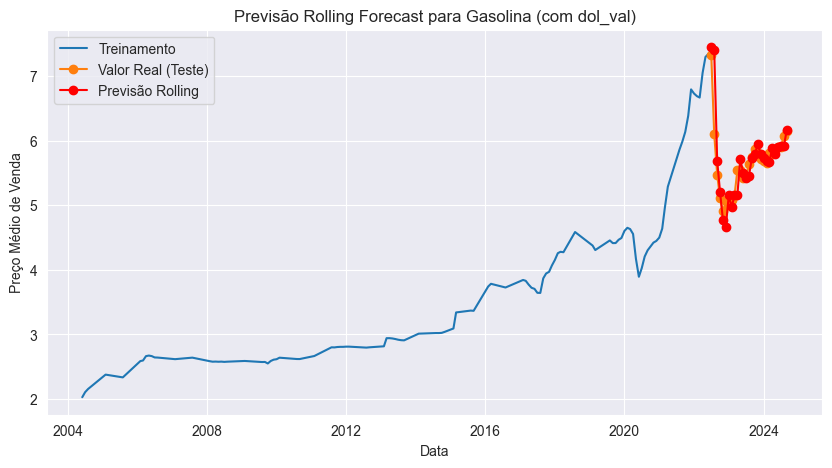


Modelando para Etanol...

Teste de Dickey-Fuller para Etanol:
 - Estatística ADF: -1.4024
 - p-valor: 0.5811
 - Série não estacionária, pode precisar de diferenciação
Período de treino: 2004-05-31 a 2022-05-31
Período de teste: 2022-06-30 a 2024-08-31

Iniciando busca de hiperparâmetros para SARIMAX...


Melhor modelo encontrado:
SARIMA(0, 2, 2)x(0, 0, 0, 12) - AIC: -95.71

Parâmetros do modelo:
                               SARIMAX Results                                
Dep. Variable:        avg_preco_venda   No. Observations:                  110
Model:               SARIMAX(0, 2, 2)   Log Likelihood                  51.854
Date:                Mon, 17 Feb 2025   AIC                            -95.707
Time:                        09:49:19   BIC                            -85.091
Sample:                             0   HQIC                           -91.405
                                - 110                                         
Covariance Type:                  opg          

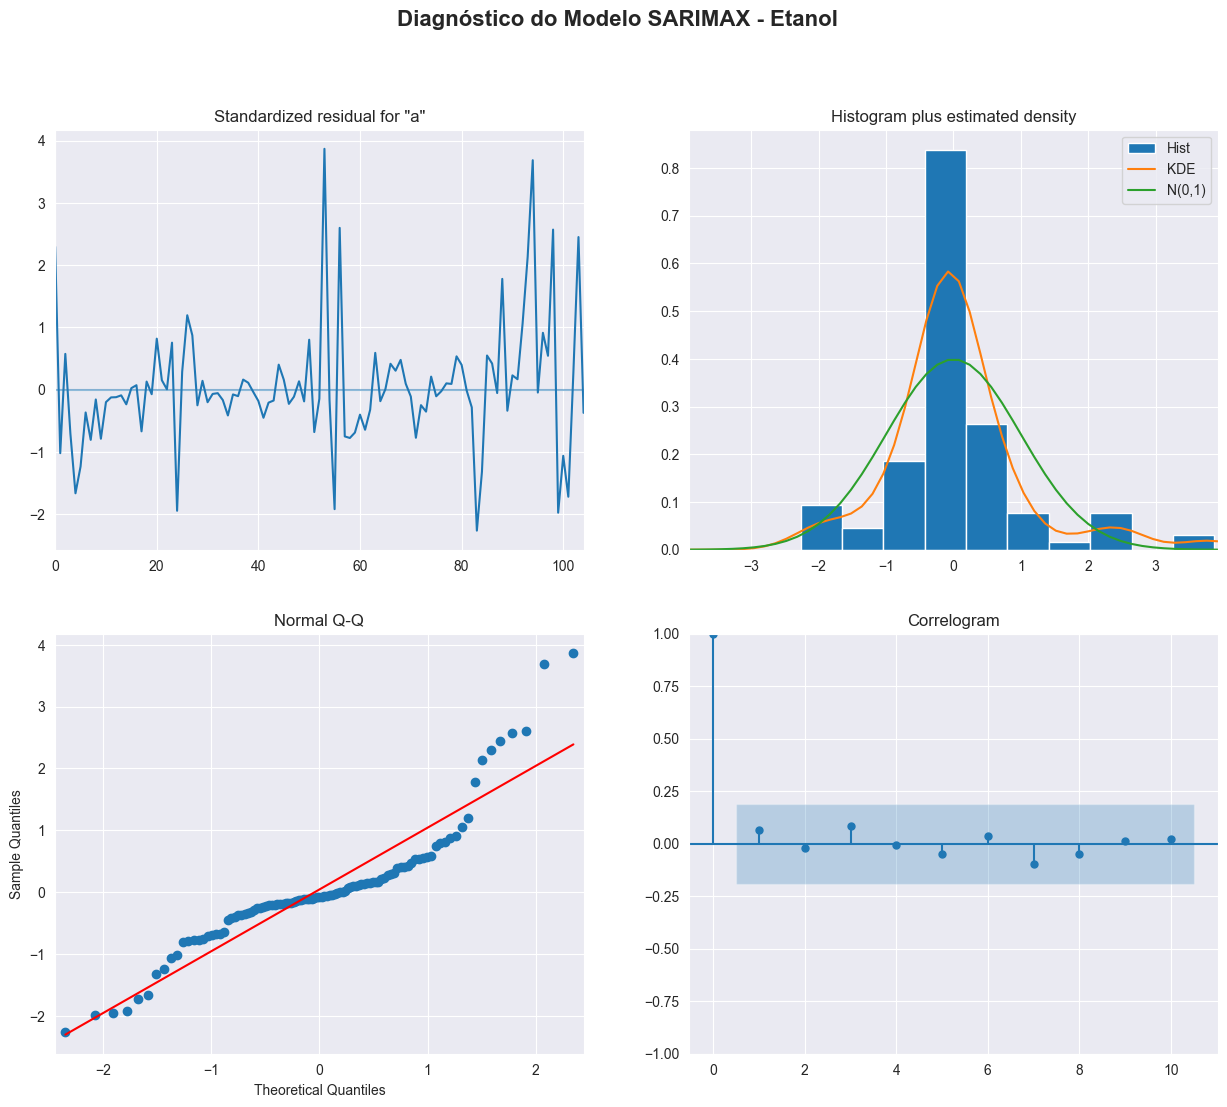


Fazendo previsões para o período de teste...


Métricas de erro:
 - RMSE: 0.19
 - MAE: 0.14
 - MAPE: 3.17%


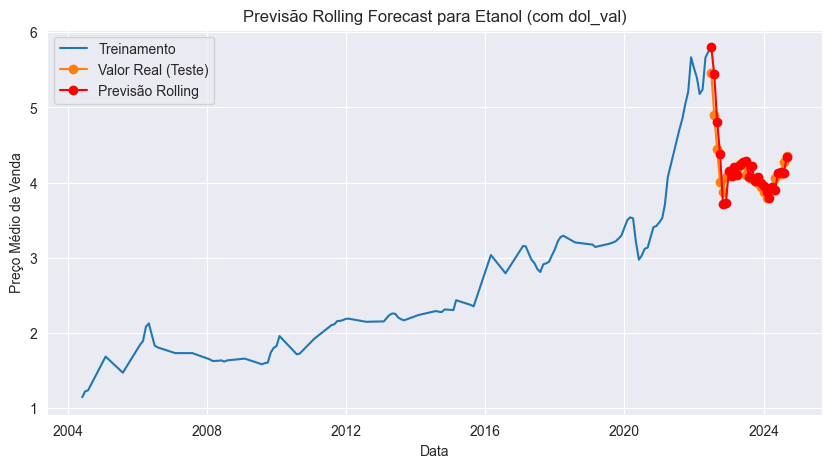


Modelando para Diesel...

Teste de Dickey-Fuller para Diesel:
 - Estatística ADF: -0.8215
 - p-valor: 0.8127
 - Série não estacionária, pode precisar de diferenciação
Período de treino: 2004-05-31 a 2022-05-31
Período de teste: 2022-06-30 a 2024-08-31

Iniciando busca de hiperparâmetros para SARIMAX...


Melhor modelo encontrado:
SARIMA(0, 2, 1)x(0, 0, 0, 12) - AIC: -186.49

Parâmetros do modelo:
                               SARIMAX Results                                
Dep. Variable:        avg_preco_venda   No. Observations:                  110
Model:               SARIMAX(0, 2, 1)   Log Likelihood                  96.245
Date:                Mon, 17 Feb 2025   AIC                           -186.489
Time:                        09:49:34   BIC                           -178.499
Sample:                             0   HQIC                          -183.251
                                - 110                                         
Covariance Type:                  opg         

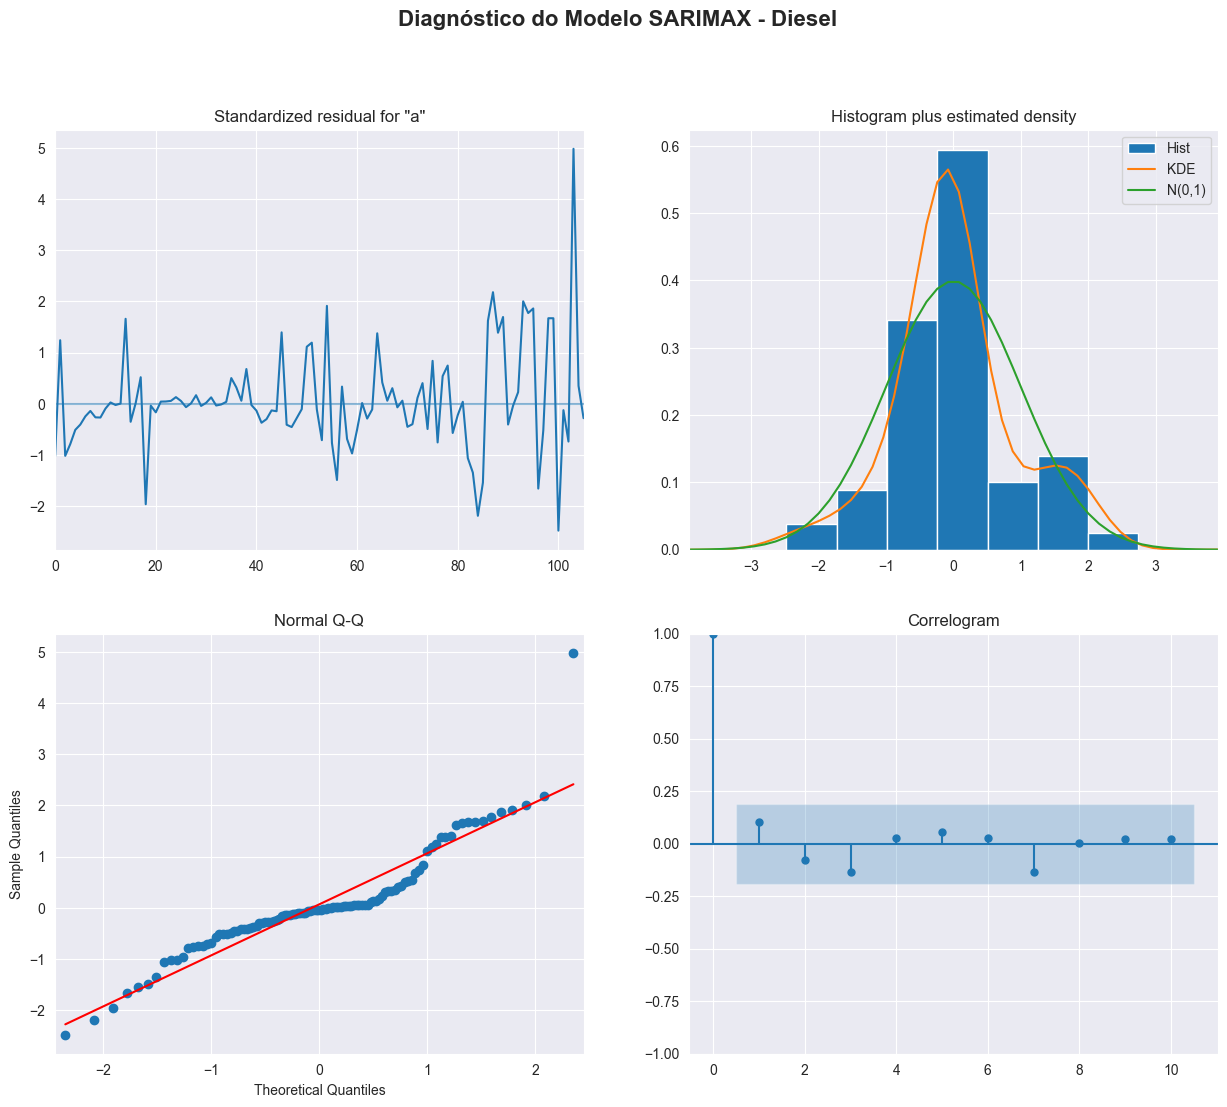


Fazendo previsões para o período de teste...


Métricas de erro:
 - RMSE: 0.27
 - MAE: 0.18
 - MAPE: 2.99%


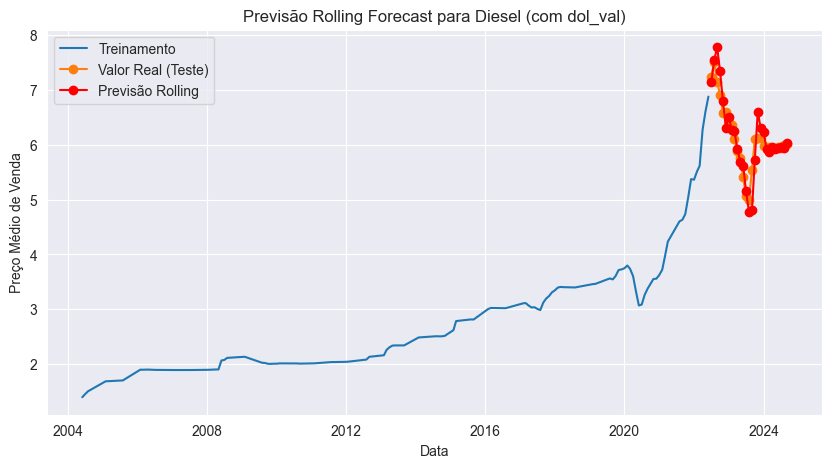


Resumo Final dos Modelos por Produto:

Gasolina:
 - RMSE: 0.29
 - MAE: 0.16
 - MAPE: 2.81%
 - Melhor AIC: -135.56

Etanol:
 - RMSE: 0.19
 - MAE: 0.14
 - MAPE: 3.17%
 - Melhor AIC: -95.71

Diesel:
 - RMSE: 0.27
 - MAE: 0.18
 - MAPE: 2.99%
 - Melhor AIC: -186.49


In [23]:
df = pd.read_csv("../data/data_dol_val.csv")
df['data'] = pd.to_datetime(df['data'])
df = df.set_index('data')

produtos = ["Gasolina", "Etanol", "Diesel"]
resultados = {}

for produto in produtos:
    print(f"\nModelando para {produto}...\n")

    df_produto = df[df['produto'] == produto]
    ts = df_produto['avg_preco_venda'].resample('M').mean()
    ts = ts.asfreq('M')
    ts_clean = ts.dropna()

    dol_val = df_produto['dol_val'].resample('M').mean()
    dol_val = dol_val.asfreq('M')
    dol_val_clean = dol_val.dropna()

    dol_val = dol_val_clean.reindex(ts_clean.index).fillna(method="ffill")

    resultado_adf = adfuller(ts_clean)
    print(f"Teste de Dickey-Fuller para {produto}:")
    print(f" - Estatística ADF: {resultado_adf[0]:.4f}")
    print(f" - p-valor: {resultado_adf[1]:.4f}")
    print(" - Série considerada estacionária" if resultado_adf[1] < 0.05 else " - Série não estacionária, pode precisar de diferenciação")

    ts_diff = ts_clean.diff().dropna() if resultado_adf[1] > 0.05 else ts_clean

    train_end = '2022-05-31'
    ts_train = ts_clean.loc[:train_end]
    ts_test = ts_clean.loc['2022-06-01':'2024-08-31']

    dol_train = dol_val.loc[:train_end]
    dol_test = dol_val.loc['2022-06-01':'2024-08-31']

    print(f"Período de treino: {ts_train.index.min().date()} a {ts_train.index.max().date()}")
    print(f"Período de teste: {ts_test.index.min().date()} a {ts_test.index.max().date()}")

    p = [0]
    d = q = range(0, 3)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(0, x[0], x[1], 12) for x in itertools.product(range(0, 3), range(0, 3))]

    lowest_aic = np.inf
    best_pdq = None
    best_seasonal_pdq = None
    best_model = None

    print("\nIniciando busca de hiperparâmetros para SARIMAX...\n")
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = SARIMAX(ts_train, order=param, seasonal_order=param_seasonal,
                              exog=dol_train, enforce_stationarity=False, enforce_invertibility=False)
                results = mod.fit(disp=False)
                if results.aic < lowest_aic:
                    lowest_aic = results.aic
                    best_pdq = param
                    best_seasonal_pdq = param_seasonal
                    best_model = results
            except:
                continue

    print("\nMelhor modelo encontrado:")
    print(f"SARIMA{best_pdq}x{best_seasonal_pdq} - AIC: {lowest_aic:.2f}")

    print("\nParâmetros do modelo:")
    print(best_model.summary())

    best_model.plot_diagnostics(figsize=(15, 12))
    plt.suptitle(f"Diagnóstico do Modelo SARIMAX - {produto}", fontsize=16, fontweight="bold")
    plt.show()

    print("\nFazendo previsões para o período de teste...\n")

    rolling_forecasts = []
    history = ts_train.copy()
    dol_history = dol_train.copy()

    for t in ts_test.index:
        model = SARIMAX(history, order=best_pdq, seasonal_order=best_seasonal_pdq,
                        exog=dol_history, enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False)
        forecast = model_fit.get_forecast(steps=1, exog=dol_test.loc[[t]])
        yhat = forecast.predicted_mean.iloc[0]
        rolling_forecasts.append(yhat)
        history = pd.concat([history, ts_test.loc[[t]]])
        dol_history = pd.concat([dol_history, dol_test.loc[[t]]])

    rolling_forecasts = pd.Series(rolling_forecasts, index=ts_test.index)

    rmse = np.sqrt(mean_squared_error(ts_test, rolling_forecasts))
    mae = mean_absolute_error(ts_test, rolling_forecasts)
    mape = np.mean(np.abs((ts_test - rolling_forecasts) / ts_test)) * 100

    print("\nMétricas de erro:")
    print(f" - RMSE: {rmse:.2f}")
    print(f" - MAE: {mae:.2f}")
    print(f" - MAPE: {mape:.2f}%")

    plt.figure(figsize=(10, 5))
    plt.plot(ts_train, label='Treinamento')
    plt.plot(ts_test, label='Valor Real (Teste)', marker='o')
    plt.plot(rolling_forecasts.index, rolling_forecasts, label='Previsão Rolling', color='red', marker='o')
    plt.title(f"Previsão Rolling Forecast para {produto} (com dol_val)")
    plt.xlabel("Data")
    plt.ylabel("Preço Médio de Venda")
    plt.legend()
    plt.grid(True)
    plt.show()

    resultados[produto] = {
        "melhor_modelo": best_model,
        "rmse": rmse,
        "mae": mae,
        "mape": mape,
        "previsoes": rolling_forecasts
    }

print("\nResumo Final dos Modelos por Produto:")
for produto, res in resultados.items():
    print(f"\n{produto}:")
    print(f" - RMSE: {res['rmse']:.2f}")
    print(f" - MAE: {res['mae']:.2f}")
    print(f" - MAPE: {res['mape']:.2f}%")
    print(f" - Melhor AIC: {res['melhor_modelo'].aic:.2f}")

resultados_1 = resultados

## SARIMAX Model + Variável avg_preco_compra


Modelando para Gasolina...

Teste de Dickey-Fuller para Gasolina:
 - Estatística ADF: -1.1033
 - p-valor: 0.7138
 - Série não estacionária, pode precisar de diferenciação
Período de treino: 2004-05-31 a 2022-05-31
Período de teste: 2022-06-30 a 2024-05-31

Iniciando busca de hiperparâmetros para SARIMAX...


Melhor modelo encontrado:
SARIMA(0, 1, 1)x(0, 0, 0, 12) - AIC: -131.50

Parâmetros do modelo:
                               SARIMAX Results                                
Dep. Variable:        avg_preco_venda   No. Observations:                  110
Model:               SARIMAX(0, 1, 1)   Log Likelihood                  68.749
Date:                Mon, 17 Feb 2025   AIC                           -131.498
Time:                        09:49:36   BIC                           -123.480
Sample:                             0   HQIC                          -128.248
                                - 110                                         
Covariance Type:                  opg     

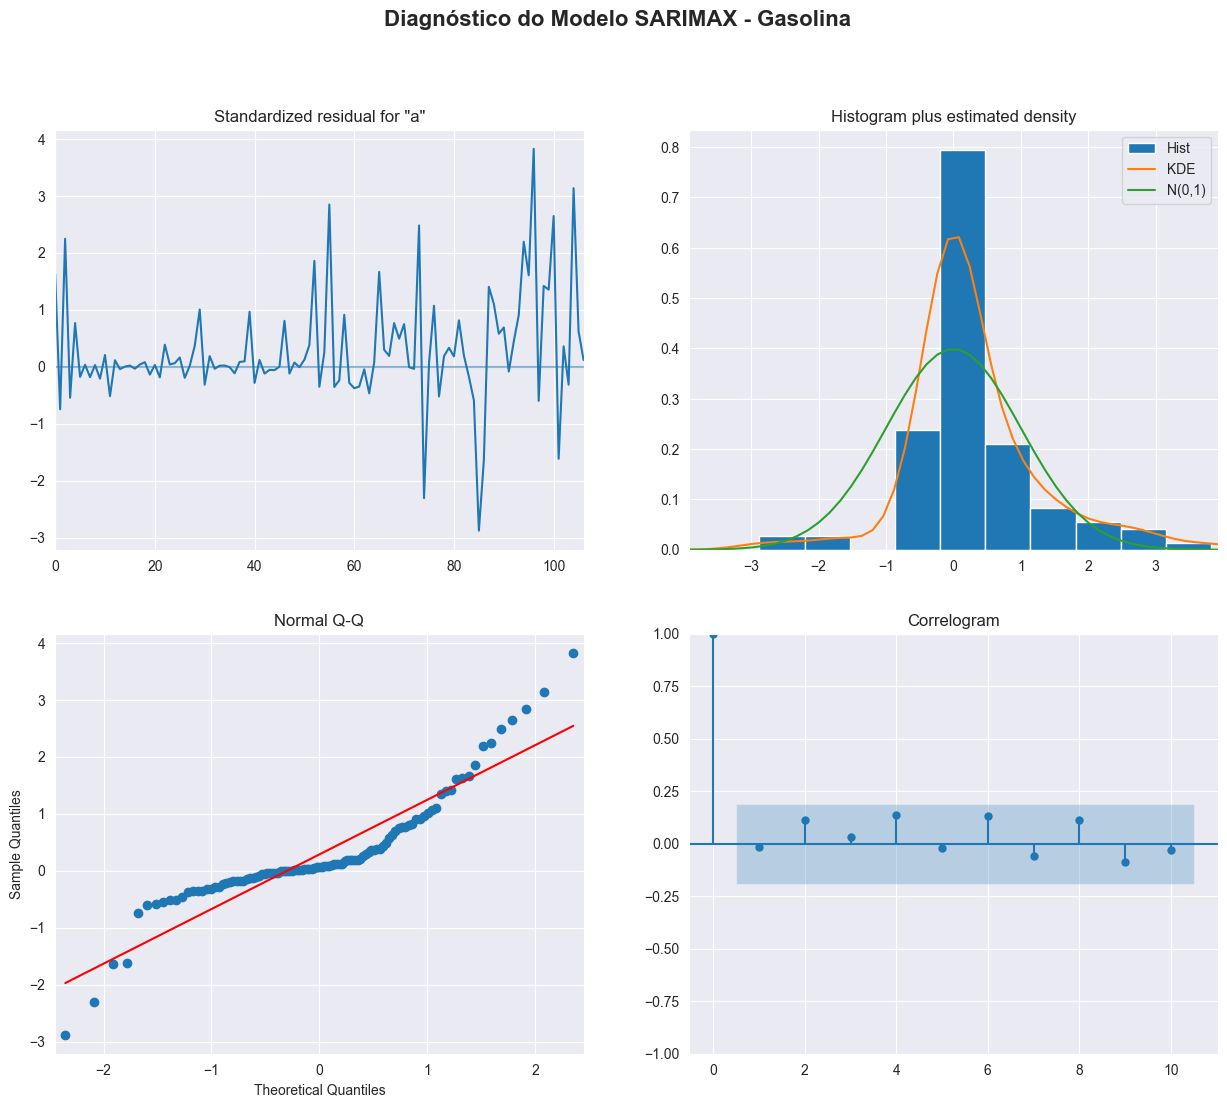


Fazendo previsões para o período de teste...


Métricas de erro:
 - RMSE: 0.29
 - MAE: 0.15
 - MAPE: 2.74%


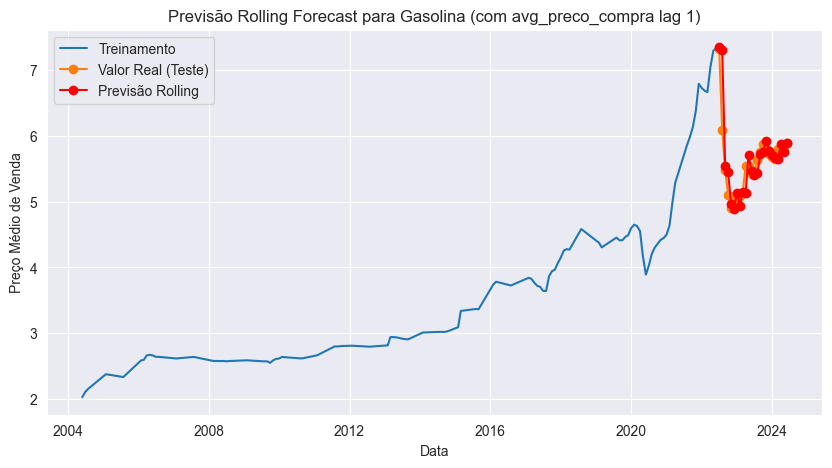


Modelando para Etanol...

Teste de Dickey-Fuller para Etanol:
 - Estatística ADF: -1.4024
 - p-valor: 0.5811
 - Série não estacionária, pode precisar de diferenciação
Período de treino: 2004-05-31 a 2022-05-31
Período de teste: 2022-06-30 a 2024-05-31

Iniciando busca de hiperparâmetros para SARIMAX...


Melhor modelo encontrado:
SARIMA(0, 1, 1)x(0, 0, 1, 12) - AIC: -88.89

Parâmetros do modelo:
                                     SARIMAX Results                                      
Dep. Variable:                    avg_preco_venda   No. Observations:                  110
Model:             SARIMAX(0, 1, 1)x(0, 0, 1, 12)   Log Likelihood                  48.445
Date:                            Mon, 17 Feb 2025   AIC                            -88.890
Time:                                    09:49:37   BIC                            -78.674
Sample:                                         0   HQIC                           -84.762
                                            - 110     

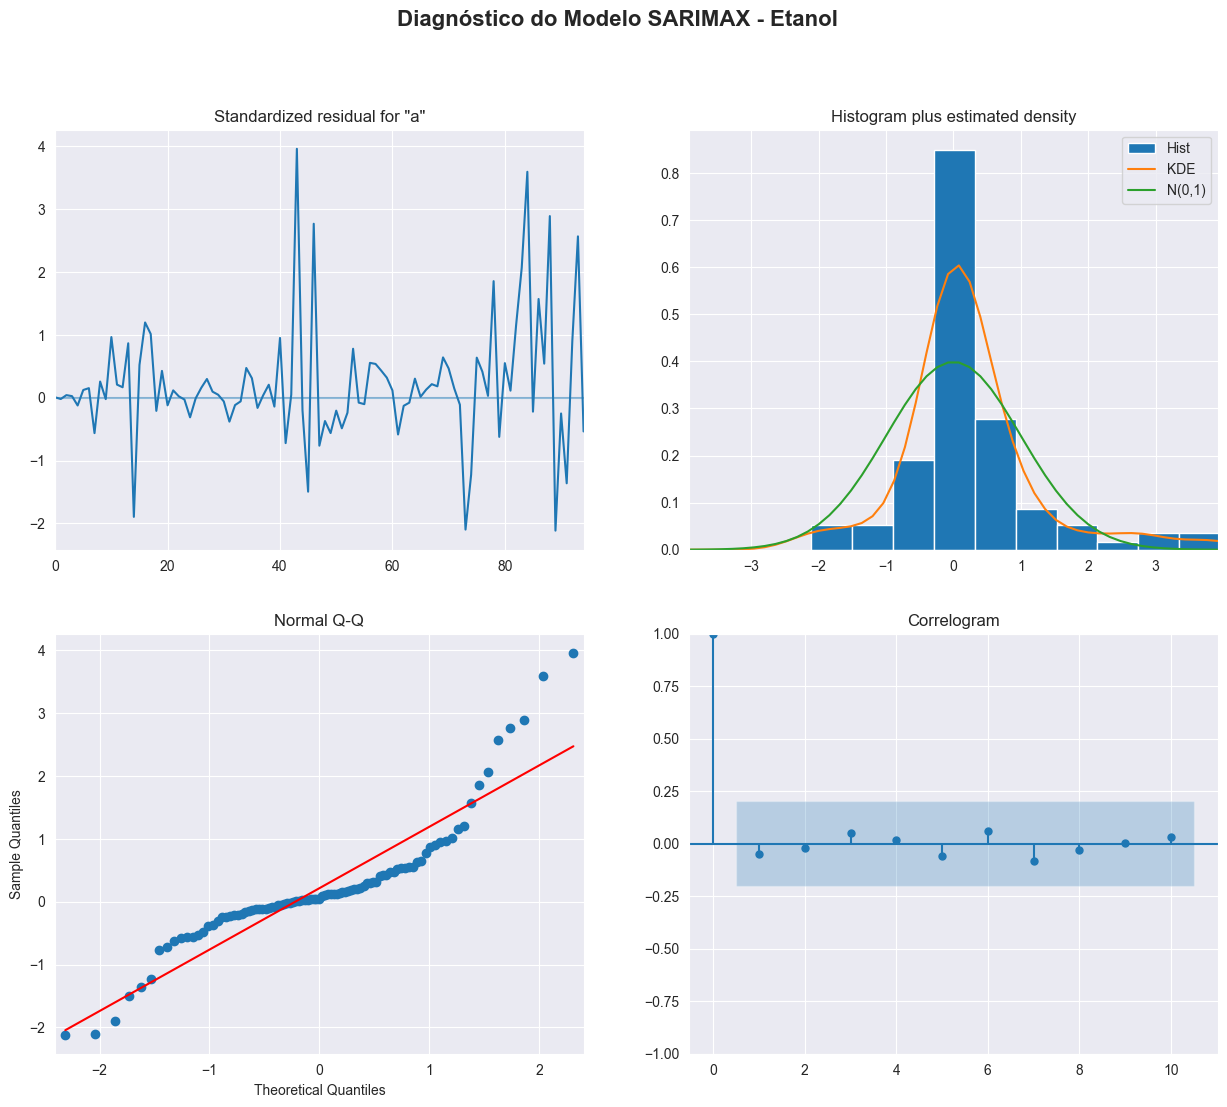


Fazendo previsões para o período de teste...


Métricas de erro:
 - RMSE: 0.17
 - MAE: 0.13
 - MAPE: 3.07%


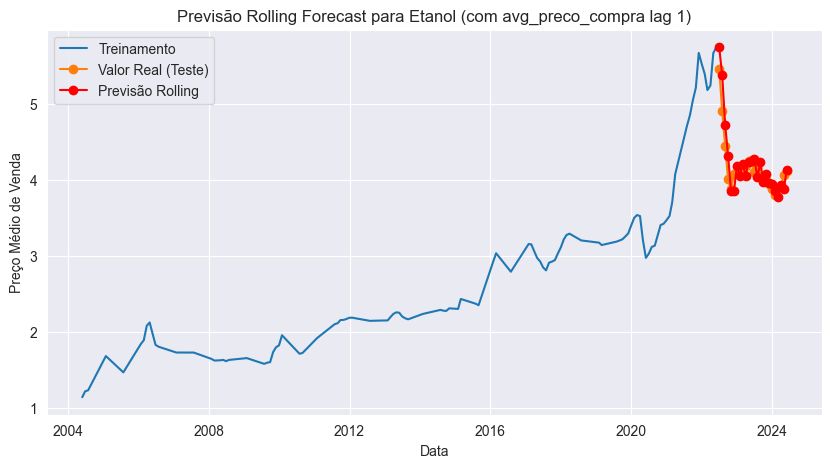


Modelando para Diesel...

Teste de Dickey-Fuller para Diesel:
 - Estatística ADF: -0.8215
 - p-valor: 0.8127
 - Série não estacionária, pode precisar de diferenciação
Período de treino: 2004-05-31 a 2022-05-31
Período de teste: 2022-06-30 a 2024-05-31

Iniciando busca de hiperparâmetros para SARIMAX...


Melhor modelo encontrado:
SARIMA(0, 1, 1)x(0, 0, 0, 12) - AIC: -161.35

Parâmetros do modelo:
                               SARIMAX Results                                
Dep. Variable:        avg_preco_venda   No. Observations:                  110
Model:               SARIMAX(0, 1, 1)   Log Likelihood                  83.674
Date:                Mon, 17 Feb 2025   AIC                           -161.348
Time:                        09:49:39   BIC                           -153.329
Sample:                             0   HQIC                          -158.097
                                - 110                                         
Covariance Type:                  opg         

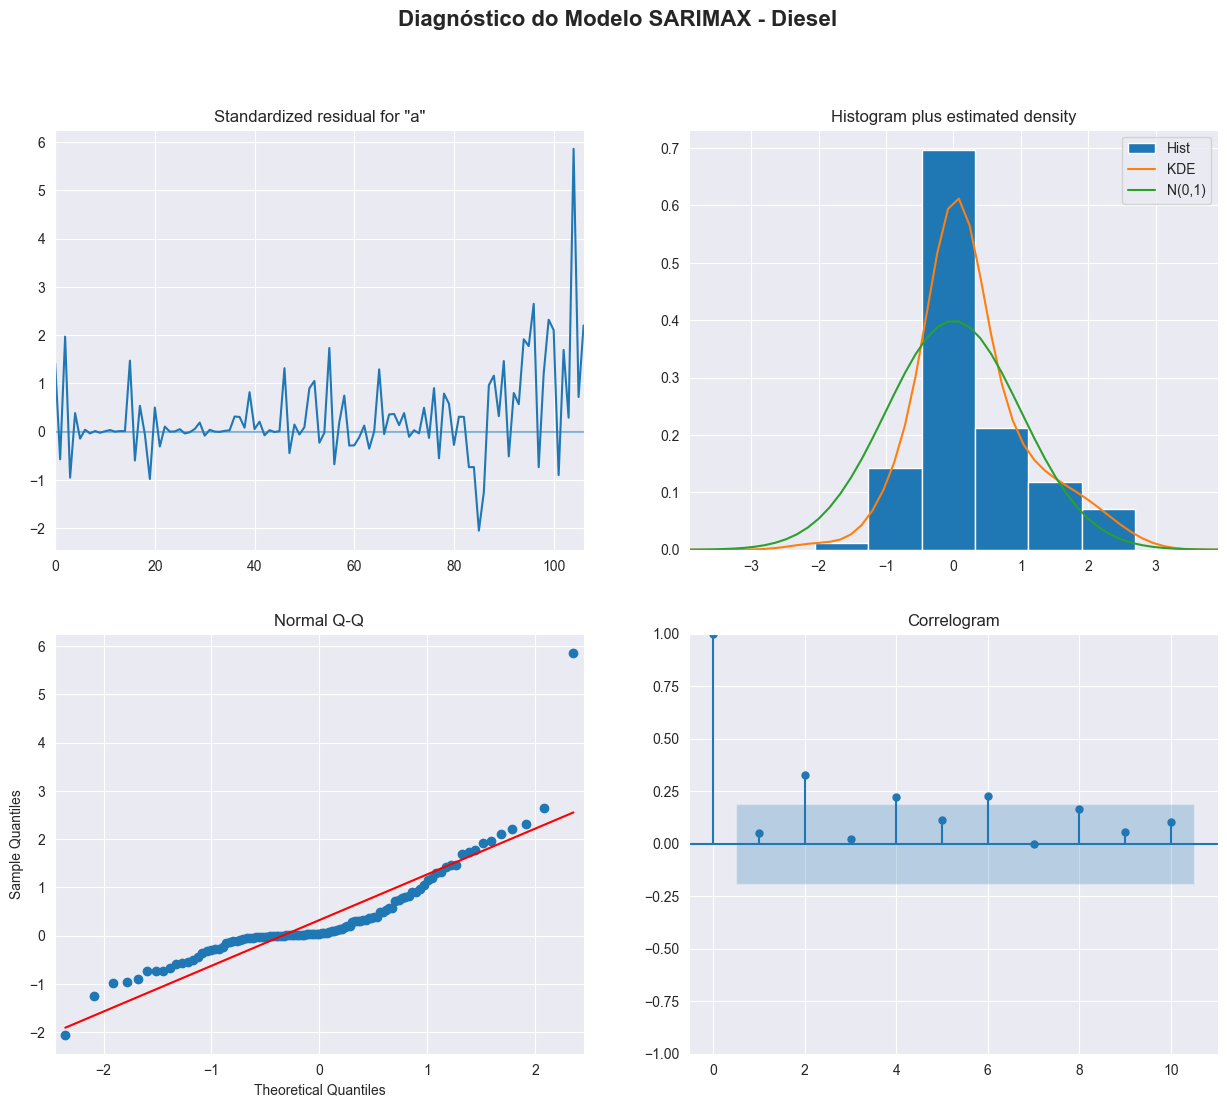


Fazendo previsões para o período de teste...


Métricas de erro:
 - RMSE: 0.22
 - MAE: 0.17
 - MAPE: 2.74%


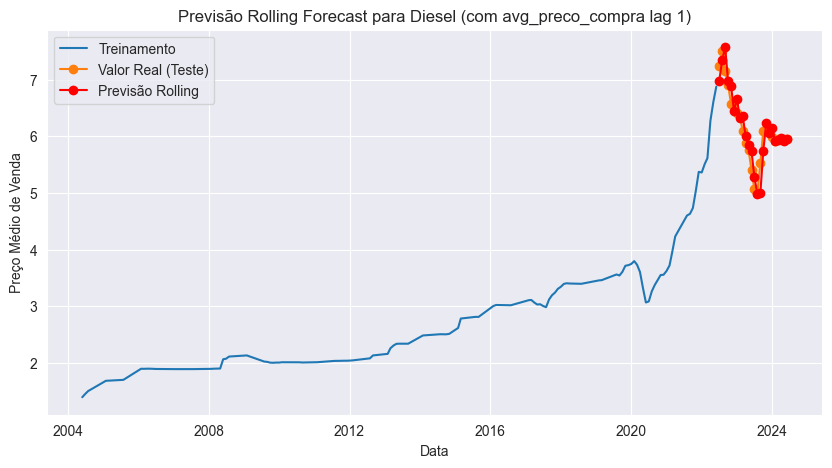


Resumo Final dos Modelos por Produto:

Gasolina:
 - RMSE: 0.29
 - MAE: 0.15
 - MAPE: 2.74%
 - Melhor AIC: -131.50

Etanol:
 - RMSE: 0.17
 - MAE: 0.13
 - MAPE: 3.07%
 - Melhor AIC: -88.89

Diesel:
 - RMSE: 0.22
 - MAE: 0.17
 - MAPE: 2.74%
 - Melhor AIC: -161.35


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("../data/data_dol_val.csv")
df['data'] = pd.to_datetime(df['data'])
df = df.set_index('data')

produtos = ["Gasolina", "Etanol", "Diesel"]
resultados = {}

for produto in produtos:
    print(f"\nModelando para {produto}...\n")
    df_produto = df[df['produto'] == produto]

    ts = df_produto['avg_preco_venda'].resample('M').mean()
    ts = ts.asfreq('M')
    ts_clean = ts.dropna()

    avg_preco_compra = df_produto['avg_preco_compra'].resample('M').mean()
    avg_preco_compra = avg_preco_compra.asfreq('M')
    avg_preco_compra_clean = avg_preco_compra.dropna()

    avg_preco_compra_lag = avg_preco_compra_clean.shift(1)
    avg_preco_compra_lag = avg_preco_compra_lag.reindex(ts_clean.index).fillna(method="ffill").fillna(method="bfill")

    resultado_adf = adfuller(ts_clean)
    print(f"Teste de Dickey-Fuller para {produto}:")
    print(f" - Estatística ADF: {resultado_adf[0]:.4f}")
    print(f" - p-valor: {resultado_adf[1]:.4f}")
    print(" - Série considerada estacionária" if resultado_adf[1] < 0.05
          else " - Série não estacionária, pode precisar de diferenciação")

    ts_diff = ts_clean.diff().dropna() if resultado_adf[1] > 0.05 else ts_clean

    train_end = '2022-05-31'
    ts_train = ts_clean.loc[:train_end]
    ts_test = ts_clean.loc['2022-06-01':'2024-05-31']

    compra_train = avg_preco_compra_lag.loc[:train_end]
    compra_test = avg_preco_compra_lag.loc['2022-06-01':'2024-05-31']


    print(f"Período de treino: {ts_train.index.min().date()} a {ts_train.index.max().date()}")
    print(f"Período de teste: {ts_test.index.min().date()} a {ts_test.index.max().date()}")

    p = [0]
    d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(0, x[0], x[1], 12) for x in itertools.product(range(0, 2), range(0, 2))]

    lowest_aic = np.inf
    best_pdq = None
    best_seasonal_pdq = None
    best_model = None

    print("\nIniciando busca de hiperparâmetros para SARIMAX...\n")
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = SARIMAX(ts_train, order=param, seasonal_order=param_seasonal,
                              exog=compra_train, enforce_stationarity=False, enforce_invertibility=False)
                results = mod.fit(disp=False)
                if results.aic < lowest_aic:
                    lowest_aic = results.aic
                    best_pdq = param
                    best_seasonal_pdq = param_seasonal
                    best_model = results
            except Exception as e:
                continue

    if best_model is None:
        print("Nenhum modelo válido foi encontrado na busca de hiperparâmetros. Usando modelo padrão SARIMAX(1,1,1)x(0,1,1,12).")
        mod = SARIMAX(ts_train, order=(1,1,1), seasonal_order=(0,1,1,12),
                      exog=compra_train, enforce_stationarity=False, enforce_invertibility=False)
        best_model = mod.fit(disp=False)
        lowest_aic = best_model.aic
        best_pdq = (1,1,1)
        best_seasonal_pdq = (0,1,1,12)

    print("\nMelhor modelo encontrado:")
    print(f"SARIMA{best_pdq}x{best_seasonal_pdq} - AIC: {lowest_aic:.2f}")
    print("\nParâmetros do modelo:")
    print(best_model.summary())

    best_model.plot_diagnostics(figsize=(15, 12))
    plt.suptitle(f"Diagnóstico do Modelo SARIMAX - {produto}", fontsize=16, fontweight="bold")
    plt.show()

    print("\nFazendo previsões para o período de teste...\n")
    rolling_forecasts = []
    history = ts_train.copy()
    compra_history = compra_train.copy()

    for t in ts_test.index:
        model = SARIMAX(history, order=best_pdq, seasonal_order=best_seasonal_pdq,
                        exog=compra_history, enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False)
        forecast = model_fit.get_forecast(steps=1, exog=compra_test.loc[[t]])
        yhat = forecast.predicted_mean.iloc[0]
        rolling_forecasts.append(yhat)

        history = pd.concat([history, ts_test.loc[[t]]])
        compra_history = pd.concat([compra_history, compra_test.loc[[t]]])

    rolling_forecasts = pd.Series(rolling_forecasts, index=ts_test.index)

    rmse = np.sqrt(mean_squared_error(ts_test, rolling_forecasts))
    mae = mean_absolute_error(ts_test, rolling_forecasts)
    mape = np.mean(np.abs((ts_test - rolling_forecasts) / ts_test)) * 100

    print("\nMétricas de erro:")
    print(f" - RMSE: {rmse:.2f}")
    print(f" - MAE: {mae:.2f}")
    print(f" - MAPE: {mape:.2f}%")

    plt.figure(figsize=(10, 5))
    plt.plot(ts_train, label='Treinamento')
    plt.plot(ts_test, label='Valor Real (Teste)', marker='o')
    plt.plot(rolling_forecasts.index, rolling_forecasts, label='Previsão Rolling', color='red', marker='o')
    plt.title(f"Previsão Rolling Forecast para {produto} (com avg_preco_compra lag 1)")
    plt.xlabel("Data")
    plt.ylabel("Preço Médio de Venda")
    plt.legend()
    plt.grid(True)
    plt.show()

    resultados[produto] = {
        "melhor_modelo": best_model,
        "rmse": rmse,
        "mae": mae,
        "mape": mape,
        "previsoes": rolling_forecasts
    }

print("\nResumo Final dos Modelos por Produto:")
for produto, res in resultados.items():
    print(f"\n{produto}:")
    print(f" - RMSE: {res['rmse']:.2f}")
    print(f" - MAE: {res['mae']:.2f}")
    print(f" - MAPE: {res['mape']:.2f}%")
    print(f" - Melhor AIC: {res['melhor_modelo'].aic:.2f}")

resultados_2 = resultados


## SARIMAX Model+Variável volatilidade_mensal


Modelando para Gasolina...

Período de treino: 2004-05-31 a 2022-05-31
Período de teste: 2022-06-30 a 2024-05-31

Iniciando busca de hiperparâmetros para SARIMAX...


Melhor modelo encontrado:
SARIMA(0, 1, 1)x(0, 0, 0, 12) - AIC: -139.33

Parâmetros do modelo:
                               SARIMAX Results                                
Dep. Variable:      preco_medio_venda   No. Observations:                  110
Model:               SARIMAX(0, 1, 1)   Log Likelihood                  72.664
Date:                Mon, 17 Feb 2025   AIC                           -139.327
Time:                        09:49:41   BIC                           -131.309
Sample:                             0   HQIC                          -136.077
                                - 110                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
------------------

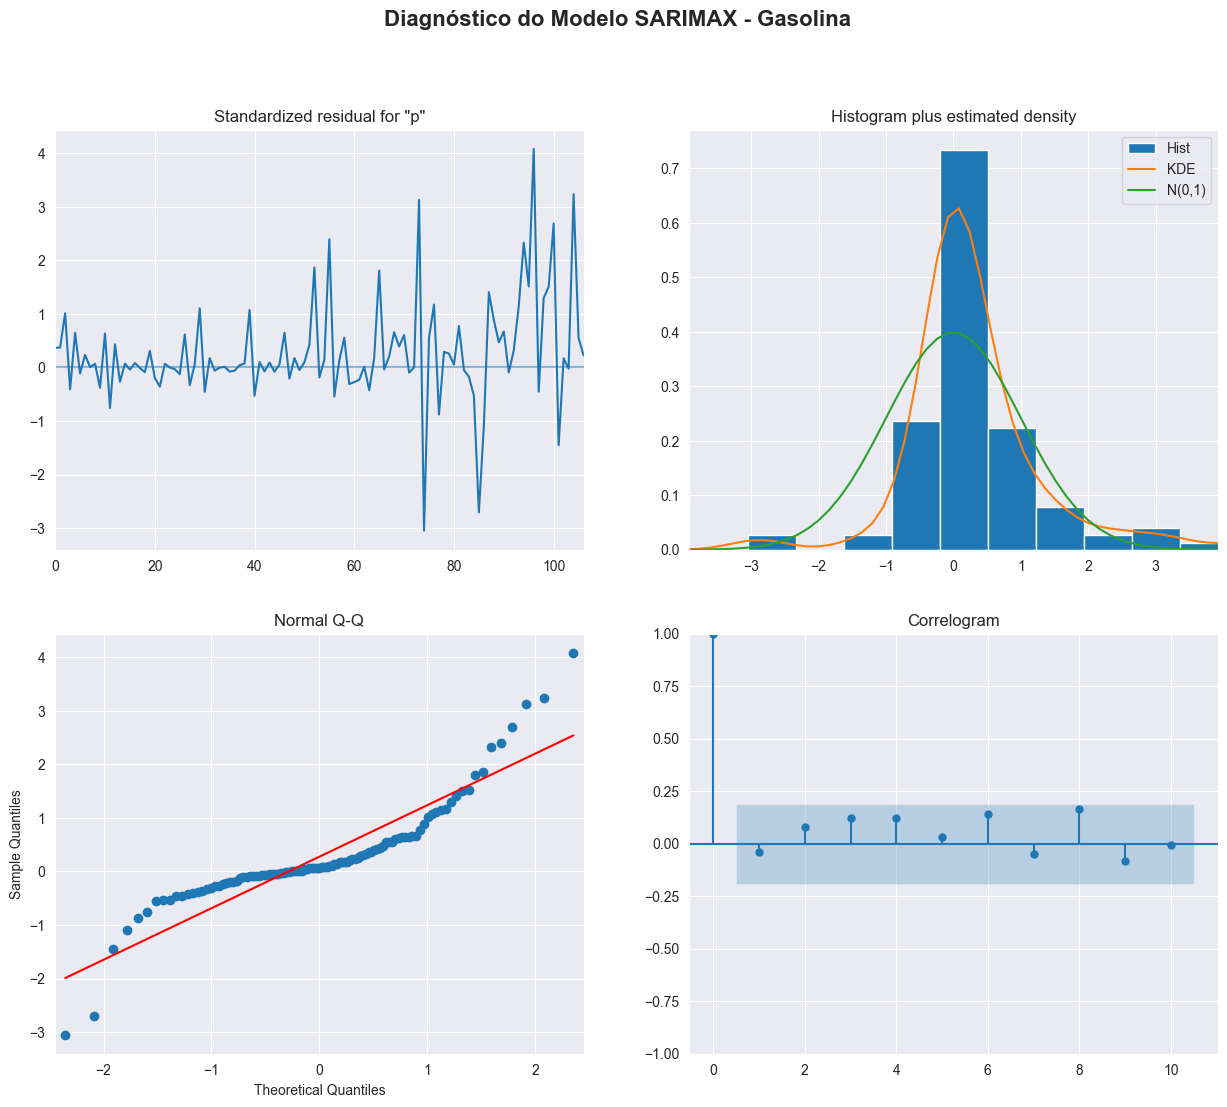


Fazendo previsões para o período de teste...


Métricas de erro:
 - RMSE: 0.29
 - MAE: 0.16
 - MAPE: 2.85%


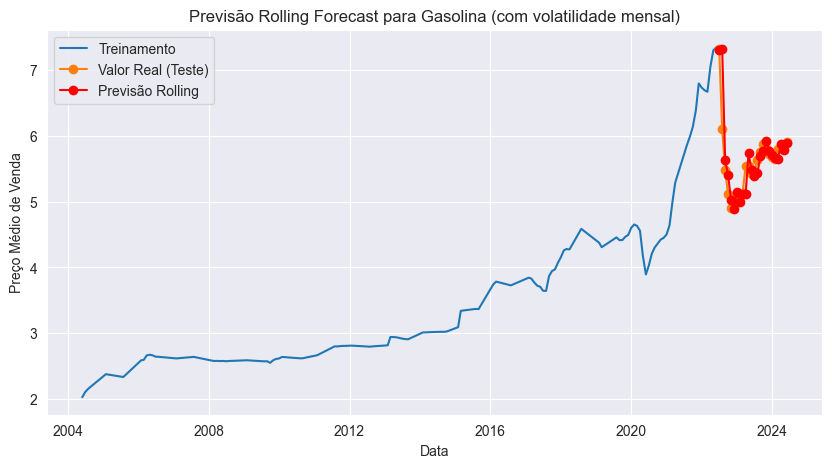


Modelando para Etanol...

Período de treino: 2004-05-31 a 2022-05-31
Período de teste: 2022-06-30 a 2024-05-31

Iniciando busca de hiperparâmetros para SARIMAX...


Melhor modelo encontrado:
SARIMA(0, 1, 1)x(0, 0, 0, 12) - AIC: -151.51

Parâmetros do modelo:
                               SARIMAX Results                                
Dep. Variable:      preco_medio_venda   No. Observations:                  110
Model:               SARIMAX(0, 1, 1)   Log Likelihood                  78.754
Date:                Mon, 17 Feb 2025   AIC                           -151.508
Time:                        09:49:42   BIC                           -143.490
Sample:                             0   HQIC                          -148.258
                                - 110                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
--------------------

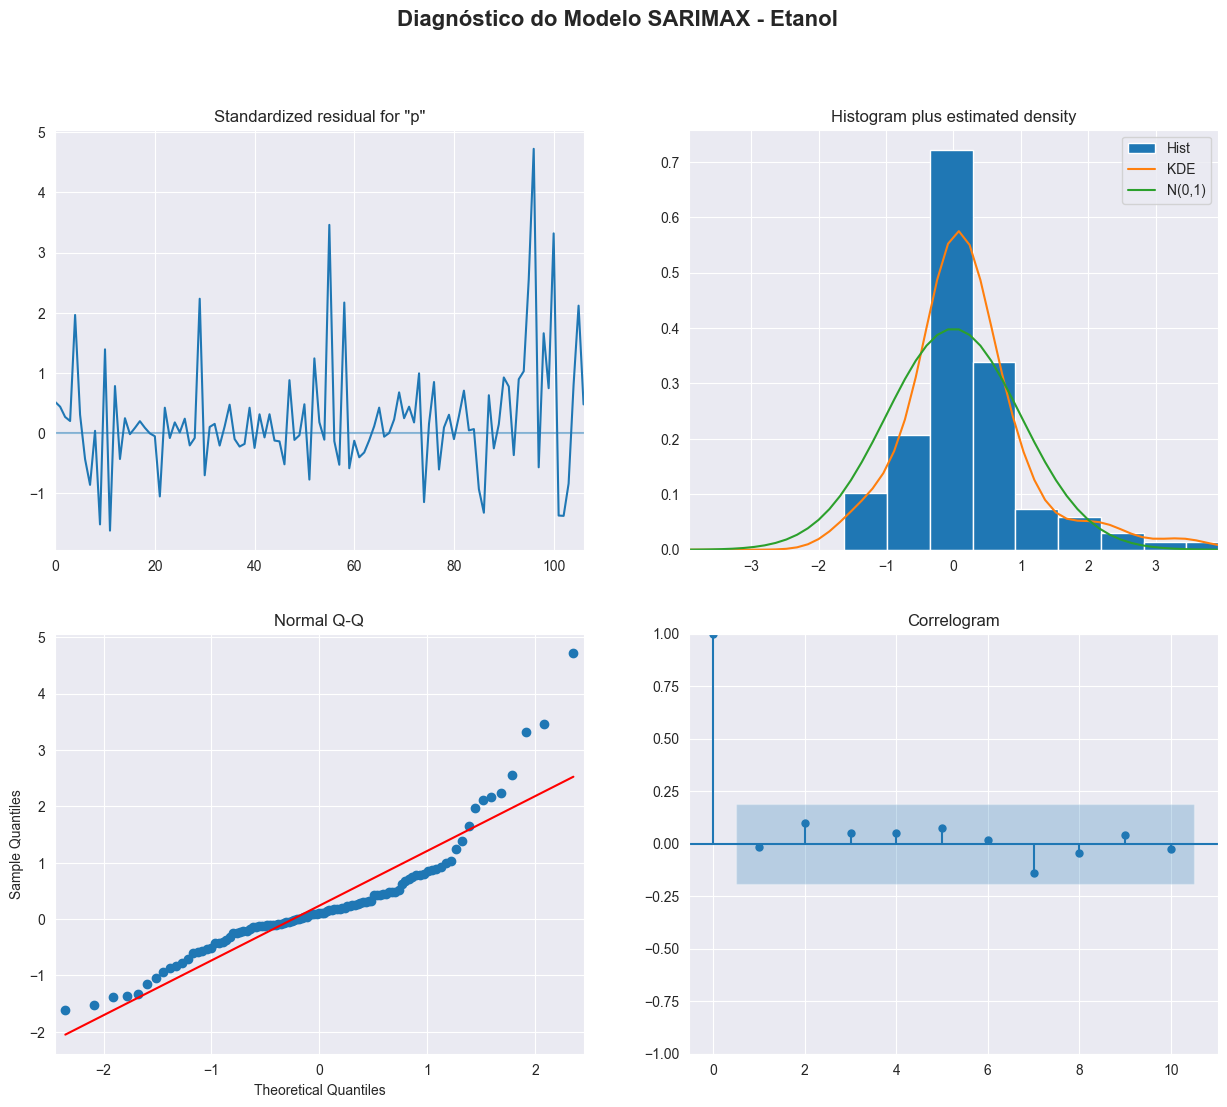


Fazendo previsões para o período de teste...


Métricas de erro:
 - RMSE: 0.14
 - MAE: 0.10
 - MAPE: 2.41%


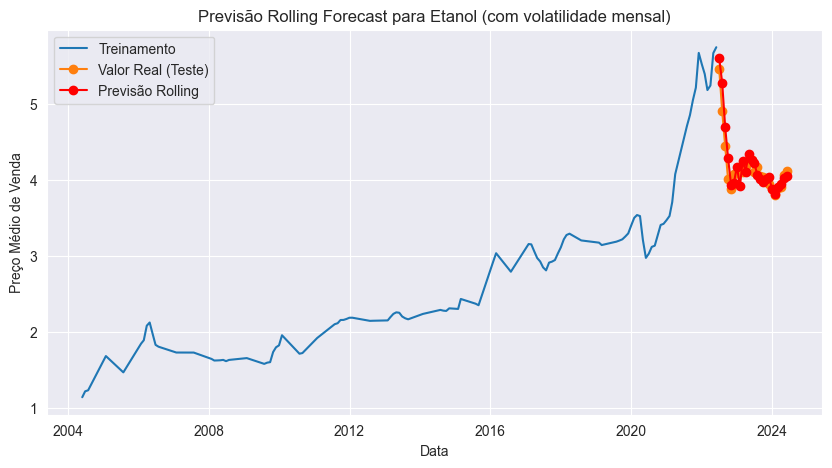


Modelando para Diesel...

Período de treino: 2004-05-31 a 2022-05-31
Período de teste: 2022-06-30 a 2024-05-31

Iniciando busca de hiperparâmetros para SARIMAX...


Melhor modelo encontrado:
SARIMA(0, 1, 1)x(0, 0, 0, 12) - AIC: -168.01

Parâmetros do modelo:
                               SARIMAX Results                                
Dep. Variable:      preco_medio_venda   No. Observations:                  110
Model:               SARIMAX(0, 1, 1)   Log Likelihood                  87.005
Date:                Mon, 17 Feb 2025   AIC                           -168.011
Time:                        09:49:44   BIC                           -159.992
Sample:                             0   HQIC                          -164.760
                                - 110                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
--------------------

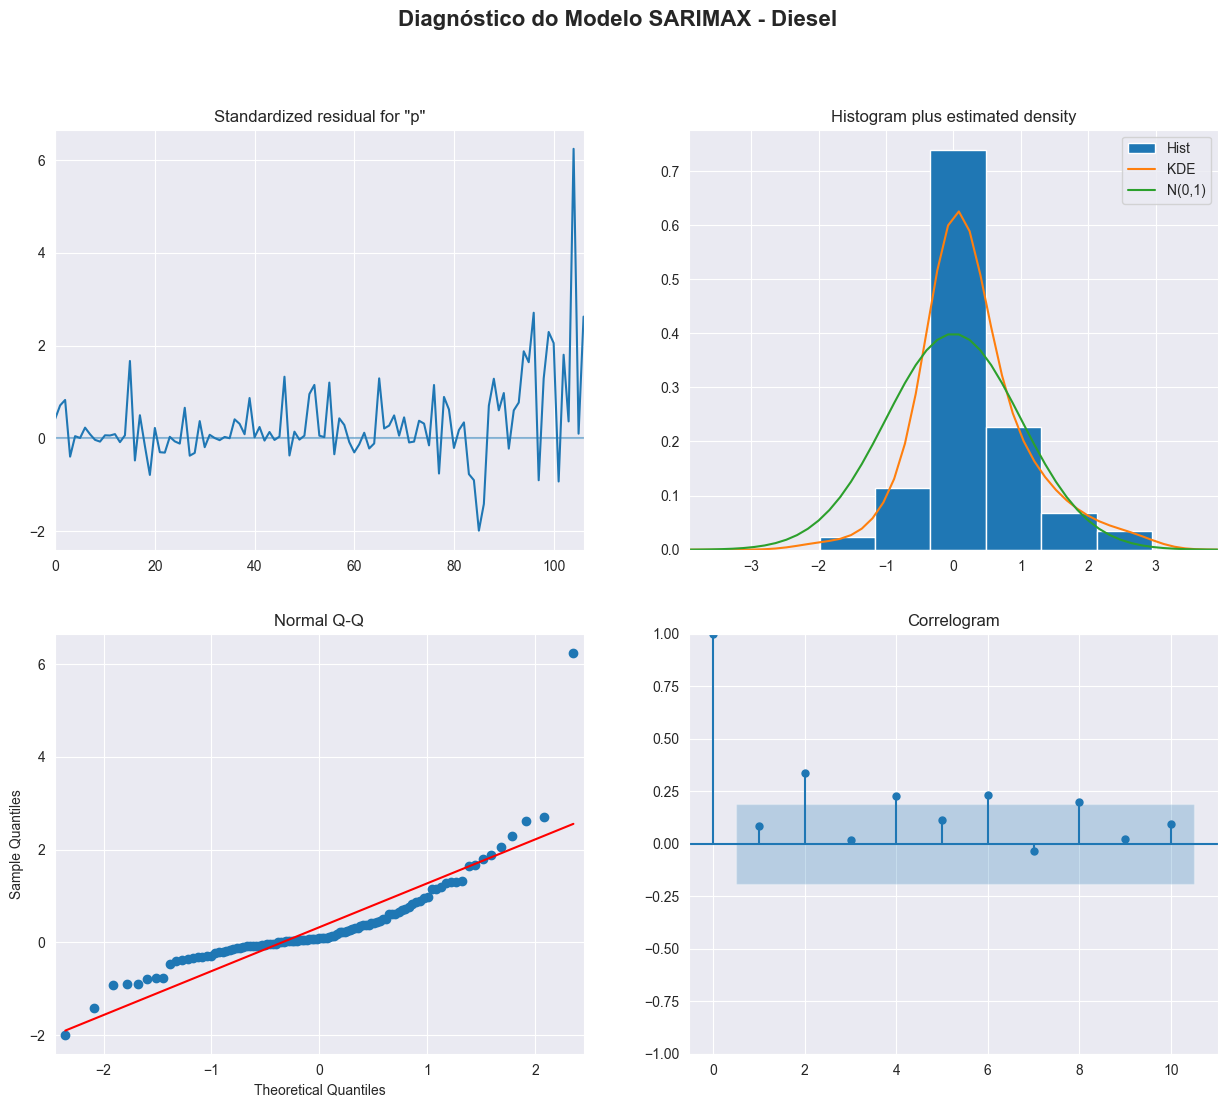


Fazendo previsões para o período de teste...


Métricas de erro:
 - RMSE: 0.23
 - MAE: 0.17
 - MAPE: 2.78%


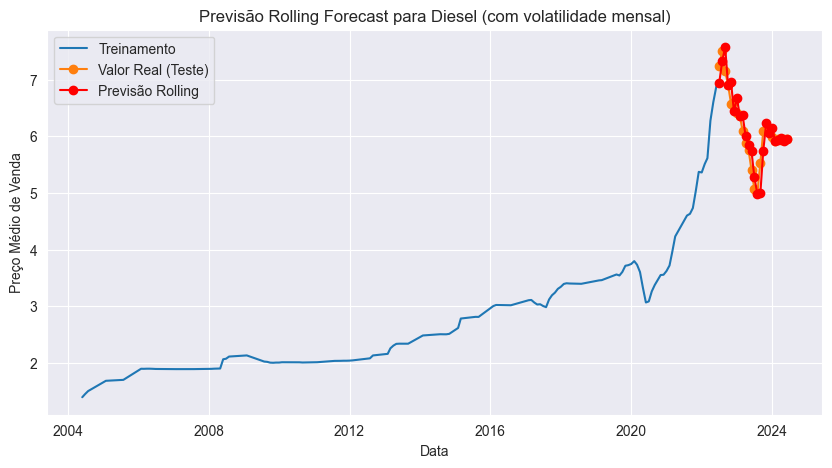


Resumo Final dos Modelos por Produto:

Gasolina:
 - RMSE: 0.29
 - MAE: 0.16
 - MAPE: 2.85%
 - Melhor AIC: -139.33

Etanol:
 - RMSE: 0.14
 - MAE: 0.10
 - MAPE: 2.41%
 - Melhor AIC: -151.51

Diesel:
 - RMSE: 0.23
 - MAE: 0.17
 - MAPE: 2.78%
 - Melhor AIC: -168.01


In [25]:
df = pd.read_csv("../data/data_dol_val.csv")
df['data'] = pd.to_datetime(df['data'])
df = df.set_index('data')


df = df.fillna(method='ffill').fillna(method='bfill')


df['retorno_diario'] = df['avg_preco_venda'].pct_change()
volatilidade_mensal_produto = df.groupby('produto').resample('M')['retorno_diario'].std()
vol_df = volatilidade_mensal_produto.reset_index()
vol_df.rename(columns={'retorno_diario': 'volatilidade_mensal'}, inplace=True)

produtos = ["Gasolina", "Etanol", "Diesel"]
resultados = {}

for produto in produtos:
    print(f"\nModelando para {produto}...\n")

    df_produto = df[df['produto'] == produto]

    ts = df_produto['avg_preco_venda'].resample('M').mean().asfreq('M')
    ts_clean = ts.dropna()

    df_model = ts_clean.reset_index()
    df_model.rename(columns={'avg_preco_venda': 'preco_medio_venda'}, inplace=True)

    df_model = pd.merge(df_model, vol_df[vol_df['produto'] == produto], on='data', how='left')


    df_model['volatilidade_mensal'] = df_model['volatilidade_mensal'].fillna(method='ffill').fillna(method='bfill')


    ts_clean = df_model.set_index('data')['preco_medio_venda']
    vol_series = df_model.set_index('data')['volatilidade_mensal']

    train_end = '2022-05-31'
    ts_train = ts_clean.loc[:train_end]
    ts_test = ts_clean.loc['2022-06-01':'2024-05-31']

    vol_train = vol_series.loc[:train_end]
    vol_test = vol_series.loc['2022-06-01':'2024-05-31']

    print(f"Período de treino: {ts_train.index.min().date()} a {ts_train.index.max().date()}")
    print(f"Período de teste: {ts_test.index.min().date()} a {ts_test.index.max().date()}")

    p = [0]
    d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(0, x[0], x[1], 12) for x in itertools.product(range(0, 2), range(0, 2))]

    lowest_aic = np.inf
    best_pdq = None
    best_seasonal_pdq = None
    best_model = None

    print("\nIniciando busca de hiperparâmetros para SARIMAX...\n")
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = SARIMAX(ts_train, order=param, seasonal_order=param_seasonal,
                              exog=vol_train, enforce_stationarity=False, enforce_invertibility=False)
                results = mod.fit(disp=False)
                if results.aic < lowest_aic:
                    lowest_aic = results.aic
                    best_pdq = param
                    best_seasonal_pdq = param_seasonal
                    best_model = results
            except Exception as e:
                continue

    if best_model is None:
        print("Nenhum modelo válido foi encontrado na busca de hiperparâmetros.")
        continue

    print("\nMelhor modelo encontrado:")
    print(f"SARIMA{best_pdq}x{best_seasonal_pdq} - AIC: {lowest_aic:.2f}")
    print("\nParâmetros do modelo:")
    print(best_model.summary())

    best_model.plot_diagnostics(figsize=(15, 12))
    plt.suptitle(f"Diagnóstico do Modelo SARIMAX - {produto}", fontsize=16, fontweight="bold")
    plt.show()

    print("\nFazendo previsões para o período de teste...\n")
    rolling_forecasts = []
    history = ts_train.copy()
    vol_history = vol_train.copy()

    for t in ts_test.index:
        model = SARIMAX(history, order=best_pdq, seasonal_order=best_seasonal_pdq,
                        exog=vol_history, enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False)
        forecast = model_fit.get_forecast(steps=1, exog=vol_test.loc[[t]])
        yhat = forecast.predicted_mean.iloc[0]
        rolling_forecasts.append(yhat)
        history = pd.concat([history, ts_test.loc[[t]]])
        vol_history = pd.concat([vol_history, vol_test.loc[[t]]])

    rolling_forecasts = pd.Series(rolling_forecasts, index=ts_test.index)

    rmse = np.sqrt(mean_squared_error(ts_test, rolling_forecasts))
    mae = mean_absolute_error(ts_test, rolling_forecasts)
    mape = np.mean(np.abs((ts_test - rolling_forecasts) / ts_test)) * 100

    print("\nMétricas de erro:")
    print(f" - RMSE: {rmse:.2f}")
    print(f" - MAE: {mae:.2f}")
    print(f" - MAPE: {mape:.2f}%")

    plt.figure(figsize=(10, 5))
    plt.plot(ts_train, label='Treinamento')
    plt.plot(ts_test, label='Valor Real (Teste)', marker='o')
    plt.plot(rolling_forecasts.index, rolling_forecasts, label='Previsão Rolling', color='red', marker='o')
    plt.title(f"Previsão Rolling Forecast para {produto} (com volatilidade mensal)")
    plt.xlabel("Data")
    plt.ylabel("Preço Médio de Venda")
    plt.legend()
    plt.grid(True)
    plt.show()

    resultados[produto] = {
        "melhor_modelo": best_model,
        "rmse": rmse,
        "mae": mae,
        "mape": mape,
        "previsoes": rolling_forecasts
    }

print("\nResumo Final dos Modelos por Produto:")
for produto, res in resultados.items():
    print(f"\n{produto}:")
    print(f" - RMSE: {res['rmse']:.2f}")
    print(f" - MAE: {res['mae']:.2f}")
    print(f" - MAPE: {res['mape']:.2f}%")
    print(f" - Melhor AIC: {res['melhor_modelo'].aic:.2f}")

resultados_3 = resultados


# Modelo Escolhido- SARIMA sem Variáveis Exógenas (com exceção do Etanol)

O modelo *baseline* (SARIMA sem variáveis exógenas) foi selecionado como o mais adequado para a análise geral, com base nos seguintes pontos:

1. **Insignificância da Variável `dol_val`**
   - A variável `dol_val` (valor do dólar) não apresentou significância estatística em nenhum dos modelos testados, mesmo após ajustes nos hiperparâmetros.
   - As correlações entre `dol_val` e os resíduos do modelo (AR(1) e AR(2)) foram altas (0,845 e 0,840, respectivamente), indicando que essa variável não contribui para a melhoria do modelo.

2. **Problemas com a Variável `avg_preco_compra`**
   - A variável `avg_preco_compra` (preço médio de compra) também não se mostrou significativa em dois dos três modelos testados.
   - Além disso, apresenta *data leakage* (vazamento de dados), pois utiliza informações futuras que não estariam disponíveis no momento da previsão. Por esse motivo, optou-se por removê-la de todos os modelos.

3. **Capacidade Preditiva do SARIMA**
   - Mesmo sem variáveis exógenas, o modelo SARIMA demonstrou uma boa capacidade preditiva, com métricas de erro satisfatórias (RMSE, MAE e MAPE).
   - Os gráficos de diagnóstico (resíduos, autocorrelação e distribuição) confirmaram um bom ajuste (*good fit*), reforçando a escolha do modelo.

4. **Simplicidade e Robustez**
   - A ausência de variáveis exógenas simplifica o modelo, reduzindo o risco de *overfitting* e facilitando a interpretação dos resultados.
   - Essa simplicidade, aliada à robustez do SARIMA, torna o modelo adequado para previsões futuras.

---

**Adição da Variável `volatilidade_mensal` para Etanol**

Para o produto **etanol**, foi observado que a inclusão da nova variável `volatilidade_mensal`—que representa o desvio padrão dos retornos diários agregados mensalmente—resultou em uma melhoria significativa nas métricas de previsão. Em testes, o modelo para etanol com `volatilidade_mensal` apresentou:

- **RMSE**: Redução de 0.18 para 0.14
- **AIC**: Melhora de -100.44 para -151.51

Essas melhorias sugerem que a volatilidade dos preços captura aspectos importantes do comportamento do etanol, possivelmente devido à dinâmica específica desse combustível (como incentivos governamentais e variações na oferta e demanda) que afetam sua estabilidade. Portanto, a `volatilidade_mensal` foi adicionada **apenas ao modelo para etanol**, enquanto para gasolina e diesel o modelo baseline sem variáveis exógenas já apresenta desempenho robusto.

---

**Conclusão:**
A estratégia adotada consiste em manter o modelo baseline para gasolina e diesel, onde a inclusão de variáveis exógenas não demonstrou ganhos significativos, e incorporar a `volatilidade_mensal` exclusivamente para etanol, pois ela agrega valor preditivo e melhora consideravelmente as métricas do modelo.



Modelando para Gasolina...

Período de treino: 2004-05-31 a 2022-05-31
Período de teste: 2022-06-30 a 2024-05-31
Teste de Dickey-Fuller para Gasolina:
 - Estatística ADF: -1.1033
 - p-valor: 0.7138
 - Série não estacionária, pode precisar de diferenciação

Iniciando busca de hiperparâmetros para SARIMAX...


Melhor modelo encontrado:
SARIMA(2, 0, 0)x(0, 0, 0, 12) - AIC: -144.82

Parâmetros do modelo:
                               SARIMAX Results                                
Dep. Variable:      preco_medio_venda   No. Observations:                  110
Model:               SARIMAX(2, 0, 0)   Log Likelihood                  75.409
Date:                Mon, 17 Feb 2025   AIC                           -144.819
Time:                        09:52:43   BIC                           -136.773
Sample:                             0   HQIC                          -141.556
                                - 110                                         
Covariance Type:                  opg     

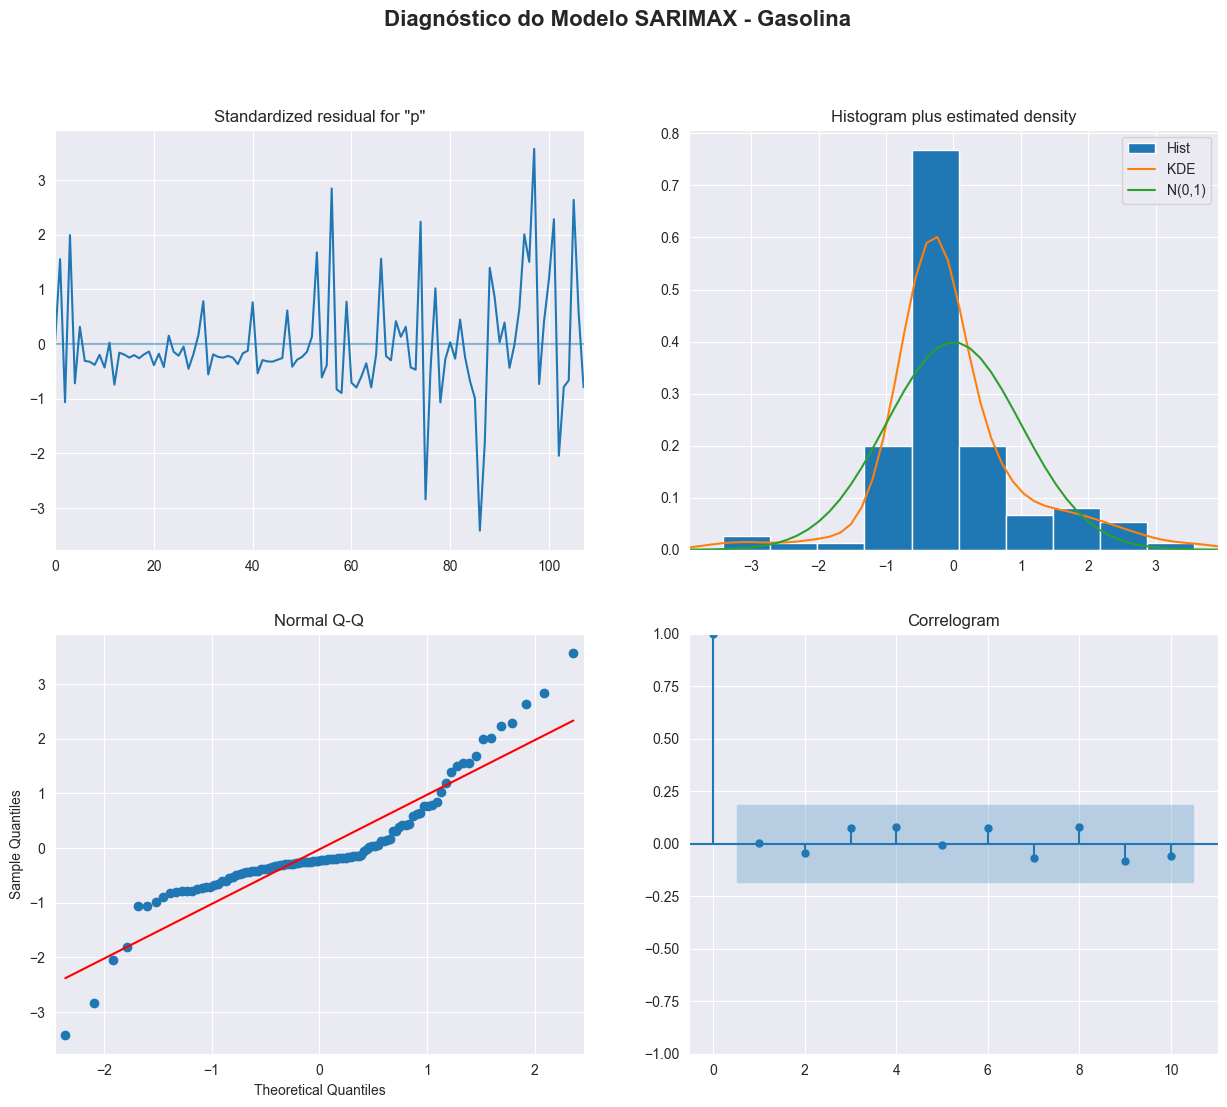


Fazendo previsões para o período de teste...


Métricas de erro:
 - RMSE: 0.30
 - MAE: 0.16
 - MAPE: 2.73%


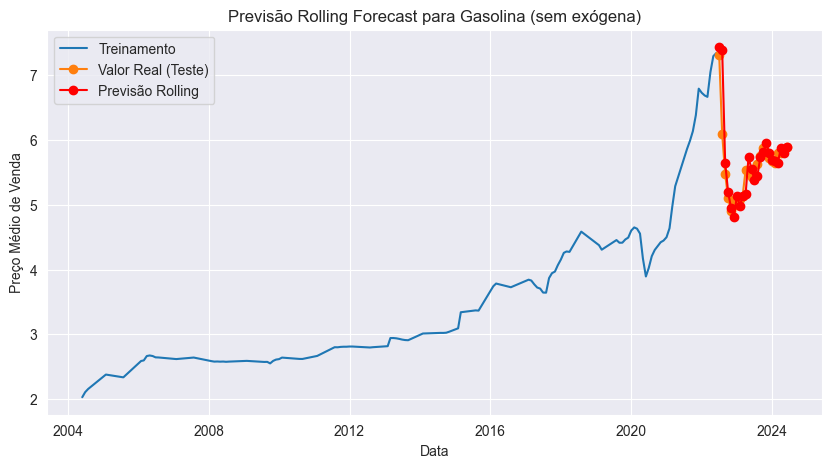


Modelando para Etanol...

Período de treino: 2004-05-31 a 2022-05-31
Período de teste: 2022-06-30 a 2024-05-31
Teste de Dickey-Fuller para Etanol:
 - Estatística ADF: -1.4024
 - p-valor: 0.5811
 - Série não estacionária, pode precisar de diferenciação

Iniciando busca de hiperparâmetros para SARIMAX...


Melhor modelo encontrado:
SARIMA(2, 0, 0)x(0, 0, 0, 12) - AIC: -160.57

Parâmetros do modelo:
                               SARIMAX Results                                
Dep. Variable:      preco_medio_venda   No. Observations:                  110
Model:               SARIMAX(2, 0, 0)   Log Likelihood                  84.286
Date:                Mon, 17 Feb 2025   AIC                           -160.573
Time:                        09:56:38   BIC                           -149.844
Sample:                             0   HQIC                          -156.223
                                - 110                                         
Covariance Type:                  opg         

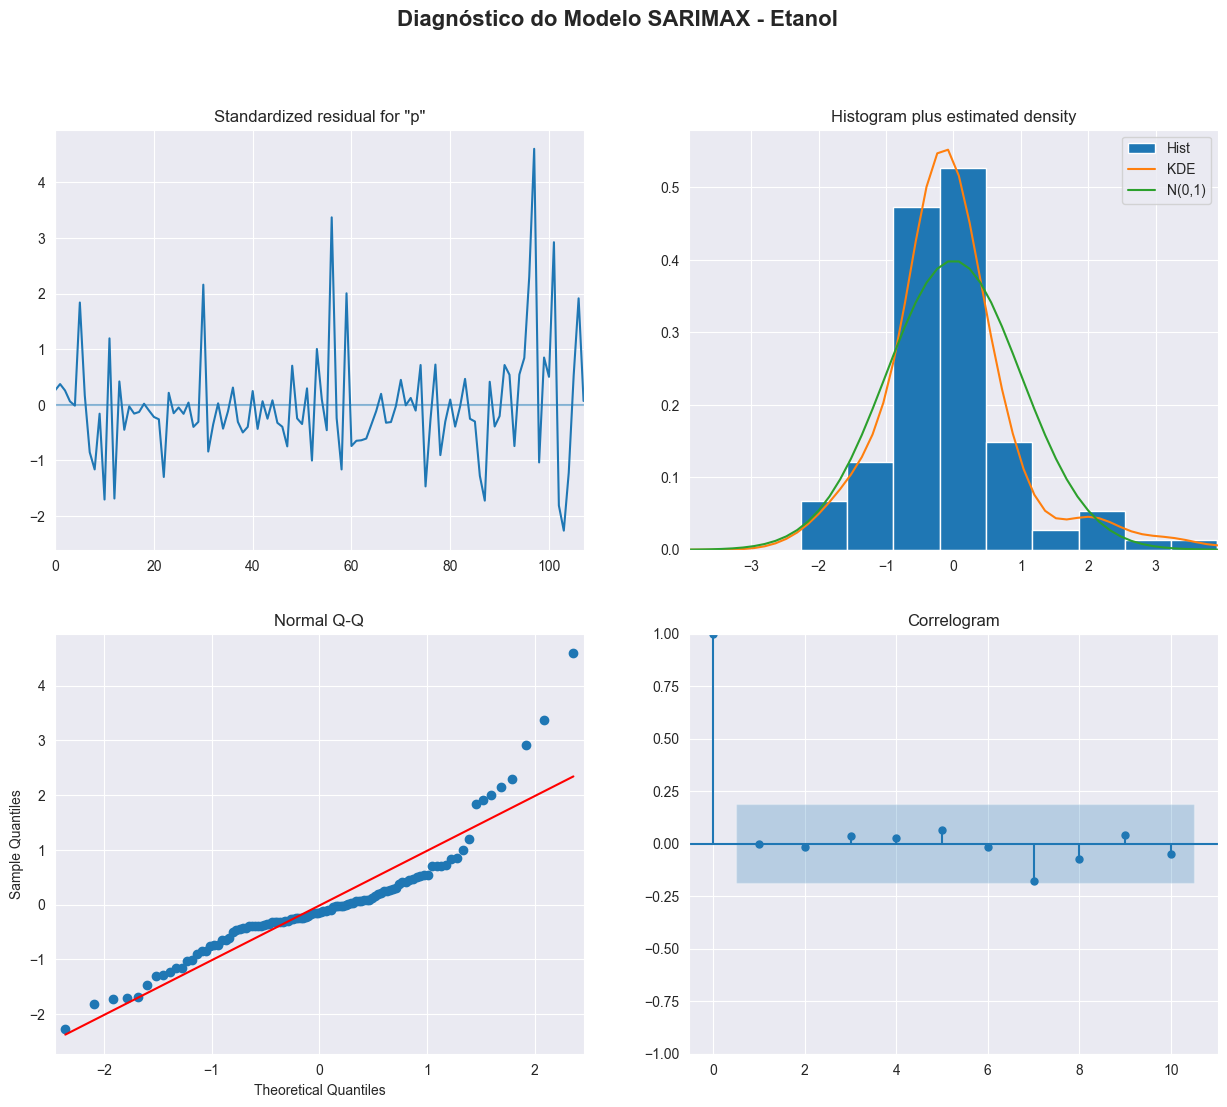


Fazendo previsões para o período de teste...


Métricas de erro:
 - RMSE: 0.15
 - MAE: 0.11
 - MAPE: 2.44%


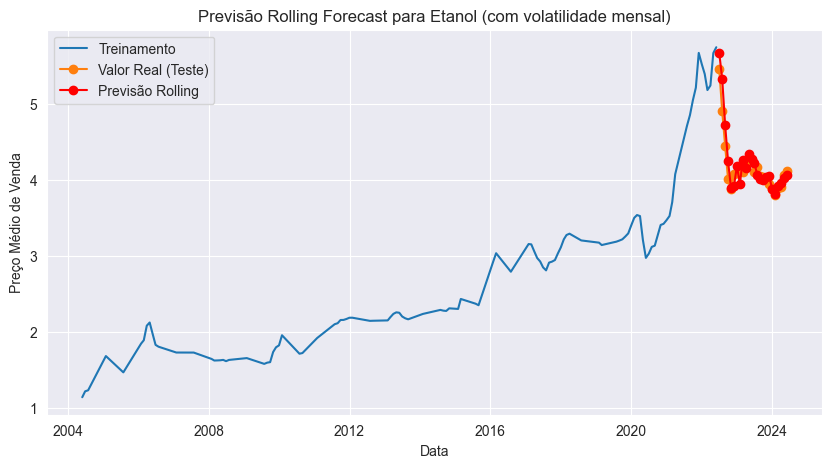


Modelando para Diesel...

Período de treino: 2004-05-31 a 2022-05-31
Período de teste: 2022-06-30 a 2024-05-31
Teste de Dickey-Fuller para Diesel:
 - Estatística ADF: -0.8215
 - p-valor: 0.8127
 - Série não estacionária, pode precisar de diferenciação

Iniciando busca de hiperparâmetros para SARIMAX...


Melhor modelo encontrado:
SARIMA(2, 0, 0)x(0, 0, 0, 12) - AIC: -191.40

Parâmetros do modelo:
                               SARIMAX Results                                
Dep. Variable:      preco_medio_venda   No. Observations:                  110
Model:               SARIMAX(2, 0, 0)   Log Likelihood                  98.701
Date:                Mon, 17 Feb 2025   AIC                           -191.403
Time:                        09:59:52   BIC                           -183.357
Sample:                             0   HQIC                          -188.140
                                - 110                                         
Covariance Type:                  opg         

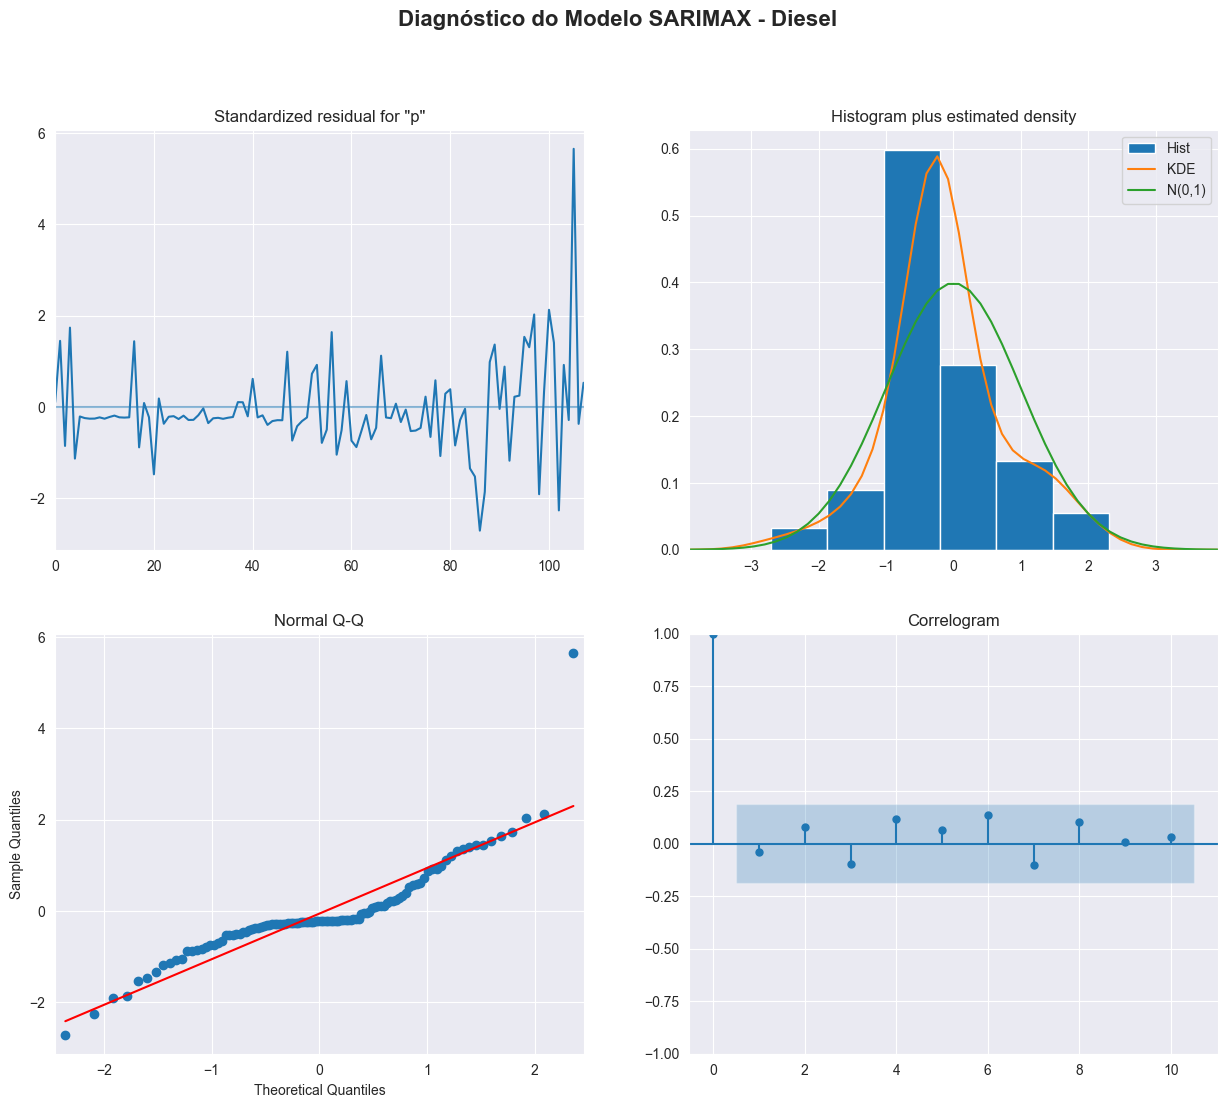


Fazendo previsões para o período de teste...


Métricas de erro:
 - RMSE: 0.23
 - MAE: 0.17
 - MAPE: 2.77%


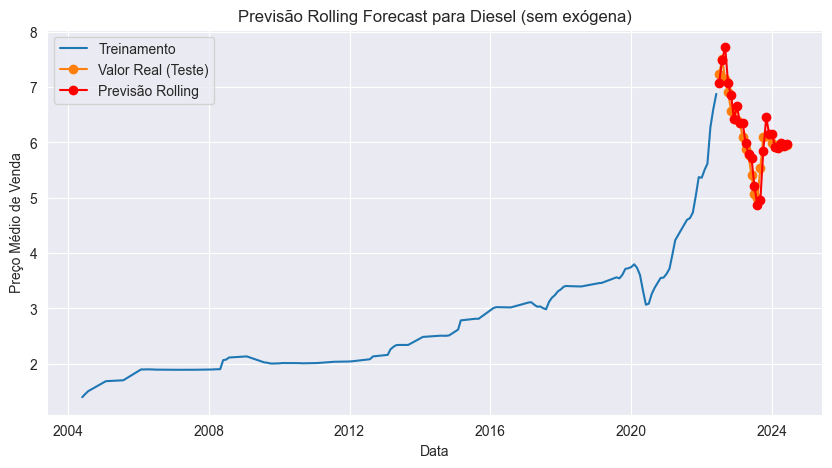


Resumo Final dos Modelos por Produto:

Gasolina:
 - RMSE: 0.30
 - MAE: 0.16
 - MAPE: 2.73%
 - Melhor AIC: -144.82

Etanol:
 - RMSE: 0.15
 - MAE: 0.11
 - MAPE: 2.44%
 - Melhor AIC: -160.57

Diesel:
 - RMSE: 0.23
 - MAE: 0.17
 - MAPE: 2.77%
 - Melhor AIC: -191.40

Modelos salvos em 'modelos_sarimax/modelos_sarimax_vol.joblib'


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib
import warnings
warnings.filterwarnings("ignore")


df = pd.read_csv("../data/data_dol_val.csv")
df['data'] = pd.to_datetime(df['data'])
df = df.set_index('data')

df = df.fillna(method='ffill').fillna(method='bfill')


df['retorno_diario'] = df['avg_preco_venda'].pct_change()
volatilidade_mensal_produto = df.groupby('produto').resample('M')['retorno_diario'].std()
vol_df = volatilidade_mensal_produto.reset_index()
vol_df.rename(columns={'retorno_diario': 'volatilidade_mensal'}, inplace=True)

produtos = ["Gasolina", "Etanol", "Diesel"]
resultados = {}

for produto in produtos:
    print(f"\nModelando para {produto}...\n")

    df_produto = df[df['produto'] == produto]

    ts = df_produto['avg_preco_venda'].resample('M').mean().asfreq('M')
    ts_clean = ts.dropna()

    df_model = ts_clean.reset_index()
    df_model.rename(columns={'avg_preco_venda': 'preco_medio_venda'}, inplace=True)

    df_model = pd.merge(df_model, vol_df[vol_df['produto'] == produto], on='data', how='left')
    df_model['volatilidade_mensal'] = df_model['volatilidade_mensal'].fillna(method='ffill').fillna(method='bfill')

    ts_clean = df_model.set_index('data')['preco_medio_venda']
    if produto == "Etanol":
        exog_series = df_model.set_index('data')['volatilidade_mensal']
    else:
        exog_series = None

    train_end = '2022-05-31'
    ts_train = ts_clean.loc[:train_end]
    ts_test = ts_clean.loc['2022-06-01':'2024-05-31']

    if exog_series is not None:
        exog_train = exog_series.loc[:train_end]
        exog_test = exog_series.loc['2022-06-01':'2024-05-31']
    else:
        exog_train = None
        exog_test = None

    print(f"Período de treino: {ts_train.index.min().date()} a {ts_train.index.max().date()}")
    print(f"Período de teste: {ts_test.index.min().date()} a {ts_test.index.max().date()}")

    # Stationarity test
    resultado_adf = adfuller(ts_clean)
    print(f"Teste de Dickey-Fuller para {produto}:")
    print(f" - Estatística ADF: {resultado_adf[0]:.4f}")
    print(f" - p-valor: {resultado_adf[1]:.4f}")
    print(" - Série considerada estacionária" if resultado_adf[1] < 0.05
          else " - Série não estacionária, pode precisar de diferenciação")

    ts_diff = ts_clean.diff().dropna() if resultado_adf[1] > 0.05 else ts_clean

    p = d = q = range(0, 3)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in itertools.product(range(0, 3), range(0, 3), range(0, 3))]

    lowest_aic = np.inf
    best_pdq = None
    best_seasonal_pdq = None
    best_model = None

    print("\nIniciando busca de hiperparâmetros para SARIMAX...\n")
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                if exog_train is not None:
                    mod = SARIMAX(ts_train, order=param, seasonal_order=param_seasonal,
                                  exog=exog_train, enforce_stationarity=False, enforce_invertibility=False)
                else:
                    mod = SARIMAX(ts_train, order=param, seasonal_order=param_seasonal,
                                  enforce_stationarity=False, enforce_invertibility=False)
                results_mod = mod.fit(disp=False)
                if results_mod.aic < lowest_aic:
                    lowest_aic = results_mod.aic
                    best_pdq = param
                    best_seasonal_pdq = param_seasonal
                    best_model = results_mod
            except Exception as e:
                continue

    if best_model is None:
        print("Nenhum modelo válido foi encontrado na busca de hiperparâmetros.")
        continue

    print("\nMelhor modelo encontrado:")
    print(f"SARIMA{best_pdq}x{best_seasonal_pdq} - AIC: {lowest_aic:.2f}")
    print("\nParâmetros do modelo:")
    print(best_model.summary())

    best_model.plot_diagnostics(figsize=(15, 12))
    plt.suptitle(f"Diagnóstico do Modelo SARIMAX - {produto}", fontsize=16, fontweight="bold")
    plt.show()

    print("\nFazendo previsões para o período de teste...\n")
    rolling_forecasts = []
    history = ts_train.copy()
    if exog_train is not None:
        exog_history = exog_train.copy()
    else:
        exog_history = None

    for t in ts_test.index:
        if exog_history is not None:
            model = SARIMAX(history, order=best_pdq, seasonal_order=best_seasonal_pdq,
                            exog=exog_history, enforce_stationarity=False, enforce_invertibility=False)
        else:
            model = SARIMAX(history, order=best_pdq, seasonal_order=best_seasonal_pdq,
                            enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False)
        if exog_test is not None:
            forecast = model_fit.get_forecast(steps=1, exog=exog_test.loc[[t]])
        else:
            forecast = model_fit.get_forecast(steps=1)
        yhat = forecast.predicted_mean.iloc[0]
        rolling_forecasts.append(yhat)
        history = pd.concat([history, ts_test.loc[[t]]])
        if exog_history is not None:
            exog_history = pd.concat([exog_history, exog_test.loc[[t]]])

    rolling_forecasts = pd.Series(rolling_forecasts, index=ts_test.index)

    rmse = np.sqrt(mean_squared_error(ts_test, rolling_forecasts))
    mae = mean_absolute_error(ts_test, rolling_forecasts)
    mape = np.mean(np.abs((ts_test - rolling_forecasts) / ts_test)) * 100

    print("\nMétricas de erro:")
    print(f" - RMSE: {rmse:.2f}")
    print(f" - MAE: {mae:.2f}")
    print(f" - MAPE: {mape:.2f}%")

    plt.figure(figsize=(10, 5))
    plt.plot(ts_train, label='Treinamento')
    plt.plot(ts_test, label='Valor Real (Teste)', marker='o')
    plt.plot(rolling_forecasts.index, rolling_forecasts, label='Previsão Rolling', color='red', marker='o')
    if produto == "Etanol":
        title_exog = "com volatilidade mensal"
    else:
        title_exog = "sem exógena"
    plt.title(f"Previsão Rolling Forecast para {produto} ({title_exog})")
    plt.xlabel("Data")
    plt.ylabel("Preço Médio de Venda")
    plt.legend()
    plt.grid(True)
    plt.show()

    resultados[produto] = {
        "metricas": {
            "rmse": rmse,
            "mae": mae,
            "mape": mape
        },
        "best_params": {
            "order": best_pdq,
            "seasonal_order": best_seasonal_pdq,
            "aic": lowest_aic
        },
        "best_model": best_model,
        "previsoes": rolling_forecasts
    }

print("\nResumo Final dos Modelos por Produto:")
for produto, res in resultados.items():
    print(f"\n{produto}:")
    print(f" - RMSE: {res['metricas']['rmse']:.2f}")
    print(f" - MAE: {res['metricas']['mae']:.2f}")
    print(f" - MAPE: {res['metricas']['mape']:.2f}%")
    print(f" - Melhor AIC: {res['best_params']['aic']:.2f}")

joblib.dump(resultados, "modelos_sarimax/modelos_sarimax_vol.joblib")
print("\nModelos salvos em 'modelos_sarimax/modelos_sarimax_vol.joblib'")


## Predição dos Valores Junho, Julho e Agosto


Processing forecasts for Gasolina...

Training period: 2004-05-31 to 2024-05-31
Test period: 2024-06-30 to 2024-08-31

Forecast comparison for Gasolina:
                Real  Predicted
data                           
2024-06-30  5.894257   6.203392
2024-07-31  6.076869   6.240690
2024-08-31  6.154232   6.273043


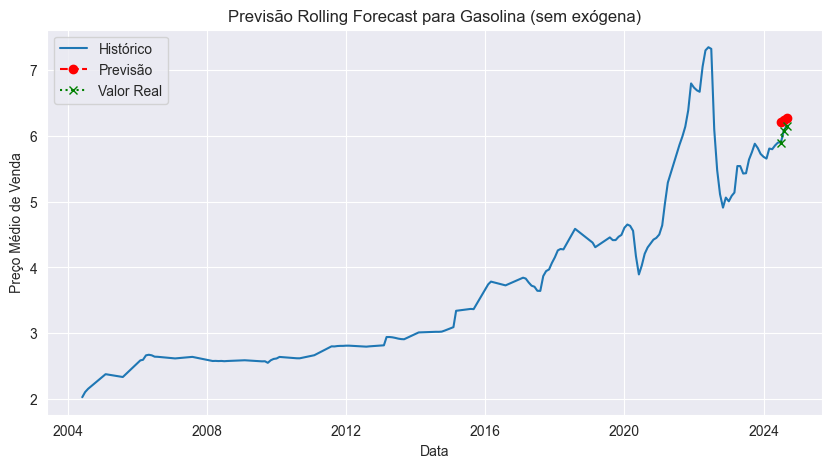


Métricas de erro for forecast period:
 - RMSE: 0.21
 - MAE: 0.20
 - MAPE: 3.29%

Processing forecasts for Etanol...

Training period: 2004-05-31 to 2024-05-31
Test period: 2024-06-30 to 2024-08-31

Forecast comparison for Etanol:
                Real  Predicted
data                           
2024-06-30  4.116883   4.336960
2024-07-31  4.280562   4.446093
2024-08-31  4.357560   4.462146


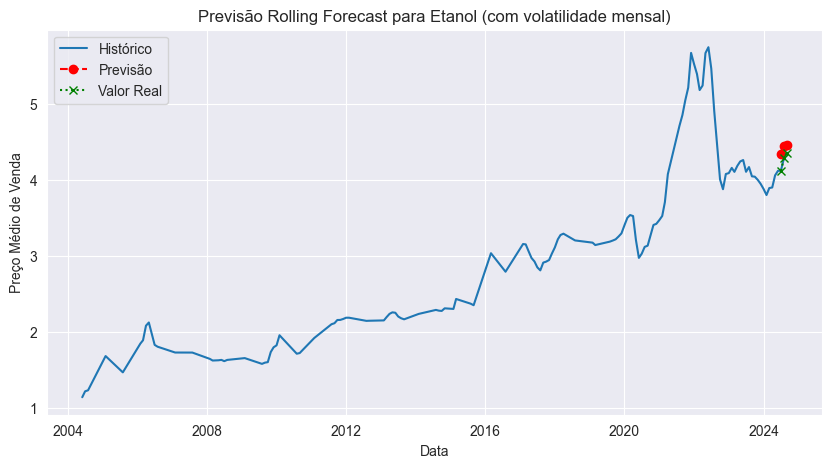


Métricas de erro for forecast period:
 - RMSE: 0.17
 - MAE: 0.16
 - MAPE: 3.87%

Processing forecasts for Diesel...

Training period: 2004-05-31 to 2024-05-31
Test period: 2024-06-30 to 2024-08-31

Forecast comparison for Diesel:
                Real  Predicted
data                           
2024-06-30  5.941602   6.035147
2024-07-31  6.001260   6.062744
2024-08-31  6.013096   6.093393


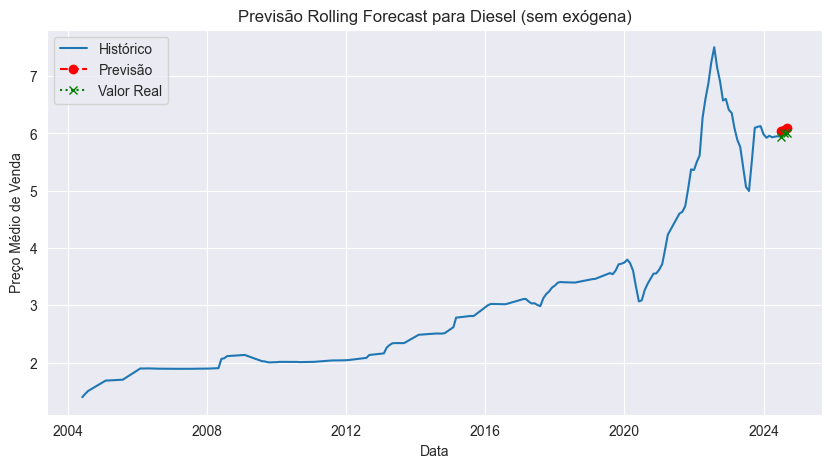


Métricas de erro for forecast period:
 - RMSE: 0.08
 - MAE: 0.08
 - MAPE: 1.31%

Resumo dos Indicadores de Forecast (Real vs. Predito):
    Produto      RMSE       MAE  MAPE (%)
0  Gasolina  0.213322  0.197256  3.290359
1    Etanol  0.170071  0.163398  3.870955
2    Diesel  0.079537  0.078442  1.311432

Modelos e previsões salvos em 'modelos_sarimax/modelos_sarimax_vol_forecasts.joblib'


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import joblib
import warnings
warnings.filterwarnings("ignore")

resultados = joblib.load("modelos_sarimax/modelos_sarimax_vol.joblib")

df = pd.read_csv("../data/data_dol_val.csv")
df['data'] = pd.to_datetime(df['data'])
df = df.set_index('data')
df = df.fillna(method='ffill').fillna(method='bfill')

# Compute daily returns and monthly volatility for each product
df['retorno_diario'] = df['avg_preco_venda'].pct_change()
volatilidade_mensal_produto = df.groupby('produto').resample('M')['retorno_diario'].std()
vol_df = volatilidade_mensal_produto.reset_index()
vol_df.rename(columns={'retorno_diario': 'volatilidade_mensal'}, inplace=True)

produtos = ["Gasolina", "Etanol", "Diesel"]
forecast_tables = {}
summary_list = []

for produto in produtos:
    print(f"\nProcessing forecasts for {produto}...\n")

    df_produto = df[df['produto'] == produto]

    ts = df_produto['avg_preco_venda'].resample('M').mean().asfreq('M')
    ts_clean = ts.dropna()


    df_model = ts_clean.reset_index()
    df_model.rename(columns={'avg_preco_venda': 'preco_medio_venda'}, inplace=True)
    df_model = pd.merge(df_model, vol_df[vol_df['produto'] == produto], on='data', how='left')
    if produto == "Etanol":
        df_model['volatilidade_mensal'] = df_model['volatilidade_mensal'].fillna(method='ffill').fillna(method='bfill')

    ts_series = df_model.set_index('data')['preco_medio_venda']
    if produto == "Etanol":
        exog_series = df_model.set_index('data')['volatilidade_mensal']
    else:
        exog_series = None


    train_end = '2024-05-31'
    ts_train = ts_series.loc[:train_end]
    ts_test = ts_series.loc['2024-06-01':'2024-08-31']

    if exog_series is not None:
        exog_train = exog_series.loc[:train_end]
        exog_test = exog_series.loc['2024-06-01':'2024-08-31']

        exog_test = exog_test.reindex(ts_test.index).fillna(method='ffill').fillna(method='bfill')
    else:
        exog_train = None
        exog_test = None

    print(f"Training period: {ts_train.index.min().date()} to {ts_train.index.max().date()}")
    print(f"Test period: {ts_test.index.min().date()} to {ts_test.index.max().date()}")

    if produto not in resultados:
        print(f"No saved model for {produto}; skipping forecast.")
        continue
    best_params = resultados[produto]["best_params"]
    best_pdq = best_params["order"]
    best_seasonal_pdq = best_params["seasonal_order"]

    forecast_dates = ts_test.index[-3:]

    # Extract real values for these forecast dates
    real_values = ts_series.reindex(forecast_dates)

    if exog_series is not None:
        exog_forecast = exog_series.reindex(forecast_dates).fillna(method='ffill').fillna(method='bfill')
    else:
        exog_forecast = None

    history = ts_series.copy()
    if exog_train is not None:
        exog_history = exog_series.copy()
    else:
        exog_history = None

    forecasts = []
    for t in forecast_dates:
        if exog_history is not None:
            model = SARIMAX(history, order=best_pdq, seasonal_order=best_seasonal_pdq,
                            exog=exog_history, enforce_stationarity=False, enforce_invertibility=False)
        else:
            model = SARIMAX(history, order=best_pdq, seasonal_order=best_seasonal_pdq,
                            enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False)
        if exog_forecast is not None:
            fcst = model_fit.get_forecast(steps=1, exog=exog_forecast.loc[[t]])
        else:
            fcst = model_fit.get_forecast(steps=1)
        yhat = fcst.predicted_mean.iloc[0]
        forecasts.append(yhat)
        history = pd.concat([history, pd.Series([yhat], index=[t])])
        if exog_history is not None:

            exog_history = pd.concat([exog_history, exog_forecast.loc[[t]]])

    forecast_series = pd.Series(forecasts, index=forecast_dates)

    comparison_df = pd.DataFrame({
        "Real": ts_series.reindex(forecast_dates),
        "Predicted": forecast_series
    }, index=forecast_dates)

    print(f"\nForecast comparison for {produto}:")
    print(comparison_df)

    plt.figure(figsize=(10, 5))
    plt.plot(ts_series, label="Histórico")
    plt.plot(forecast_series.index, forecast_series, label="Previsão", marker="o", linestyle="--", color="red")
    plt.plot(comparison_df.index, comparison_df["Real"], label="Valor Real", marker="x", linestyle=":", color="green")
    if produto == "Etanol":
        title_exog = "com volatilidade mensal"
    else:
        title_exog = "sem exógena"
    plt.title(f"Previsão Rolling Forecast para {produto} ({title_exog})")
    plt.xlabel("Data")
    plt.ylabel("Preço Médio de Venda")
    plt.legend()
    plt.grid(True)
    plt.show()

    common_idx = ts_test.index.intersection(forecast_series.index)
    rmse = np.sqrt(np.mean((ts_test.reindex(common_idx) - forecast_series.reindex(common_idx))**2))
    mae = np.mean(np.abs(ts_test.reindex(common_idx) - forecast_series.reindex(common_idx)))
    mape = np.mean(np.abs((ts_test.reindex(common_idx) - forecast_series.reindex(common_idx)) / ts_test.reindex(common_idx))) * 100

    print("\nMétricas de erro for forecast period:")
    print(f" - RMSE: {rmse:.2f}")
    print(f" - MAE: {mae:.2f}")
    print(f" - MAPE: {mape:.2f}%")

    resultados[produto]["previsoes_futuras"] = forecast_series
    resultados[produto]["comparison_df"] = comparison_df
    resultados[produto]["forecast_metrics"] = {"rmse": rmse, "mae": mae, "mape": mape}

    forecast_tables[produto] = comparison_df


summary_list = []
for produto, res in resultados.items():
    if "forecast_metrics" in res:
        summary_list.append({
            "Produto": produto,
            "RMSE": res["forecast_metrics"]["rmse"],
            "MAE": res["forecast_metrics"]["mae"],
            "MAPE (%)": res["forecast_metrics"]["mape"]
        })
summary_df = pd.DataFrame(summary_list)
print("\nResumo dos Indicadores de Forecast (Real vs. Predito):")
print(summary_df)

joblib.dump(resultados, "modelos_sarimax/modelos_sarimax_vol_forecasts.joblib")
print("\nModelos e previsões salvos em 'modelos_sarimax/modelos_sarimax_vol_forecasts.joblib'")


# Conclusão
Os resultados apresentados demonstram que os modelos desenvolvidos para prever os preços médios de venda dos combustíveis (Gasolina, Etanol e Diesel) funcionam de maneira satisfatória, atingindo erros relativamente baixos e, consequentemente, oferecendo previsões consistentes para os períodos futuros.

Para cada produto, foram definidos períodos de treinamento e teste, e aplicou-se o método de previsão rolling com modelos SARIMAX. Destacam-se os seguintes pontos:

 - Gasolina:<br>
    As previsões para gasolina apresentaram um RMSE de aproximadamente 0.21, MAE de 0.20 e um MAPE de 3.29%. Esses indicadores sugerem que, embora o modelo apresente pequenas discrepâncias, ele consegue capturar de forma robusta a dinâmica dos preços, fornecendo previsões úteis para a tomada de decisão.<br>

 - Etanol:<br>
    Para o etanol, foi incluída a variável exógena “volatilidade_mensal”, a qual demonstrou agregar valor ao modelo. O RMSE e o MAE ficaram em torno de 0.17 e 0.16, respectivamente, com um MAPE de 3.87%. Esses resultados indicam que a volatilidade dos retornos diários é um fator relevante para a previsão do etanol, refletindo bem as oscilações no mercado.<br>

 - Diesel:<br>
    O modelo para diesel apresentou um desempenho excepcional, com um RMSE de 0.08, MAE de 0.08 e um MAPE de apenas 1.31%. Esses índices reforçam a confiabilidade do modelo para diesel, evidenciando que as variações de preço desse combustível são capturadas com alta precisão.<br>

Além disso, a comparação lado a lado dos valores reais e preditos (disponível em tabelas e gráficos) mostra que os modelos acompanham de perto os movimentos históricos dos preços, reforçando a qualidade e a robustez do método adotado.

Em suma, os modelos SARIMAX utilizados (com a inclusão de “volatilidade_mensal” para o etanol e o modelo baseline para gasolina e diesel) se provaram eficazes para previsão dos preços dos combustíveis, com indicadores de erro baixos e previsões consistentes. Esses resultados demonstram que a abordagem adotada é promissora para auxiliar na tomada de decisão em contextos de mercado dinâmicos e que pode ser utilizada para previsões futuras com um nível de confiança elevado.